<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [LADYB1] - Prediction of a 2D trajectory via RNN
<!-- DESC --> Artificial dataset generation and prediction attempt via a recurrent network
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding the use of a recurrent neural network

## What we're going to do :

 - Generate an artificial dataset
 - dataset preparation
 - Doing our training
 - Making predictions

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
from math import sin,cos,pi
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/LADYBUG1'
datasets_dir = pwk.init('LADYBUG1', run_dir)

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.18
Notebook id          : LADYBUG1
Run time             : Sunday 07 March 2021, 21:13:25
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run/LADYBUG1
Update keras cache   : False
Save figs            : True
Path figs            : ./run/LADYBUG1/figs


### 1.2 - Parameters

In [2]:
# ---- About dataset
#
max_t        = 1000
delta_t      = 0.02
features_len = 2


sequence_len = 20
predict_len  = 5

# ---- About training
#
scale        = 1        # Percentage of dataset to be used (1=all)
train_prop   = .8       # Percentage for train (the rest being for the test)
batch_size   = 32
epochs       = 5

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'train_prop', 'sequence_len', 'predict_len', 'batch_size', 'epochs')

## Step 2 - Generation of a fun dataset
### 2.1 - Virtual trajectory of our ladybug

In [4]:
def ladybug_init(s=122):
    
    if s>0 : random.seed(s)
    ladybug_init.params_x = [ random.gauss(0.,1.) for u in range(8)]
    ladybug_init.params_y = [ random.gauss(0.,1.) for u in range(8)]
    
def ladybug_move(t):
    k=0.5
    [ax1, ax2, ax3, ax4, kx1, kx2, kx3, kx4] = ladybug_init.params_x
    [ay1, ay2, ay3, ay4, ky1, ky2, ky3, ky4] = ladybug_init.params_y
    
    x = ax1*sin(t*(kx1+20)) + ax2*cos(t*(kx2+10)) + ax3*sin(t*(kx3+5)) + ax4*cos(t*(kx4+5))
    y = ay1*cos(t*(ky1+20)) + ay2*sin(t*(ky2+10)) + ay3*cos(t*(ky3+5)) + ay4*sin(t*(ky4+5)) 


    return x,y

### 2.2 - Get some positions, and build a rescaled and normalized dataset

In [5]:
# ---- Get positions
#
ladybug_init(s=16)
x,y = 0,0
positions=[]
for t in np.arange(0., max_t, delta_t):
    positions.append([x,y])
    x,y = ladybug_move(t)
#     (x,y) = (x+dx, y+dy)

# ---- Build rescaled dataset
#
n = int( len(positions)*scale )
dataset = np.array(positions[:n])

k = int(len(dataset)*train_prop)
x_train = dataset[:k]
x_test  = dataset[k:]

# ---- Normalize
#
mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

print("Dataset generated.")
print("Train shape is : ", x_train.shape)
print("Test  shape is : ", x_test.shape)


Dataset generated.
Train shape is :  (40000, 2)
Test  shape is :  (10000, 2)


### 2.3 - Have a look
An extract from the data we have: the virtual trajectory of our ladybug   
And what we want to predict (in red), from a segment (in blue)

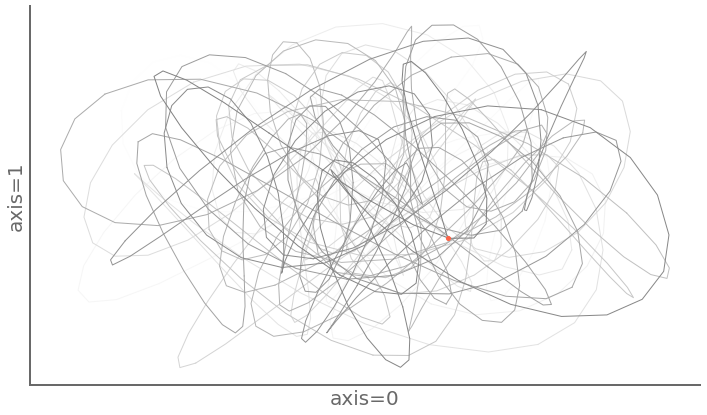

In [6]:
pwk.plot_2d_serie(x_train[:1000], figsize=(12,12), lw=1,ms=4,save_as='01-dataset')

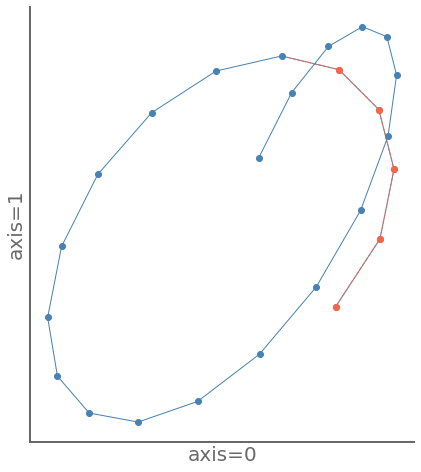

In [7]:
k1,k2 = sequence_len, predict_len
i = random.randint(0,len(x_test)-k1-k2)
j = i+k1

pwk.plot_2d_segment( x_test[i:j+k2], x_test[j:j+k2],ms=6, save_as='02-objectives')

### 2.4 - Prepare some nice data generator

In [8]:
# ---- Train generator
#
train_generator = TimeseriesGenerator(x_train, x_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(x_test,  x_test,  length=sequence_len,  batch_size=batch_size)

# ---- About
#
pwk.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Number of batch trains available : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
pwk.subtitle('What a batch looks like (x) :')
pwk.np_print(x[0] )
pwk.subtitle('What a batch looks like (y) :')
pwk.np_print(y[0])

<br>**About the splitting of our dataset :**

Number of batch trains available :  1250
batch x shape :  (32, 20, 2)
batch y shape :  (32, 2)


<br>**What a batch looks like (x) :**

[[ 1.973e-04  1.973e-04]
 [ 1.511e+00  6.019e-01]
 [ 1.097e+00  5.694e-01]
 [ 6.732e-01  4.095e-01]
 [ 2.772e-01  1.534e-01]
 [-6.037e-02 -1.521e-01]
 [-3.214e-01 -4.520e-01]
 [-5.014e-01 -6.919e-01]
 [-6.096e-01 -8.267e-01]
 [-6.663e-01 -8.277e-01]
 [-6.991e-01 -6.870e-01]
 [-7.382e-01 -4.191e-01]
 [-8.108e-01 -5.863e-02]
 [-9.365e-01  3.454e-01]
 [-1.124e+00  7.367e-01]
 [-1.368e+00  1.061e+00]
 [-1.652e+00  1.274e+00]
 [-1.946e+00  1.349e+00]
 [-2.214e+00  1.281e+00]
 [-2.420e+00  1.086e+00]]


<br>**What a batch looks like (y) :**

[-2.528  0.801]


## Step 3 - Create a model

In [9]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
# model.add( keras.layers.GRU(200, dropout=.1, recurrent_dropout=0.5, return_sequences=False, activation='relu') )
model.add( keras.layers.GRU(200, return_sequences=False, activation='relu') )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 200)               122400    
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 122,802
Trainable params: 122,802
Non-trainable params: 0
_________________________________________________________________


## Step 4 - Compile and run

### 4.1 - Add callback

In [10]:
pwk.mkdir('./run/models')
save_dir = './run/models/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.2 - Compile

In [11]:
model.compile(optimizer='rmsprop', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit
3' with a CPU (laptop)  

In [12]:
pwk.chrono_start()

history=model.fit(train_generator, 
                  epochs=epochs, 
                  verbose=1,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

pwk.chrono_show()

Epoch 1/5


   1/1250 [..............................] - ETA: 0s - loss: 0.5276 - mae: 0.6221

   3/1250 [..............................] - ETA: 22s - loss: 0.7849 - mae: 0.7437

   5/1250 [..............................] - ETA: 26s - loss: 0.8883 - mae: 0.7830

   8/1250 [..............................] - ETA: 27s - loss: 0.7637 - mae: 0.7235

  11/1250 [..............................] - ETA: 26s - loss: 0.6855 - mae: 0.6845

  14/1250 [..............................] - ETA: 25s - loss: 0.6042 - mae: 0.6351

  17/1250 [..............................] - ETA: 25s - loss: 0.5703 - mae: 0.6149

  20/1250 [..............................] - ETA: 25s - loss: 0.5310 - mae: 0.5930

  23/1250 [..............................] - ETA: 24s - loss: 0.5066 - mae: 0.5769

  26/1250 [..............................] - ETA: 24s - loss: 0.4785 - mae: 0.5594

  29/1250 [..............................] - ETA: 24s - loss: 0.5359 - mae: 0.5753

  32/1250 [..............................] - ETA: 24s - loss: 0.5153 - mae: 0.5653

  35/1250 [..............................] - ETA: 24s - loss: 0.4956 - mae: 0.5550

  38/1250 [..............................] - ETA: 24s - loss: 0.4793 - mae: 0.5452

  41/1250 [..............................] - ETA: 24s - loss: 0.4629 - mae: 0.5358

  44/1250 [>.............................] - ETA: 23s - loss: 0.4547 - mae: 0.5316

  47/1250 [>.............................] - ETA: 23s - loss: 0.4401 - mae: 0.5228

  50/1250 [>.............................] - ETA: 23s - loss: 0.4280 - mae: 0.5153

  53/1250 [>.............................] - ETA: 23s - loss: 0.4181 - mae: 0.5102

  56/1250 [>.............................] - ETA: 23s - loss: 0.4068 - mae: 0.5036

  59/1250 [>.............................] - ETA: 23s - loss: 0.3945 - mae: 0.4957

  62/1250 [>.............................] - ETA: 23s - loss: 0.3828 - mae: 0.4876

  65/1250 [>.............................] - ETA: 23s - loss: 0.3818 - mae: 0.4871

  68/1250 [>.............................] - ETA: 23s - loss: 0.3776 - mae: 0.4846

  71/1250 [>.............................] - ETA: 23s - loss: 0.3712 - mae: 0.4800

  74/1250 [>.............................] - ETA: 23s - loss: 0.3659 - mae: 0.4762

  76/1250 [>.............................] - ETA: 23s - loss: 0.3610 - mae: 0.4731

  79/1250 [>.............................] - ETA: 23s - loss: 0.3542 - mae: 0.4690

  82/1250 [>.............................] - ETA: 23s - loss: 0.3481 - mae: 0.4657

  85/1250 [=>............................] - ETA: 23s - loss: 0.3408 - mae: 0.4602

  88/1250 [=>............................] - ETA: 22s - loss: 0.3342 - mae: 0.4557

  91/1250 [=>............................] - ETA: 22s - loss: 0.3278 - mae: 0.4511

  94/1250 [=>............................] - ETA: 22s - loss: 0.3216 - mae: 0.4461

  97/1250 [=>............................] - ETA: 22s - loss: 0.3158 - mae: 0.4418

 100/1250 [=>............................] - ETA: 22s - loss: 0.3097 - mae: 0.4370

 103/1250 [=>............................] - ETA: 22s - loss: 0.3053 - mae: 0.4341

 106/1250 [=>............................] - ETA: 22s - loss: 0.2996 - mae: 0.4294

 109/1250 [=>............................] - ETA: 22s - loss: 0.2937 - mae: 0.4243

 112/1250 [=>............................] - ETA: 22s - loss: 0.2899 - mae: 0.4215

 115/1250 [=>............................] - ETA: 22s - loss: 0.2850 - mae: 0.4177

 118/1250 [=>............................] - ETA: 22s - loss: 0.2801 - mae: 0.4135

 121/1250 [=>............................] - ETA: 22s - loss: 0.2757 - mae: 0.4098

 124/1250 [=>............................] - ETA: 21s - loss: 0.2705 - mae: 0.4050

 127/1250 [==>...........................] - ETA: 21s - loss: 0.2669 - mae: 0.4024

 130/1250 [==>...........................] - ETA: 21s - loss: 0.2629 - mae: 0.3992

 133/1250 [==>...........................] - ETA: 21s - loss: 0.2589 - mae: 0.3959

 136/1250 [==>...........................] - ETA: 21s - loss: 0.2567 - mae: 0.3944

 139/1250 [==>...........................] - ETA: 21s - loss: 0.2542 - mae: 0.3927

 142/1250 [==>...........................] - ETA: 21s - loss: 0.2507 - mae: 0.3898

 145/1250 [==>...........................] - ETA: 21s - loss: 0.2468 - mae: 0.3862

 148/1250 [==>...........................] - ETA: 21s - loss: 0.2428 - mae: 0.3821

 151/1250 [==>...........................] - ETA: 21s - loss: 0.2389 - mae: 0.3781

 154/1250 [==>...........................] - ETA: 21s - loss: 0.2369 - mae: 0.3756

 157/1250 [==>...........................] - ETA: 21s - loss: 0.2348 - mae: 0.3740

 160/1250 [==>...........................] - ETA: 21s - loss: 0.2322 - mae: 0.3720

 163/1250 [==>...........................] - ETA: 21s - loss: 0.2293 - mae: 0.3693

 166/1250 [==>...........................] - ETA: 21s - loss: 0.2266 - mae: 0.3669

 169/1250 [===>..........................] - ETA: 20s - loss: 0.2236 - mae: 0.3639

 172/1250 [===>..........................] - ETA: 20s - loss: 0.2205 - mae: 0.3607

 175/1250 [===>..........................] - ETA: 20s - loss: 0.2178 - mae: 0.3580

 178/1250 [===>..........................] - ETA: 20s - loss: 0.2146 - mae: 0.3544

 181/1250 [===>..........................] - ETA: 20s - loss: 0.2115 - mae: 0.3509

 184/1250 [===>..........................] - ETA: 20s - loss: 0.2086 - mae: 0.3476

 187/1250 [===>..........................] - ETA: 20s - loss: 0.2057 - mae: 0.3442

 190/1250 [===>..........................] - ETA: 20s - loss: 0.2035 - mae: 0.3420

 193/1250 [===>..........................] - ETA: 20s - loss: 0.2007 - mae: 0.3390

 196/1250 [===>..........................] - ETA: 20s - loss: 0.1983 - mae: 0.3364

 199/1250 [===>..........................] - ETA: 20s - loss: 0.1957 - mae: 0.3334

 202/1250 [===>..........................] - ETA: 20s - loss: 0.1932 - mae: 0.3303

 205/1250 [===>..........................] - ETA: 20s - loss: 0.1910 - mae: 0.3279

 208/1250 [===>..........................] - ETA: 20s - loss: 0.1886 - mae: 0.3250

 211/1250 [====>.........................] - ETA: 20s - loss: 0.1864 - mae: 0.3226

 214/1250 [====>.........................] - ETA: 20s - loss: 0.1845 - mae: 0.3207

 217/1250 [====>.........................] - ETA: 19s - loss: 0.1823 - mae: 0.3183

 220/1250 [====>.........................] - ETA: 19s - loss: 0.1801 - mae: 0.3156

 223/1250 [====>.........................] - ETA: 19s - loss: 0.1793 - mae: 0.3151

 226/1250 [====>.........................] - ETA: 19s - loss: 0.1774 - mae: 0.3130

 229/1250 [====>.........................] - ETA: 19s - loss: 0.1754 - mae: 0.3106

 232/1250 [====>.........................] - ETA: 19s - loss: 0.1734 - mae: 0.3083

 235/1250 [====>.........................] - ETA: 19s - loss: 0.1715 - mae: 0.3060

 238/1250 [====>.........................] - ETA: 19s - loss: 0.1695 - mae: 0.3033

 241/1250 [====>.........................] - ETA: 19s - loss: 0.1679 - mae: 0.3016

 244/1250 [====>.........................] - ETA: 19s - loss: 0.1661 - mae: 0.2994

 247/1250 [====>.........................] - ETA: 19s - loss: 0.1646 - mae: 0.2977

 250/1250 [=====>........................] - ETA: 19s - loss: 0.1628 - mae: 0.2951

 253/1250 [=====>........................] - ETA: 19s - loss: 0.1613 - mae: 0.2937

 256/1250 [=====>........................] - ETA: 19s - loss: 0.1598 - mae: 0.2917

 259/1250 [=====>........................] - ETA: 19s - loss: 0.1580 - mae: 0.2893

 262/1250 [=====>........................] - ETA: 19s - loss: 0.1566 - mae: 0.2875

 265/1250 [=====>........................] - ETA: 18s - loss: 0.1550 - mae: 0.2855

 268/1250 [=====>........................] - ETA: 18s - loss: 0.1535 - mae: 0.2836

 271/1250 [=====>........................] - ETA: 18s - loss: 0.1521 - mae: 0.2820

 274/1250 [=====>........................] - ETA: 18s - loss: 0.1507 - mae: 0.2804

 277/1250 [=====>........................] - ETA: 18s - loss: 0.1493 - mae: 0.2787

 280/1250 [=====>........................] - ETA: 18s - loss: 0.1479 - mae: 0.2769

 283/1250 [=====>........................] - ETA: 18s - loss: 0.1465 - mae: 0.2749

 286/1250 [=====>........................] - ETA: 18s - loss: 0.1451 - mae: 0.2729

 289/1250 [=====>........................] - ETA: 18s - loss: 0.1436 - mae: 0.2707

 292/1250 [======>.......................] - ETA: 18s - loss: 0.1425 - mae: 0.2696

 295/1250 [======>.......................] - ETA: 18s - loss: 0.1413 - mae: 0.2680

 298/1250 [======>.......................] - ETA: 18s - loss: 0.1401 - mae: 0.2666

 301/1250 [======>.......................] - ETA: 18s - loss: 0.1388 - mae: 0.2649

 304/1250 [======>.......................] - ETA: 18s - loss: 0.1377 - mae: 0.2636

 307/1250 [======>.......................] - ETA: 18s - loss: 0.1365 - mae: 0.2620

 310/1250 [======>.......................] - ETA: 18s - loss: 0.1353 - mae: 0.2604

 313/1250 [======>.......................] - ETA: 18s - loss: 0.1342 - mae: 0.2590

 316/1250 [======>.......................] - ETA: 17s - loss: 0.1331 - mae: 0.2574

 319/1250 [======>.......................] - ETA: 17s - loss: 0.1321 - mae: 0.2562

 322/1250 [======>.......................] - ETA: 17s - loss: 0.1309 - mae: 0.2545

 325/1250 [======>.......................] - ETA: 17s - loss: 0.1300 - mae: 0.2535

 328/1250 [======>.......................] - ETA: 17s - loss: 0.1289 - mae: 0.2519

 331/1250 [======>.......................] - ETA: 17s - loss: 0.1279 - mae: 0.2509

 334/1250 [=======>......................] - ETA: 17s - loss: 0.1270 - mae: 0.2497

 337/1250 [=======>......................] - ETA: 17s - loss: 0.1259 - mae: 0.2481

 340/1250 [=======>......................] - ETA: 17s - loss: 0.1249 - mae: 0.2467

 343/1250 [=======>......................] - ETA: 17s - loss: 0.1239 - mae: 0.2453

 346/1250 [=======>......................] - ETA: 17s - loss: 0.1229 - mae: 0.2440

 349/1250 [=======>......................] - ETA: 17s - loss: 0.1220 - mae: 0.2428

 352/1250 [=======>......................] - ETA: 17s - loss: 0.1211 - mae: 0.2413

 355/1250 [=======>......................] - ETA: 17s - loss: 0.1201 - mae: 0.2399

 358/1250 [=======>......................] - ETA: 17s - loss: 0.1193 - mae: 0.2388

 361/1250 [=======>......................] - ETA: 17s - loss: 0.1184 - mae: 0.2375

 364/1250 [=======>......................] - ETA: 17s - loss: 0.1176 - mae: 0.2365

 367/1250 [=======>......................] - ETA: 16s - loss: 0.1167 - mae: 0.2355

 370/1250 [=======>......................] - ETA: 16s - loss: 0.1159 - mae: 0.2343

 373/1250 [=======>......................] - ETA: 16s - loss: 0.1150 - mae: 0.2329

 376/1250 [========>.....................] - ETA: 16s - loss: 0.1141 - mae: 0.2315

 379/1250 [========>.....................] - ETA: 16s - loss: 0.1134 - mae: 0.2305

 382/1250 [========>.....................] - ETA: 16s - loss: 0.1126 - mae: 0.2295

 385/1250 [========>.....................] - ETA: 16s - loss: 0.1118 - mae: 0.2281

 388/1250 [========>.....................] - ETA: 16s - loss: 0.1110 - mae: 0.2269

 391/1250 [========>.....................] - ETA: 16s - loss: 0.1102 - mae: 0.2259

 394/1250 [========>.....................] - ETA: 16s - loss: 0.1095 - mae: 0.2248

 397/1250 [========>.....................] - ETA: 16s - loss: 0.1087 - mae: 0.2237

 400/1250 [========>.....................] - ETA: 16s - loss: 0.1080 - mae: 0.2226

 403/1250 [========>.....................] - ETA: 16s - loss: 0.1073 - mae: 0.2217

 406/1250 [========>.....................] - ETA: 16s - loss: 0.1066 - mae: 0.2207

 409/1250 [========>.....................] - ETA: 16s - loss: 0.1059 - mae: 0.2197

 412/1250 [========>.....................] - ETA: 16s - loss: 0.1052 - mae: 0.2185

 415/1250 [========>.....................] - ETA: 16s - loss: 0.1046 - mae: 0.2178

 418/1250 [=========>....................] - ETA: 15s - loss: 0.1039 - mae: 0.2168

 421/1250 [=========>....................] - ETA: 15s - loss: 0.1032 - mae: 0.2159

 424/1250 [=========>....................] - ETA: 15s - loss: 0.1026 - mae: 0.2150

 427/1250 [=========>....................] - ETA: 15s - loss: 0.1019 - mae: 0.2140

 430/1250 [=========>....................] - ETA: 15s - loss: 0.1013 - mae: 0.2130

 433/1250 [=========>....................] - ETA: 15s - loss: 0.1006 - mae: 0.2119

 436/1250 [=========>....................] - ETA: 15s - loss: 0.1001 - mae: 0.2112

 439/1250 [=========>....................] - ETA: 15s - loss: 0.0994 - mae: 0.2102

 442/1250 [=========>....................] - ETA: 15s - loss: 0.0988 - mae: 0.2093

 445/1250 [=========>....................] - ETA: 15s - loss: 0.0982 - mae: 0.2082

 448/1250 [=========>....................] - ETA: 15s - loss: 0.0976 - mae: 0.2073

 451/1250 [=========>....................] - ETA: 15s - loss: 0.0970 - mae: 0.2065

 454/1250 [=========>....................] - ETA: 15s - loss: 0.0964 - mae: 0.2057

 457/1250 [=========>....................] - ETA: 15s - loss: 0.0959 - mae: 0.2050

 460/1250 [==========>...................] - ETA: 15s - loss: 0.0954 - mae: 0.2043

 463/1250 [==========>...................] - ETA: 15s - loss: 0.0948 - mae: 0.2033

 466/1250 [==========>...................] - ETA: 15s - loss: 0.0942 - mae: 0.2024

 469/1250 [==========>...................] - ETA: 14s - loss: 0.0937 - mae: 0.2016

 472/1250 [==========>...................] - ETA: 14s - loss: 0.0931 - mae: 0.2008

 475/1250 [==========>...................] - ETA: 14s - loss: 0.0926 - mae: 0.2001

 478/1250 [==========>...................] - ETA: 14s - loss: 0.0921 - mae: 0.1993

 481/1250 [==========>...................] - ETA: 14s - loss: 0.0916 - mae: 0.1986

 484/1250 [==========>...................] - ETA: 14s - loss: 0.0911 - mae: 0.1978

 487/1250 [==========>...................] - ETA: 14s - loss: 0.0905 - mae: 0.1970

 490/1250 [==========>...................] - ETA: 14s - loss: 0.0900 - mae: 0.1962

 493/1250 [==========>...................] - ETA: 14s - loss: 0.0896 - mae: 0.1957

 496/1250 [==========>...................] - ETA: 14s - loss: 0.0891 - mae: 0.1949

 499/1250 [==========>...................] - ETA: 14s - loss: 0.0886 - mae: 0.1940

 502/1250 [===========>..................] - ETA: 14s - loss: 0.0881 - mae: 0.1934

 505/1250 [===========>..................] - ETA: 14s - loss: 0.0876 - mae: 0.1928

 508/1250 [===========>..................] - ETA: 14s - loss: 0.0872 - mae: 0.1922

 511/1250 [===========>..................] - ETA: 14s - loss: 0.0867 - mae: 0.1913

 514/1250 [===========>..................] - ETA: 14s - loss: 0.0863 - mae: 0.1907

 517/1250 [===========>..................] - ETA: 14s - loss: 0.0858 - mae: 0.1901

 520/1250 [===========>..................] - ETA: 13s - loss: 0.0854 - mae: 0.1892

 523/1250 [===========>..................] - ETA: 13s - loss: 0.0849 - mae: 0.1884

 526/1250 [===========>..................] - ETA: 13s - loss: 0.0844 - mae: 0.1877

 529/1250 [===========>..................] - ETA: 13s - loss: 0.0840 - mae: 0.1871

 532/1250 [===========>..................] - ETA: 13s - loss: 0.0836 - mae: 0.1865

 535/1250 [===========>..................] - ETA: 13s - loss: 0.0832 - mae: 0.1858

 538/1250 [===========>..................] - ETA: 13s - loss: 0.0828 - mae: 0.1852

 541/1250 [===========>..................] - ETA: 13s - loss: 0.0823 - mae: 0.1845

 544/1250 [============>.................] - ETA: 13s - loss: 0.0819 - mae: 0.1839

 547/1250 [============>.................] - ETA: 13s - loss: 0.0815 - mae: 0.1833

 550/1250 [============>.................] - ETA: 13s - loss: 0.0811 - mae: 0.1825

 553/1250 [============>.................] - ETA: 13s - loss: 0.0807 - mae: 0.1819

 556/1250 [============>.................] - ETA: 13s - loss: 0.0803 - mae: 0.1813

 559/1250 [============>.................] - ETA: 13s - loss: 0.0799 - mae: 0.1807

 562/1250 [============>.................] - ETA: 13s - loss: 0.0795 - mae: 0.1800

 565/1250 [============>.................] - ETA: 13s - loss: 0.0791 - mae: 0.1793

 568/1250 [============>.................] - ETA: 13s - loss: 0.0787 - mae: 0.1787

 571/1250 [============>.................] - ETA: 12s - loss: 0.0783 - mae: 0.1781

 574/1250 [============>.................] - ETA: 12s - loss: 0.0780 - mae: 0.1776

 577/1250 [============>.................] - ETA: 12s - loss: 0.0776 - mae: 0.1769

 580/1250 [============>.................] - ETA: 12s - loss: 0.0772 - mae: 0.1764

 583/1250 [============>.................] - ETA: 12s - loss: 0.0769 - mae: 0.1760

 586/1250 [=============>................] - ETA: 12s - loss: 0.0765 - mae: 0.1755

 589/1250 [=============>................] - ETA: 12s - loss: 0.0762 - mae: 0.1748

 592/1250 [=============>................] - ETA: 12s - loss: 0.0758 - mae: 0.1741

 595/1250 [=============>................] - ETA: 12s - loss: 0.0755 - mae: 0.1736

 598/1250 [=============>................] - ETA: 12s - loss: 0.0751 - mae: 0.1730

 601/1250 [=============>................] - ETA: 12s - loss: 0.0747 - mae: 0.1724

 604/1250 [=============>................] - ETA: 12s - loss: 0.0744 - mae: 0.1719

 607/1250 [=============>................] - ETA: 12s - loss: 0.0740 - mae: 0.1712

 610/1250 [=============>................] - ETA: 12s - loss: 0.0737 - mae: 0.1706

 613/1250 [=============>................] - ETA: 12s - loss: 0.0734 - mae: 0.1701

 616/1250 [=============>................] - ETA: 12s - loss: 0.0730 - mae: 0.1696

 619/1250 [=============>................] - ETA: 12s - loss: 0.0727 - mae: 0.1691

 622/1250 [=============>................] - ETA: 12s - loss: 0.0724 - mae: 0.1686

 625/1250 [==============>...............] - ETA: 11s - loss: 0.0721 - mae: 0.1682

 628/1250 [==============>...............] - ETA: 11s - loss: 0.0718 - mae: 0.1676

 631/1250 [==============>...............] - ETA: 11s - loss: 0.0715 - mae: 0.1670

 634/1250 [==============>...............] - ETA: 11s - loss: 0.0712 - mae: 0.1665

 637/1250 [==============>...............] - ETA: 11s - loss: 0.0708 - mae: 0.1660

 640/1250 [==============>...............] - ETA: 11s - loss: 0.0705 - mae: 0.1655

 643/1250 [==============>...............] - ETA: 11s - loss: 0.0702 - mae: 0.1650

 646/1250 [==============>...............] - ETA: 11s - loss: 0.0699 - mae: 0.1645

 649/1250 [==============>...............] - ETA: 11s - loss: 0.0696 - mae: 0.1641

 652/1250 [==============>...............] - ETA: 11s - loss: 0.0694 - mae: 0.1637

 655/1250 [==============>...............] - ETA: 11s - loss: 0.0691 - mae: 0.1632

 658/1250 [==============>...............] - ETA: 11s - loss: 0.0688 - mae: 0.1626

 661/1250 [==============>...............] - ETA: 11s - loss: 0.0685 - mae: 0.1622

 664/1250 [==============>...............] - ETA: 11s - loss: 0.0682 - mae: 0.1617

 667/1250 [===============>..............] - ETA: 11s - loss: 0.0679 - mae: 0.1614

 670/1250 [===============>..............] - ETA: 11s - loss: 0.0677 - mae: 0.1609

 673/1250 [===============>..............] - ETA: 11s - loss: 0.0674 - mae: 0.1605

 676/1250 [===============>..............] - ETA: 10s - loss: 0.0671 - mae: 0.1599

 679/1250 [===============>..............] - ETA: 10s - loss: 0.0668 - mae: 0.1595

 682/1250 [===============>..............] - ETA: 10s - loss: 0.0666 - mae: 0.1590

 685/1250 [===============>..............] - ETA: 10s - loss: 0.0663 - mae: 0.1586

 688/1250 [===============>..............] - ETA: 10s - loss: 0.0660 - mae: 0.1582

 691/1250 [===============>..............] - ETA: 10s - loss: 0.0658 - mae: 0.1578

 694/1250 [===============>..............] - ETA: 10s - loss: 0.0655 - mae: 0.1573

 697/1250 [===============>..............] - ETA: 10s - loss: 0.0653 - mae: 0.1569

 700/1250 [===============>..............] - ETA: 10s - loss: 0.0650 - mae: 0.1565

 703/1250 [===============>..............] - ETA: 10s - loss: 0.0647 - mae: 0.1560

 706/1250 [===============>..............] - ETA: 10s - loss: 0.0645 - mae: 0.1556

 709/1250 [================>.............] - ETA: 10s - loss: 0.0642 - mae: 0.1551

 712/1250 [================>.............] - ETA: 10s - loss: 0.0640 - mae: 0.1548

 715/1250 [================>.............] - ETA: 10s - loss: 0.0638 - mae: 0.1544

 718/1250 [================>.............] - ETA: 10s - loss: 0.0635 - mae: 0.1539

 721/1250 [================>.............] - ETA: 10s - loss: 0.0633 - mae: 0.1536

 724/1250 [================>.............] - ETA: 10s - loss: 0.0631 - mae: 0.1532

 727/1250 [================>.............] - ETA: 9s - loss: 0.0628 - mae: 0.1528 

 730/1250 [================>.............] - ETA: 9s - loss: 0.0626 - mae: 0.1524

 733/1250 [================>.............] - ETA: 9s - loss: 0.0624 - mae: 0.1521

 736/1250 [================>.............] - ETA: 9s - loss: 0.0621 - mae: 0.1517

 739/1250 [================>.............] - ETA: 9s - loss: 0.0619 - mae: 0.1513

 742/1250 [================>.............] - ETA: 9s - loss: 0.0617 - mae: 0.1509

 745/1250 [================>.............] - ETA: 9s - loss: 0.0614 - mae: 0.1505

 748/1250 [================>.............] - ETA: 9s - loss: 0.0612 - mae: 0.1500

 751/1250 [=================>............] - ETA: 9s - loss: 0.0610 - mae: 0.1496

 754/1250 [=================>............] - ETA: 9s - loss: 0.0608 - mae: 0.1494

 757/1250 [=================>............] - ETA: 9s - loss: 0.0605 - mae: 0.1489

 760/1250 [=================>............] - ETA: 9s - loss: 0.0603 - mae: 0.1486

 763/1250 [=================>............] - ETA: 9s - loss: 0.0601 - mae: 0.1482

 766/1250 [=================>............] - ETA: 9s - loss: 0.0599 - mae: 0.1479

 769/1250 [=================>............] - ETA: 9s - loss: 0.0597 - mae: 0.1475

 772/1250 [=================>............] - ETA: 9s - loss: 0.0594 - mae: 0.1472

 775/1250 [=================>............] - ETA: 9s - loss: 0.0592 - mae: 0.1467

 778/1250 [=================>............] - ETA: 9s - loss: 0.0590 - mae: 0.1464

 781/1250 [=================>............] - ETA: 8s - loss: 0.0588 - mae: 0.1460

 784/1250 [=================>............] - ETA: 8s - loss: 0.0586 - mae: 0.1456

 787/1250 [=================>............] - ETA: 8s - loss: 0.0584 - mae: 0.1452

 790/1250 [=================>............] - ETA: 8s - loss: 0.0582 - mae: 0.1448

 793/1250 [==================>...........] - ETA: 8s - loss: 0.0580 - mae: 0.1445

 796/1250 [==================>...........] - ETA: 8s - loss: 0.0578 - mae: 0.1442

 799/1250 [==================>...........] - ETA: 8s - loss: 0.0576 - mae: 0.1438

 802/1250 [==================>...........] - ETA: 8s - loss: 0.0574 - mae: 0.1434

 805/1250 [==================>...........] - ETA: 8s - loss: 0.0572 - mae: 0.1432

 808/1250 [==================>...........] - ETA: 8s - loss: 0.0570 - mae: 0.1429

 811/1250 [==================>...........] - ETA: 8s - loss: 0.0568 - mae: 0.1425

 814/1250 [==================>...........] - ETA: 8s - loss: 0.0566 - mae: 0.1421

 817/1250 [==================>...........] - ETA: 8s - loss: 0.0564 - mae: 0.1417

 820/1250 [==================>...........] - ETA: 8s - loss: 0.0562 - mae: 0.1414

 823/1250 [==================>...........] - ETA: 8s - loss: 0.0560 - mae: 0.1411

 826/1250 [==================>...........] - ETA: 8s - loss: 0.0558 - mae: 0.1408

 829/1250 [==================>...........] - ETA: 8s - loss: 0.0557 - mae: 0.1404

 832/1250 [==================>...........] - ETA: 7s - loss: 0.0555 - mae: 0.1401

 835/1250 [===================>..........] - ETA: 7s - loss: 0.0553 - mae: 0.1398

 838/1250 [===================>..........] - ETA: 7s - loss: 0.0551 - mae: 0.1395

 841/1250 [===================>..........] - ETA: 7s - loss: 0.0549 - mae: 0.1392

 844/1250 [===================>..........] - ETA: 7s - loss: 0.0547 - mae: 0.1388

 847/1250 [===================>..........] - ETA: 7s - loss: 0.0545 - mae: 0.1385

 850/1250 [===================>..........] - ETA: 7s - loss: 0.0544 - mae: 0.1382

 853/1250 [===================>..........] - ETA: 7s - loss: 0.0542 - mae: 0.1379

 856/1250 [===================>..........] - ETA: 7s - loss: 0.0540 - mae: 0.1376

 859/1250 [===================>..........] - ETA: 7s - loss: 0.0538 - mae: 0.1372

 862/1250 [===================>..........] - ETA: 7s - loss: 0.0537 - mae: 0.1369

 865/1250 [===================>..........] - ETA: 7s - loss: 0.0535 - mae: 0.1366

 868/1250 [===================>..........] - ETA: 7s - loss: 0.0533 - mae: 0.1363

 871/1250 [===================>..........] - ETA: 7s - loss: 0.0531 - mae: 0.1360

 874/1250 [===================>..........] - ETA: 7s - loss: 0.0530 - mae: 0.1357

 877/1250 [====================>.........] - ETA: 7s - loss: 0.0528 - mae: 0.1355

 880/1250 [====================>.........] - ETA: 7s - loss: 0.0527 - mae: 0.1352

 883/1250 [====================>.........] - ETA: 6s - loss: 0.0525 - mae: 0.1350

 886/1250 [====================>.........] - ETA: 6s - loss: 0.0523 - mae: 0.1346

 889/1250 [====================>.........] - ETA: 6s - loss: 0.0522 - mae: 0.1343

 892/1250 [====================>.........] - ETA: 6s - loss: 0.0520 - mae: 0.1340

 895/1250 [====================>.........] - ETA: 6s - loss: 0.0518 - mae: 0.1337

 898/1250 [====================>.........] - ETA: 6s - loss: 0.0517 - mae: 0.1334

 901/1250 [====================>.........] - ETA: 6s - loss: 0.0515 - mae: 0.1331

 904/1250 [====================>.........] - ETA: 6s - loss: 0.0514 - mae: 0.1328

 907/1250 [====================>.........] - ETA: 6s - loss: 0.0512 - mae: 0.1325

 910/1250 [====================>.........] - ETA: 6s - loss: 0.0510 - mae: 0.1323

 913/1250 [====================>.........] - ETA: 6s - loss: 0.0509 - mae: 0.1320

 916/1250 [====================>.........] - ETA: 6s - loss: 0.0507 - mae: 0.1317

 919/1250 [=====================>........] - ETA: 6s - loss: 0.0506 - mae: 0.1314

 922/1250 [=====================>........] - ETA: 6s - loss: 0.0504 - mae: 0.1311

 925/1250 [=====================>........] - ETA: 6s - loss: 0.0503 - mae: 0.1309

 928/1250 [=====================>........] - ETA: 6s - loss: 0.0501 - mae: 0.1306

 931/1250 [=====================>........] - ETA: 6s - loss: 0.0500 - mae: 0.1303

 934/1250 [=====================>........] - ETA: 6s - loss: 0.0498 - mae: 0.1300

 937/1250 [=====================>........] - ETA: 5s - loss: 0.0497 - mae: 0.1297

 940/1250 [=====================>........] - ETA: 5s - loss: 0.0495 - mae: 0.1295

 943/1250 [=====================>........] - ETA: 5s - loss: 0.0494 - mae: 0.1293

 946/1250 [=====================>........] - ETA: 5s - loss: 0.0492 - mae: 0.1290

 949/1250 [=====================>........] - ETA: 5s - loss: 0.0491 - mae: 0.1287

 952/1250 [=====================>........] - ETA: 5s - loss: 0.0490 - mae: 0.1285

 955/1250 [=====================>........] - ETA: 5s - loss: 0.0488 - mae: 0.1282

 958/1250 [=====================>........] - ETA: 5s - loss: 0.0487 - mae: 0.1280

 961/1250 [======================>.......] - ETA: 5s - loss: 0.0485 - mae: 0.1277

 964/1250 [======================>.......] - ETA: 5s - loss: 0.0484 - mae: 0.1274

 967/1250 [======================>.......] - ETA: 5s - loss: 0.0482 - mae: 0.1271

 970/1250 [======================>.......] - ETA: 5s - loss: 0.0481 - mae: 0.1269

 973/1250 [======================>.......] - ETA: 5s - loss: 0.0480 - mae: 0.1266

 976/1250 [======================>.......] - ETA: 5s - loss: 0.0478 - mae: 0.1263

 979/1250 [======================>.......] - ETA: 5s - loss: 0.0477 - mae: 0.1261

 982/1250 [======================>.......] - ETA: 5s - loss: 0.0476 - mae: 0.1258

 985/1250 [======================>.......] - ETA: 5s - loss: 0.0474 - mae: 0.1255

 988/1250 [======================>.......] - ETA: 4s - loss: 0.0473 - mae: 0.1253

 991/1250 [======================>.......] - ETA: 4s - loss: 0.0472 - mae: 0.1251

 994/1250 [======================>.......] - ETA: 4s - loss: 0.0470 - mae: 0.1248

 997/1250 [======================>.......] - ETA: 4s - loss: 0.0469 - mae: 0.1246

1000/1250 [=======================>......] - ETA: 4s - loss: 0.0468 - mae: 0.1244

1003/1250 [=======================>......] - ETA: 4s - loss: 0.0466 - mae: 0.1242

1006/1250 [=======================>......] - ETA: 4s - loss: 0.0465 - mae: 0.1239

1009/1250 [=======================>......] - ETA: 4s - loss: 0.0464 - mae: 0.1236

1012/1250 [=======================>......] - ETA: 4s - loss: 0.0462 - mae: 0.1234

1015/1250 [=======================>......] - ETA: 4s - loss: 0.0461 - mae: 0.1232

1018/1250 [=======================>......] - ETA: 4s - loss: 0.0460 - mae: 0.1229

1021/1250 [=======================>......] - ETA: 4s - loss: 0.0459 - mae: 0.1227

1024/1250 [=======================>......] - ETA: 4s - loss: 0.0457 - mae: 0.1225

1027/1250 [=======================>......] - ETA: 4s - loss: 0.0456 - mae: 0.1222

1030/1250 [=======================>......] - ETA: 4s - loss: 0.0455 - mae: 0.1219

1033/1250 [=======================>......] - ETA: 4s - loss: 0.0454 - mae: 0.1217

1036/1250 [=======================>......] - ETA: 4s - loss: 0.0452 - mae: 0.1215

1039/1250 [=======================>......] - ETA: 4s - loss: 0.0451 - mae: 0.1212

1042/1250 [========================>.....] - ETA: 3s - loss: 0.0450 - mae: 0.1210

1045/1250 [========================>.....] - ETA: 3s - loss: 0.0449 - mae: 0.1208

1048/1250 [========================>.....] - ETA: 3s - loss: 0.0448 - mae: 0.1206

1051/1250 [========================>.....] - ETA: 3s - loss: 0.0446 - mae: 0.1203

1054/1250 [========================>.....] - ETA: 3s - loss: 0.0445 - mae: 0.1201

1057/1250 [========================>.....] - ETA: 3s - loss: 0.0444 - mae: 0.1199

1060/1250 [========================>.....] - ETA: 3s - loss: 0.0443 - mae: 0.1197

1063/1250 [========================>.....] - ETA: 3s - loss: 0.0442 - mae: 0.1194

1066/1250 [========================>.....] - ETA: 3s - loss: 0.0440 - mae: 0.1192

1069/1250 [========================>.....] - ETA: 3s - loss: 0.0439 - mae: 0.1190

1072/1250 [========================>.....] - ETA: 3s - loss: 0.0438 - mae: 0.1188

1075/1250 [========================>.....] - ETA: 3s - loss: 0.0437 - mae: 0.1185

1078/1250 [========================>.....] - ETA: 3s - loss: 0.0436 - mae: 0.1184

1081/1250 [========================>.....] - ETA: 3s - loss: 0.0435 - mae: 0.1182

1084/1250 [=========================>....] - ETA: 3s - loss: 0.0434 - mae: 0.1180

1087/1250 [=========================>....] - ETA: 3s - loss: 0.0433 - mae: 0.1178

1090/1250 [=========================>....] - ETA: 3s - loss: 0.0431 - mae: 0.1175

1093/1250 [=========================>....] - ETA: 2s - loss: 0.0430 - mae: 0.1174

1096/1250 [=========================>....] - ETA: 2s - loss: 0.0429 - mae: 0.1171

1099/1250 [=========================>....] - ETA: 2s - loss: 0.0428 - mae: 0.1169

1102/1250 [=========================>....] - ETA: 2s - loss: 0.0427 - mae: 0.1168

1105/1250 [=========================>....] - ETA: 2s - loss: 0.0426 - mae: 0.1165

1108/1250 [=========================>....] - ETA: 2s - loss: 0.0425 - mae: 0.1164

1111/1250 [=========================>....] - ETA: 2s - loss: 0.0424 - mae: 0.1162

1114/1250 [=========================>....] - ETA: 2s - loss: 0.0423 - mae: 0.1160

1117/1250 [=========================>....] - ETA: 2s - loss: 0.0422 - mae: 0.1157

1120/1250 [=========================>....] - ETA: 2s - loss: 0.0421 - mae: 0.1155

1123/1250 [=========================>....] - ETA: 2s - loss: 0.0420 - mae: 0.1153

1126/1250 [==========================>...] - ETA: 2s - loss: 0.0419 - mae: 0.1151

1129/1250 [==========================>...] - ETA: 2s - loss: 0.0418 - mae: 0.1149

1132/1250 [==========================>...] - ETA: 2s - loss: 0.0416 - mae: 0.1147

1135/1250 [==========================>...] - ETA: 2s - loss: 0.0416 - mae: 0.1146

1138/1250 [==========================>...] - ETA: 2s - loss: 0.0415 - mae: 0.1144

1141/1250 [==========================>...] - ETA: 2s - loss: 0.0414 - mae: 0.1142

1144/1250 [==========================>...] - ETA: 2s - loss: 0.0413 - mae: 0.1140

1147/1250 [==========================>...] - ETA: 1s - loss: 0.0411 - mae: 0.1138

1150/1250 [==========================>...] - ETA: 1s - loss: 0.0410 - mae: 0.1136

1153/1250 [==========================>...] - ETA: 1s - loss: 0.0409 - mae: 0.1134

1156/1250 [==========================>...] - ETA: 1s - loss: 0.0408 - mae: 0.1132

1159/1250 [==========================>...] - ETA: 1s - loss: 0.0407 - mae: 0.1130

1162/1250 [==========================>...] - ETA: 1s - loss: 0.0407 - mae: 0.1128

1165/1250 [==========================>...] - ETA: 1s - loss: 0.0406 - mae: 0.1127

1168/1250 [===========================>..] - ETA: 1s - loss: 0.0405 - mae: 0.1124

1171/1250 [===========================>..] - ETA: 1s - loss: 0.0404 - mae: 0.1122

1174/1250 [===========================>..] - ETA: 1s - loss: 0.0403 - mae: 0.1120

1177/1250 [===========================>..] - ETA: 1s - loss: 0.0402 - mae: 0.1118

1180/1250 [===========================>..] - ETA: 1s - loss: 0.0401 - mae: 0.1117

1183/1250 [===========================>..] - ETA: 1s - loss: 0.0400 - mae: 0.1115

1186/1250 [===========================>..] - ETA: 1s - loss: 0.0399 - mae: 0.1113

1189/1250 [===========================>..] - ETA: 1s - loss: 0.0398 - mae: 0.1112

1192/1250 [===========================>..] - ETA: 1s - loss: 0.0397 - mae: 0.1110

1195/1250 [===========================>..] - ETA: 1s - loss: 0.0396 - mae: 0.1108

1198/1250 [===========================>..] - ETA: 0s - loss: 0.0395 - mae: 0.1106

1201/1250 [===========================>..] - ETA: 0s - loss: 0.0394 - mae: 0.1104

1204/1250 [===========================>..] - ETA: 0s - loss: 0.0393 - mae: 0.1102

1207/1250 [===========================>..] - ETA: 0s - loss: 0.0392 - mae: 0.1100

1210/1250 [============================>.] - ETA: 0s - loss: 0.0391 - mae: 0.1098

1213/1250 [============================>.] - ETA: 0s - loss: 0.0391 - mae: 0.1097

1216/1250 [============================>.] - ETA: 0s - loss: 0.0390 - mae: 0.1095

1219/1250 [============================>.] - ETA: 0s - loss: 0.0389 - mae: 0.1093

1222/1250 [============================>.] - ETA: 0s - loss: 0.0388 - mae: 0.1092

1225/1250 [============================>.] - ETA: 0s - loss: 0.0387 - mae: 0.1090

1228/1250 [============================>.] - ETA: 0s - loss: 0.0386 - mae: 0.1088

1231/1250 [============================>.] - ETA: 0s - loss: 0.0385 - mae: 0.1086

1234/1250 [============================>.] - ETA: 0s - loss: 0.0384 - mae: 0.1085

1237/1250 [============================>.] - ETA: 0s - loss: 0.0383 - mae: 0.1083

1240/1250 [============================>.] - ETA: 0s - loss: 0.0383 - mae: 0.1081

1243/1250 [============================>.] - ETA: 0s - loss: 0.0382 - mae: 0.1079

1246/1250 [============================>.] - ETA: 0s - loss: 0.0381 - mae: 0.1078

1249/1250 [============================>.] - ETA: 0s - loss: 0.0380 - mae: 0.1077

1250/1250 [==============================] - 26s 21ms/step - loss: 0.0380 - mae: 0.1076 - val_loss: 0.0017 - val_mae: 0.0323


Epoch 2/5
   1/1250 [..............................] - ETA: 0s - loss: 0.0014 - mae: 0.0272

   4/1250 [..............................] - ETA: 20s - loss: 9.6141e-04 - mae: 0.0232

   7/1250 [..............................] - ETA: 23s - loss: 0.0027 - mae: 0.0367    

  10/1250 [..............................] - ETA: 24s - loss: 0.0025 - mae: 0.0360

  13/1250 [..............................] - ETA: 25s - loss: 0.0023 - mae: 0.0348

  16/1250 [..............................] - ETA: 25s - loss: 0.0024 - mae: 0.0363

  19/1250 [..............................] - ETA: 25s - loss: 0.0025 - mae: 0.0374

  22/1250 [..............................] - ETA: 25s - loss: 0.0023 - mae: 0.0360

  25/1250 [..............................] - ETA: 24s - loss: 0.0023 - mae: 0.0359

  28/1250 [..............................] - ETA: 24s - loss: 0.0022 - mae: 0.0356

  31/1250 [..............................] - ETA: 24s - loss: 0.0025 - mae: 0.0376

  34/1250 [..............................] - ETA: 24s - loss: 0.0025 - mae: 0.0373

  37/1250 [..............................] - ETA: 24s - loss: 0.0024 - mae: 0.0371

  40/1250 [..............................] - ETA: 23s - loss: 0.0025 - mae: 0.0375

  43/1250 [>.............................] - ETA: 23s - loss: 0.0025 - mae: 0.0377

  46/1250 [>.............................] - ETA: 23s - loss: 0.0024 - mae: 0.0374

  49/1250 [>.............................] - ETA: 23s - loss: 0.0023 - mae: 0.0367

  52/1250 [>.............................] - ETA: 23s - loss: 0.0025 - mae: 0.0377

  55/1250 [>.............................] - ETA: 23s - loss: 0.0025 - mae: 0.0374

  58/1250 [>.............................] - ETA: 23s - loss: 0.0024 - mae: 0.0368

  61/1250 [>.............................] - ETA: 23s - loss: 0.0023 - mae: 0.0366

  64/1250 [>.............................] - ETA: 23s - loss: 0.0023 - mae: 0.0366

  67/1250 [>.............................] - ETA: 23s - loss: 0.0024 - mae: 0.0373

  70/1250 [>.............................] - ETA: 22s - loss: 0.0024 - mae: 0.0376

  73/1250 [>.............................] - ETA: 22s - loss: 0.0024 - mae: 0.0374

  76/1250 [>.............................] - ETA: 22s - loss: 0.0023 - mae: 0.0369

  79/1250 [>.............................] - ETA: 22s - loss: 0.0023 - mae: 0.0368

  82/1250 [>.............................] - ETA: 22s - loss: 0.0025 - mae: 0.0379

  85/1250 [=>............................] - ETA: 22s - loss: 0.0025 - mae: 0.0379

  88/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0377

  91/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0379

  94/1250 [=>............................] - ETA: 22s - loss: 0.0025 - mae: 0.0384

  97/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0381

 100/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0379

 103/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0378

 106/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0377

 109/1250 [=>............................] - ETA: 22s - loss: 0.0025 - mae: 0.0382

 112/1250 [=>............................] - ETA: 22s - loss: 0.0025 - mae: 0.0382

 115/1250 [=>............................] - ETA: 22s - loss: 0.0024 - mae: 0.0378

 118/1250 [=>............................] - ETA: 21s - loss: 0.0024 - mae: 0.0379

 121/1250 [=>............................] - ETA: 21s - loss: 0.0025 - mae: 0.0381

 124/1250 [=>............................] - ETA: 21s - loss: 0.0025 - mae: 0.0382

 127/1250 [==>...........................] - ETA: 21s - loss: 0.0024 - mae: 0.0379

 130/1250 [==>...........................] - ETA: 21s - loss: 0.0024 - mae: 0.0375

 133/1250 [==>...........................] - ETA: 21s - loss: 0.0024 - mae: 0.0372

 136/1250 [==>...........................] - ETA: 21s - loss: 0.0024 - mae: 0.0373

 139/1250 [==>...........................] - ETA: 21s - loss: 0.0023 - mae: 0.0371

 142/1250 [==>...........................] - ETA: 21s - loss: 0.0023 - mae: 0.0370

 145/1250 [==>...........................] - ETA: 21s - loss: 0.0024 - mae: 0.0372

 148/1250 [==>...........................] - ETA: 21s - loss: 0.0024 - mae: 0.0377

 151/1250 [==>...........................] - ETA: 21s - loss: 0.0024 - mae: 0.0376

 154/1250 [==>...........................] - ETA: 21s - loss: 0.0024 - mae: 0.0373

 157/1250 [==>...........................] - ETA: 21s - loss: 0.0024 - mae: 0.0375

 160/1250 [==>...........................] - ETA: 21s - loss: 0.0024 - mae: 0.0375

 163/1250 [==>...........................] - ETA: 20s - loss: 0.0024 - mae: 0.0372

 166/1250 [==>...........................] - ETA: 20s - loss: 0.0024 - mae: 0.0372

 169/1250 [===>..........................] - ETA: 20s - loss: 0.0024 - mae: 0.0372

 172/1250 [===>..........................] - ETA: 20s - loss: 0.0024 - mae: 0.0374

 175/1250 [===>..........................] - ETA: 20s - loss: 0.0024 - mae: 0.0372

 178/1250 [===>..........................] - ETA: 20s - loss: 0.0023 - mae: 0.0370

 181/1250 [===>..........................] - ETA: 20s - loss: 0.0023 - mae: 0.0370

 184/1250 [===>..........................] - ETA: 20s - loss: 0.0023 - mae: 0.0371

 187/1250 [===>..........................] - ETA: 20s - loss: 0.0024 - mae: 0.0372

 190/1250 [===>..........................] - ETA: 20s - loss: 0.0023 - mae: 0.0371

 193/1250 [===>..........................] - ETA: 20s - loss: 0.0023 - mae: 0.0371

 196/1250 [===>..........................] - ETA: 20s - loss: 0.0023 - mae: 0.0372

 199/1250 [===>..........................] - ETA: 20s - loss: 0.0023 - mae: 0.0369

 202/1250 [===>..........................] - ETA: 20s - loss: 0.0023 - mae: 0.0368

 205/1250 [===>..........................] - ETA: 20s - loss: 0.0024 - mae: 0.0371

 208/1250 [===>..........................] - ETA: 20s - loss: 0.0024 - mae: 0.0371

 211/1250 [====>.........................] - ETA: 20s - loss: 0.0024 - mae: 0.0371

 214/1250 [====>.........................] - ETA: 19s - loss: 0.0023 - mae: 0.0369

 217/1250 [====>.........................] - ETA: 19s - loss: 0.0023 - mae: 0.0368

 220/1250 [====>.........................] - ETA: 19s - loss: 0.0023 - mae: 0.0366

 223/1250 [====>.........................] - ETA: 19s - loss: 0.0023 - mae: 0.0364

 226/1250 [====>.........................] - ETA: 19s - loss: 0.0023 - mae: 0.0365

 229/1250 [====>.........................] - ETA: 19s - loss: 0.0023 - mae: 0.0365

 232/1250 [====>.........................] - ETA: 19s - loss: 0.0023 - mae: 0.0364

 235/1250 [====>.........................] - ETA: 19s - loss: 0.0023 - mae: 0.0366

 238/1250 [====>.........................] - ETA: 19s - loss: 0.0023 - mae: 0.0367

 241/1250 [====>.........................] - ETA: 19s - loss: 0.0023 - mae: 0.0366

 244/1250 [====>.........................] - ETA: 19s - loss: 0.0023 - mae: 0.0365

 247/1250 [====>.........................] - ETA: 19s - loss: 0.0023 - mae: 0.0364

 250/1250 [=====>........................] - ETA: 19s - loss: 0.0023 - mae: 0.0364

 253/1250 [=====>........................] - ETA: 19s - loss: 0.0023 - mae: 0.0363

 256/1250 [=====>........................] - ETA: 19s - loss: 0.0023 - mae: 0.0363

 259/1250 [=====>........................] - ETA: 19s - loss: 0.0023 - mae: 0.0363

 262/1250 [=====>........................] - ETA: 18s - loss: 0.0023 - mae: 0.0364

 265/1250 [=====>........................] - ETA: 18s - loss: 0.0023 - mae: 0.0362

 268/1250 [=====>........................] - ETA: 18s - loss: 0.0023 - mae: 0.0364

 271/1250 [=====>........................] - ETA: 18s - loss: 0.0023 - mae: 0.0363

 274/1250 [=====>........................] - ETA: 18s - loss: 0.0023 - mae: 0.0363

 277/1250 [=====>........................] - ETA: 18s - loss: 0.0023 - mae: 0.0363

 280/1250 [=====>........................] - ETA: 18s - loss: 0.0023 - mae: 0.0362

 283/1250 [=====>........................] - ETA: 18s - loss: 0.0023 - mae: 0.0361

 286/1250 [=====>........................] - ETA: 18s - loss: 0.0023 - mae: 0.0360

 289/1250 [=====>........................] - ETA: 18s - loss: 0.0022 - mae: 0.0359

 292/1250 [======>.......................] - ETA: 18s - loss: 0.0023 - mae: 0.0360

 295/1250 [======>.......................] - ETA: 18s - loss: 0.0023 - mae: 0.0361

 298/1250 [======>.......................] - ETA: 18s - loss: 0.0023 - mae: 0.0361

 301/1250 [======>.......................] - ETA: 18s - loss: 0.0023 - mae: 0.0360

 304/1250 [======>.......................] - ETA: 18s - loss: 0.0023 - mae: 0.0361

 307/1250 [======>.......................] - ETA: 18s - loss: 0.0023 - mae: 0.0360

 310/1250 [======>.......................] - ETA: 18s - loss: 0.0023 - mae: 0.0360

 313/1250 [======>.......................] - ETA: 17s - loss: 0.0022 - mae: 0.0359

 316/1250 [======>.......................] - ETA: 17s - loss: 0.0022 - mae: 0.0358

 319/1250 [======>.......................] - ETA: 17s - loss: 0.0022 - mae: 0.0358

 322/1250 [======>.......................] - ETA: 17s - loss: 0.0023 - mae: 0.0359

 325/1250 [======>.......................] - ETA: 17s - loss: 0.0022 - mae: 0.0359

 328/1250 [======>.......................] - ETA: 17s - loss: 0.0022 - mae: 0.0357

 331/1250 [======>.......................] - ETA: 17s - loss: 0.0022 - mae: 0.0357

 334/1250 [=======>......................] - ETA: 17s - loss: 0.0022 - mae: 0.0358

 337/1250 [=======>......................] - ETA: 17s - loss: 0.0023 - mae: 0.0359

 340/1250 [=======>......................] - ETA: 17s - loss: 0.0022 - mae: 0.0358

 343/1250 [=======>......................] - ETA: 17s - loss: 0.0022 - mae: 0.0359

 346/1250 [=======>......................] - ETA: 17s - loss: 0.0022 - mae: 0.0357

 349/1250 [=======>......................] - ETA: 17s - loss: 0.0022 - mae: 0.0357

 352/1250 [=======>......................] - ETA: 17s - loss: 0.0022 - mae: 0.0356

 355/1250 [=======>......................] - ETA: 17s - loss: 0.0022 - mae: 0.0355

 358/1250 [=======>......................] - ETA: 17s - loss: 0.0022 - mae: 0.0355

 361/1250 [=======>......................] - ETA: 17s - loss: 0.0022 - mae: 0.0355

 364/1250 [=======>......................] - ETA: 17s - loss: 0.0022 - mae: 0.0355

 367/1250 [=======>......................] - ETA: 17s - loss: 0.0022 - mae: 0.0356

 370/1250 [=======>......................] - ETA: 17s - loss: 0.0022 - mae: 0.0355

 373/1250 [=======>......................] - ETA: 17s - loss: 0.0022 - mae: 0.0355

 376/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0355

 379/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0355

 382/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0355

 385/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0353

 388/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0353

 391/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0352

 394/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0353

 397/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0352

 400/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0354

 403/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0352

 406/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0352

 409/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0352

 412/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0351

 415/1250 [========>.....................] - ETA: 16s - loss: 0.0022 - mae: 0.0352

 418/1250 [=========>....................] - ETA: 16s - loss: 0.0022 - mae: 0.0354

 421/1250 [=========>....................] - ETA: 16s - loss: 0.0022 - mae: 0.0353

 424/1250 [=========>....................] - ETA: 16s - loss: 0.0022 - mae: 0.0353

 427/1250 [=========>....................] - ETA: 16s - loss: 0.0022 - mae: 0.0352

 430/1250 [=========>....................] - ETA: 16s - loss: 0.0022 - mae: 0.0352

 433/1250 [=========>....................] - ETA: 16s - loss: 0.0022 - mae: 0.0352

 436/1250 [=========>....................] - ETA: 15s - loss: 0.0021 - mae: 0.0351

 439/1250 [=========>....................] - ETA: 15s - loss: 0.0021 - mae: 0.0351

 442/1250 [=========>....................] - ETA: 15s - loss: 0.0021 - mae: 0.0351

 445/1250 [=========>....................] - ETA: 15s - loss: 0.0021 - mae: 0.0350

 448/1250 [=========>....................] - ETA: 15s - loss: 0.0021 - mae: 0.0351

 451/1250 [=========>....................] - ETA: 15s - loss: 0.0021 - mae: 0.0350

 454/1250 [=========>....................] - ETA: 15s - loss: 0.0021 - mae: 0.0350

 457/1250 [=========>....................] - ETA: 15s - loss: 0.0021 - mae: 0.0350

 460/1250 [==========>...................] - ETA: 15s - loss: 0.0021 - mae: 0.0350

 463/1250 [==========>...................] - ETA: 15s - loss: 0.0021 - mae: 0.0349

 466/1250 [==========>...................] - ETA: 15s - loss: 0.0021 - mae: 0.0349

 469/1250 [==========>...................] - ETA: 15s - loss: 0.0021 - mae: 0.0349

 472/1250 [==========>...................] - ETA: 15s - loss: 0.0021 - mae: 0.0349

 475/1250 [==========>...................] - ETA: 15s - loss: 0.0021 - mae: 0.0348

 478/1250 [==========>...................] - ETA: 15s - loss: 0.0021 - mae: 0.0348

 481/1250 [==========>...................] - ETA: 15s - loss: 0.0021 - mae: 0.0348

 484/1250 [==========>...................] - ETA: 15s - loss: 0.0021 - mae: 0.0347

 487/1250 [==========>...................] - ETA: 15s - loss: 0.0021 - mae: 0.0348

 490/1250 [==========>...................] - ETA: 15s - loss: 0.0021 - mae: 0.0348

 493/1250 [==========>...................] - ETA: 15s - loss: 0.0021 - mae: 0.0349

 496/1250 [==========>...................] - ETA: 14s - loss: 0.0021 - mae: 0.0348

 499/1250 [==========>...................] - ETA: 14s - loss: 0.0021 - mae: 0.0347

 502/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0347

 505/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0347

 508/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0347

 511/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0348

 514/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0349

 517/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0348

 520/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0348

 523/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0347

 526/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0347

 529/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0347

 532/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0347

 535/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0347

 538/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0346

 541/1250 [===========>..................] - ETA: 14s - loss: 0.0021 - mae: 0.0347

 544/1250 [============>.................] - ETA: 14s - loss: 0.0021 - mae: 0.0346

 547/1250 [============>.................] - ETA: 14s - loss: 0.0021 - mae: 0.0345

 550/1250 [============>.................] - ETA: 13s - loss: 0.0021 - mae: 0.0346

 553/1250 [============>.................] - ETA: 13s - loss: 0.0021 - mae: 0.0345

 556/1250 [============>.................] - ETA: 13s - loss: 0.0021 - mae: 0.0346

 559/1250 [============>.................] - ETA: 13s - loss: 0.0021 - mae: 0.0346

 562/1250 [============>.................] - ETA: 13s - loss: 0.0021 - mae: 0.0345

 565/1250 [============>.................] - ETA: 13s - loss: 0.0021 - mae: 0.0344

 568/1250 [============>.................] - ETA: 13s - loss: 0.0021 - mae: 0.0345

 571/1250 [============>.................] - ETA: 13s - loss: 0.0021 - mae: 0.0345

 574/1250 [============>.................] - ETA: 13s - loss: 0.0021 - mae: 0.0345

 577/1250 [============>.................] - ETA: 13s - loss: 0.0021 - mae: 0.0345

 580/1250 [============>.................] - ETA: 13s - loss: 0.0021 - mae: 0.0345

 583/1250 [============>.................] - ETA: 13s - loss: 0.0021 - mae: 0.0344

 586/1250 [=============>................] - ETA: 13s - loss: 0.0021 - mae: 0.0344

 589/1250 [=============>................] - ETA: 13s - loss: 0.0021 - mae: 0.0344

 592/1250 [=============>................] - ETA: 13s - loss: 0.0021 - mae: 0.0343

 595/1250 [=============>................] - ETA: 13s - loss: 0.0021 - mae: 0.0343

 598/1250 [=============>................] - ETA: 13s - loss: 0.0021 - mae: 0.0343

 601/1250 [=============>................] - ETA: 13s - loss: 0.0021 - mae: 0.0343

 604/1250 [=============>................] - ETA: 12s - loss: 0.0021 - mae: 0.0343

 607/1250 [=============>................] - ETA: 12s - loss: 0.0021 - mae: 0.0343

 610/1250 [=============>................] - ETA: 12s - loss: 0.0020 - mae: 0.0342

 613/1250 [=============>................] - ETA: 12s - loss: 0.0020 - mae: 0.0341

 616/1250 [=============>................] - ETA: 12s - loss: 0.0020 - mae: 0.0341

 619/1250 [=============>................] - ETA: 12s - loss: 0.0020 - mae: 0.0341

 622/1250 [=============>................] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 625/1250 [==============>...............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 628/1250 [==============>...............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 631/1250 [==============>...............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 634/1250 [==============>...............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 637/1250 [==============>...............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 640/1250 [==============>...............] - ETA: 12s - loss: 0.0020 - mae: 0.0339

 643/1250 [==============>...............] - ETA: 12s - loss: 0.0020 - mae: 0.0340

 646/1250 [==============>...............] - ETA: 12s - loss: 0.0020 - mae: 0.0339

 649/1250 [==============>...............] - ETA: 12s - loss: 0.0020 - mae: 0.0339

 652/1250 [==============>...............] - ETA: 12s - loss: 0.0020 - mae: 0.0338

 655/1250 [==============>...............] - ETA: 11s - loss: 0.0020 - mae: 0.0338

 658/1250 [==============>...............] - ETA: 11s - loss: 0.0020 - mae: 0.0339

 661/1250 [==============>...............] - ETA: 11s - loss: 0.0020 - mae: 0.0339

 664/1250 [==============>...............] - ETA: 11s - loss: 0.0020 - mae: 0.0338

 667/1250 [===============>..............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 670/1250 [===============>..............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 673/1250 [===============>..............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 676/1250 [===============>..............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 679/1250 [===============>..............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 682/1250 [===============>..............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 685/1250 [===============>..............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 688/1250 [===============>..............] - ETA: 11s - loss: 0.0020 - mae: 0.0336

 691/1250 [===============>..............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 694/1250 [===============>..............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 697/1250 [===============>..............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 700/1250 [===============>..............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 703/1250 [===============>..............] - ETA: 11s - loss: 0.0020 - mae: 0.0337

 706/1250 [===============>..............] - ETA: 10s - loss: 0.0020 - mae: 0.0336

 709/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0335

 712/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0335

 715/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0336

 718/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0335

 721/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0335

 724/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0335

 727/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0336

 730/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0335

 733/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0335

 736/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0335

 739/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0335

 742/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0335

 745/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0334

 748/1250 [================>.............] - ETA: 10s - loss: 0.0020 - mae: 0.0334

 751/1250 [=================>............] - ETA: 10s - loss: 0.0020 - mae: 0.0334

 754/1250 [=================>............] - ETA: 10s - loss: 0.0020 - mae: 0.0333

 757/1250 [=================>............] - ETA: 9s - loss: 0.0020 - mae: 0.0333 

 760/1250 [=================>............] - ETA: 9s - loss: 0.0020 - mae: 0.0333

 763/1250 [=================>............] - ETA: 9s - loss: 0.0020 - mae: 0.0333

 766/1250 [=================>............] - ETA: 9s - loss: 0.0020 - mae: 0.0334

 769/1250 [=================>............] - ETA: 9s - loss: 0.0020 - mae: 0.0333

 772/1250 [=================>............] - ETA: 9s - loss: 0.0020 - mae: 0.0333

 775/1250 [=================>............] - ETA: 9s - loss: 0.0020 - mae: 0.0333

 778/1250 [=================>............] - ETA: 9s - loss: 0.0020 - mae: 0.0333

 781/1250 [=================>............] - ETA: 9s - loss: 0.0020 - mae: 0.0333

 784/1250 [=================>............] - ETA: 9s - loss: 0.0019 - mae: 0.0333

 787/1250 [=================>............] - ETA: 9s - loss: 0.0019 - mae: 0.0332

 790/1250 [=================>............] - ETA: 9s - loss: 0.0019 - mae: 0.0333

 793/1250 [==================>...........] - ETA: 9s - loss: 0.0019 - mae: 0.0332

 796/1250 [==================>...........] - ETA: 9s - loss: 0.0019 - mae: 0.0332

 799/1250 [==================>...........] - ETA: 9s - loss: 0.0019 - mae: 0.0332

 802/1250 [==================>...........] - ETA: 9s - loss: 0.0019 - mae: 0.0332

 805/1250 [==================>...........] - ETA: 9s - loss: 0.0019 - mae: 0.0331

 808/1250 [==================>...........] - ETA: 8s - loss: 0.0019 - mae: 0.0332

 811/1250 [==================>...........] - ETA: 8s - loss: 0.0019 - mae: 0.0332

 814/1250 [==================>...........] - ETA: 8s - loss: 0.0019 - mae: 0.0332

 817/1250 [==================>...........] - ETA: 8s - loss: 0.0019 - mae: 0.0332

 820/1250 [==================>...........] - ETA: 8s - loss: 0.0019 - mae: 0.0331

 823/1250 [==================>...........] - ETA: 8s - loss: 0.0019 - mae: 0.0331

 826/1250 [==================>...........] - ETA: 8s - loss: 0.0019 - mae: 0.0330

 829/1250 [==================>...........] - ETA: 8s - loss: 0.0019 - mae: 0.0331

 832/1250 [==================>...........] - ETA: 8s - loss: 0.0019 - mae: 0.0330

 835/1250 [===================>..........] - ETA: 8s - loss: 0.0019 - mae: 0.0330

 838/1250 [===================>..........] - ETA: 8s - loss: 0.0019 - mae: 0.0330

 841/1250 [===================>..........] - ETA: 8s - loss: 0.0019 - mae: 0.0330

 844/1250 [===================>..........] - ETA: 8s - loss: 0.0019 - mae: 0.0330

 847/1250 [===================>..........] - ETA: 8s - loss: 0.0019 - mae: 0.0330

 850/1250 [===================>..........] - ETA: 8s - loss: 0.0019 - mae: 0.0329

 853/1250 [===================>..........] - ETA: 8s - loss: 0.0019 - mae: 0.0329

 856/1250 [===================>..........] - ETA: 8s - loss: 0.0019 - mae: 0.0329

 859/1250 [===================>..........] - ETA: 7s - loss: 0.0019 - mae: 0.0329

 862/1250 [===================>..........] - ETA: 7s - loss: 0.0019 - mae: 0.0329

 865/1250 [===================>..........] - ETA: 7s - loss: 0.0019 - mae: 0.0328

 868/1250 [===================>..........] - ETA: 7s - loss: 0.0019 - mae: 0.0328

 871/1250 [===================>..........] - ETA: 7s - loss: 0.0019 - mae: 0.0328

 874/1250 [===================>..........] - ETA: 7s - loss: 0.0019 - mae: 0.0328

 877/1250 [====================>.........] - ETA: 7s - loss: 0.0019 - mae: 0.0328

 880/1250 [====================>.........] - ETA: 7s - loss: 0.0019 - mae: 0.0328

 883/1250 [====================>.........] - ETA: 7s - loss: 0.0019 - mae: 0.0328

 886/1250 [====================>.........] - ETA: 7s - loss: 0.0019 - mae: 0.0328

 889/1250 [====================>.........] - ETA: 7s - loss: 0.0019 - mae: 0.0328

 892/1250 [====================>.........] - ETA: 7s - loss: 0.0019 - mae: 0.0328

 895/1250 [====================>.........] - ETA: 7s - loss: 0.0019 - mae: 0.0329

 898/1250 [====================>.........] - ETA: 7s - loss: 0.0019 - mae: 0.0328

 901/1250 [====================>.........] - ETA: 7s - loss: 0.0019 - mae: 0.0328

 904/1250 [====================>.........] - ETA: 7s - loss: 0.0019 - mae: 0.0328

 907/1250 [====================>.........] - ETA: 7s - loss: 0.0019 - mae: 0.0327

 910/1250 [====================>.........] - ETA: 6s - loss: 0.0019 - mae: 0.0327

 913/1250 [====================>.........] - ETA: 6s - loss: 0.0019 - mae: 0.0326

 916/1250 [====================>.........] - ETA: 6s - loss: 0.0019 - mae: 0.0326

 919/1250 [=====================>........] - ETA: 6s - loss: 0.0019 - mae: 0.0327

 922/1250 [=====================>........] - ETA: 6s - loss: 0.0019 - mae: 0.0327

 925/1250 [=====================>........] - ETA: 6s - loss: 0.0019 - mae: 0.0327

 928/1250 [=====================>........] - ETA: 6s - loss: 0.0019 - mae: 0.0326

 931/1250 [=====================>........] - ETA: 6s - loss: 0.0019 - mae: 0.0326

 934/1250 [=====================>........] - ETA: 6s - loss: 0.0019 - mae: 0.0326

 937/1250 [=====================>........] - ETA: 6s - loss: 0.0019 - mae: 0.0326

 940/1250 [=====================>........] - ETA: 6s - loss: 0.0019 - mae: 0.0326

 943/1250 [=====================>........] - ETA: 6s - loss: 0.0019 - mae: 0.0326

 946/1250 [=====================>........] - ETA: 6s - loss: 0.0019 - mae: 0.0325

 949/1250 [=====================>........] - ETA: 6s - loss: 0.0019 - mae: 0.0325

 952/1250 [=====================>........] - ETA: 6s - loss: 0.0019 - mae: 0.0325

 955/1250 [=====================>........] - ETA: 6s - loss: 0.0019 - mae: 0.0325

 958/1250 [=====================>........] - ETA: 5s - loss: 0.0019 - mae: 0.0325

 961/1250 [======================>.......] - ETA: 5s - loss: 0.0019 - mae: 0.0325

 964/1250 [======================>.......] - ETA: 5s - loss: 0.0019 - mae: 0.0324

 967/1250 [======================>.......] - ETA: 5s - loss: 0.0019 - mae: 0.0325

 970/1250 [======================>.......] - ETA: 5s - loss: 0.0019 - mae: 0.0324

 973/1250 [======================>.......] - ETA: 5s - loss: 0.0019 - mae: 0.0324

 976/1250 [======================>.......] - ETA: 5s - loss: 0.0019 - mae: 0.0324

 979/1250 [======================>.......] - ETA: 5s - loss: 0.0019 - mae: 0.0324

 982/1250 [======================>.......] - ETA: 5s - loss: 0.0019 - mae: 0.0324

 985/1250 [======================>.......] - ETA: 5s - loss: 0.0019 - mae: 0.0324

 988/1250 [======================>.......] - ETA: 5s - loss: 0.0018 - mae: 0.0323

 991/1250 [======================>.......] - ETA: 5s - loss: 0.0018 - mae: 0.0323

 994/1250 [======================>.......] - ETA: 5s - loss: 0.0018 - mae: 0.0322

 997/1250 [======================>.......] - ETA: 5s - loss: 0.0018 - mae: 0.0322

1000/1250 [=======================>......] - ETA: 5s - loss: 0.0018 - mae: 0.0323

1003/1250 [=======================>......] - ETA: 5s - loss: 0.0018 - mae: 0.0323

1006/1250 [=======================>......] - ETA: 4s - loss: 0.0018 - mae: 0.0323

1009/1250 [=======================>......] - ETA: 4s - loss: 0.0018 - mae: 0.0323

1012/1250 [=======================>......] - ETA: 4s - loss: 0.0018 - mae: 0.0323

1015/1250 [=======================>......] - ETA: 4s - loss: 0.0018 - mae: 0.0322

1018/1250 [=======================>......] - ETA: 4s - loss: 0.0018 - mae: 0.0322

1021/1250 [=======================>......] - ETA: 4s - loss: 0.0018 - mae: 0.0322

1024/1250 [=======================>......] - ETA: 4s - loss: 0.0018 - mae: 0.0322

1027/1250 [=======================>......] - ETA: 4s - loss: 0.0018 - mae: 0.0322

1030/1250 [=======================>......] - ETA: 4s - loss: 0.0018 - mae: 0.0322

1033/1250 [=======================>......] - ETA: 4s - loss: 0.0018 - mae: 0.0321

1036/1250 [=======================>......] - ETA: 4s - loss: 0.0018 - mae: 0.0321

1039/1250 [=======================>......] - ETA: 4s - loss: 0.0018 - mae: 0.0321

1042/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0321

1045/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0321

1048/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0321

1051/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0320

1054/1250 [========================>.....] - ETA: 4s - loss: 0.0018 - mae: 0.0321

1057/1250 [========================>.....] - ETA: 3s - loss: 0.0018 - mae: 0.0321

1060/1250 [========================>.....] - ETA: 3s - loss: 0.0018 - mae: 0.0321

1063/1250 [========================>.....] - ETA: 3s - loss: 0.0018 - mae: 0.0321

1066/1250 [========================>.....] - ETA: 3s - loss: 0.0018 - mae: 0.0321

1069/1250 [========================>.....] - ETA: 3s - loss: 0.0018 - mae: 0.0320

1072/1250 [========================>.....] - ETA: 3s - loss: 0.0018 - mae: 0.0320

1075/1250 [========================>.....] - ETA: 3s - loss: 0.0018 - mae: 0.0319

1078/1250 [========================>.....] - ETA: 3s - loss: 0.0018 - mae: 0.0319

1081/1250 [========================>.....] - ETA: 3s - loss: 0.0018 - mae: 0.0319

1084/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0319

1087/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0319

1090/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0319

1093/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0319

1096/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0319

1099/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0319

1102/1250 [=========================>....] - ETA: 3s - loss: 0.0018 - mae: 0.0319

1105/1250 [=========================>....] - ETA: 2s - loss: 0.0018 - mae: 0.0319

1108/1250 [=========================>....] - ETA: 2s - loss: 0.0018 - mae: 0.0319

1111/1250 [=========================>....] - ETA: 2s - loss: 0.0018 - mae: 0.0319

1114/1250 [=========================>....] - ETA: 2s - loss: 0.0018 - mae: 0.0318

1117/1250 [=========================>....] - ETA: 2s - loss: 0.0018 - mae: 0.0318

1120/1250 [=========================>....] - ETA: 2s - loss: 0.0018 - mae: 0.0318

1123/1250 [=========================>....] - ETA: 2s - loss: 0.0018 - mae: 0.0318

1126/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0318

1129/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0318

1132/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0318

1135/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0318

1138/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0318

1141/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0317

1144/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0317

1147/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0317

1150/1250 [==========================>...] - ETA: 2s - loss: 0.0018 - mae: 0.0316

1153/1250 [==========================>...] - ETA: 1s - loss: 0.0018 - mae: 0.0316

1156/1250 [==========================>...] - ETA: 1s - loss: 0.0018 - mae: 0.0317

1159/1250 [==========================>...] - ETA: 1s - loss: 0.0018 - mae: 0.0317

1162/1250 [==========================>...] - ETA: 1s - loss: 0.0018 - mae: 0.0316

1165/1250 [==========================>...] - ETA: 1s - loss: 0.0018 - mae: 0.0316

1168/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0316

1171/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0316

1174/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0315

1177/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0315

1180/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0315

1183/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0315

1186/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0316

1189/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0315

1192/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0315

1195/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0314

1198/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0314

1201/1250 [===========================>..] - ETA: 1s - loss: 0.0018 - mae: 0.0314

1204/1250 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0314

1207/1250 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0314

1210/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0314

1213/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0314

1216/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0314

1219/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0314

1222/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0314

1225/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0314

1228/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0314

1231/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0314

1234/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0314

1237/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0314

1240/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0314

1243/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0313

1246/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0313

1249/1250 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0313

1250/1250 [==============================] - 28s 22ms/step - loss: 0.0018 - mae: 0.0313 - val_loss: 0.0016 - val_mae: 0.0304


Epoch 3/5
   1/1250 [..............................] - ETA: 0s - loss: 0.0014 - mae: 0.0276

   4/1250 [..............................] - ETA: 20s - loss: 0.0021 - mae: 0.0356

   7/1250 [..............................] - ETA: 23s - loss: 0.0015 - mae: 0.0307

  10/1250 [..............................] - ETA: 24s - loss: 0.0017 - mae: 0.0326

  13/1250 [..............................] - ETA: 24s - loss: 0.0017 - mae: 0.0324

  16/1250 [..............................] - ETA: 25s - loss: 0.0020 - mae: 0.0350

  19/1250 [..............................] - ETA: 25s - loss: 0.0018 - mae: 0.0330

  22/1250 [..............................] - ETA: 25s - loss: 0.0018 - mae: 0.0330

  25/1250 [..............................] - ETA: 25s - loss: 0.0017 - mae: 0.0315

  28/1250 [..............................] - ETA: 26s - loss: 0.0015 - mae: 0.0298

  31/1250 [..............................] - ETA: 26s - loss: 0.0015 - mae: 0.0286

  34/1250 [..............................] - ETA: 26s - loss: 0.0014 - mae: 0.0280

  37/1250 [..............................] - ETA: 26s - loss: 0.0014 - mae: 0.0279

  40/1250 [..............................] - ETA: 26s - loss: 0.0014 - mae: 0.0286

  43/1250 [>.............................] - ETA: 26s - loss: 0.0014 - mae: 0.0278

  46/1250 [>.............................] - ETA: 26s - loss: 0.0016 - mae: 0.0290

  49/1250 [>.............................] - ETA: 26s - loss: 0.0015 - mae: 0.0281

  52/1250 [>.............................] - ETA: 25s - loss: 0.0015 - mae: 0.0278

  55/1250 [>.............................] - ETA: 25s - loss: 0.0015 - mae: 0.0277

  58/1250 [>.............................] - ETA: 25s - loss: 0.0015 - mae: 0.0281

  61/1250 [>.............................] - ETA: 25s - loss: 0.0015 - mae: 0.0278

  64/1250 [>.............................] - ETA: 25s - loss: 0.0014 - mae: 0.0274

  67/1250 [>.............................] - ETA: 25s - loss: 0.0014 - mae: 0.0273

  70/1250 [>.............................] - ETA: 25s - loss: 0.0014 - mae: 0.0269

  73/1250 [>.............................] - ETA: 25s - loss: 0.0014 - mae: 0.0273

  76/1250 [>.............................] - ETA: 25s - loss: 0.0014 - mae: 0.0273

  79/1250 [>.............................] - ETA: 25s - loss: 0.0014 - mae: 0.0272

  82/1250 [>.............................] - ETA: 25s - loss: 0.0014 - mae: 0.0270

  85/1250 [=>............................] - ETA: 25s - loss: 0.0014 - mae: 0.0269

  88/1250 [=>............................] - ETA: 25s - loss: 0.0014 - mae: 0.0272

  91/1250 [=>............................] - ETA: 25s - loss: 0.0014 - mae: 0.0272

  94/1250 [=>............................] - ETA: 25s - loss: 0.0014 - mae: 0.0272

  97/1250 [=>............................] - ETA: 25s - loss: 0.0014 - mae: 0.0270

 100/1250 [=>............................] - ETA: 25s - loss: 0.0014 - mae: 0.0275

 103/1250 [=>............................] - ETA: 25s - loss: 0.0014 - mae: 0.0275

 106/1250 [=>............................] - ETA: 24s - loss: 0.0014 - mae: 0.0274

 109/1250 [=>............................] - ETA: 24s - loss: 0.0014 - mae: 0.0272

 112/1250 [=>............................] - ETA: 24s - loss: 0.0013 - mae: 0.0270

 115/1250 [=>............................] - ETA: 24s - loss: 0.0013 - mae: 0.0271

 118/1250 [=>............................] - ETA: 24s - loss: 0.0013 - mae: 0.0271

 121/1250 [=>............................] - ETA: 24s - loss: 0.0014 - mae: 0.0277

 124/1250 [=>............................] - ETA: 24s - loss: 0.0014 - mae: 0.0275

 126/1250 [==>...........................] - ETA: 24s - loss: 0.0014 - mae: 0.0274

 128/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0274

 130/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0274

 132/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0274

 134/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0274

 136/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0274

 138/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0274

 140/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0273

 142/1250 [==>...........................] - ETA: 25s - loss: 0.0013 - mae: 0.0272

 144/1250 [==>...........................] - ETA: 25s - loss: 0.0013 - mae: 0.0272

 146/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0273

 148/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0273

 150/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0272

 152/1250 [==>...........................] - ETA: 25s - loss: 0.0013 - mae: 0.0272

 154/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0273

 156/1250 [==>...........................] - ETA: 25s - loss: 0.0013 - mae: 0.0271

 158/1250 [==>...........................] - ETA: 25s - loss: 0.0013 - mae: 0.0271

 160/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0273

 162/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0272

 165/1250 [==>...........................] - ETA: 25s - loss: 0.0014 - mae: 0.0271

 167/1250 [===>..........................] - ETA: 25s - loss: 0.0014 - mae: 0.0272

 169/1250 [===>..........................] - ETA: 25s - loss: 0.0014 - mae: 0.0273

 172/1250 [===>..........................] - ETA: 25s - loss: 0.0013 - mae: 0.0272

 175/1250 [===>..........................] - ETA: 25s - loss: 0.0013 - mae: 0.0271

 177/1250 [===>..........................] - ETA: 25s - loss: 0.0013 - mae: 0.0271

 179/1250 [===>..........................] - ETA: 25s - loss: 0.0013 - mae: 0.0271

 182/1250 [===>..........................] - ETA: 25s - loss: 0.0013 - mae: 0.0269

 185/1250 [===>..........................] - ETA: 25s - loss: 0.0013 - mae: 0.0271

 188/1250 [===>..........................] - ETA: 25s - loss: 0.0013 - mae: 0.0271

 191/1250 [===>..........................] - ETA: 25s - loss: 0.0013 - mae: 0.0270

 194/1250 [===>..........................] - ETA: 25s - loss: 0.0013 - mae: 0.0269

 197/1250 [===>..........................] - ETA: 24s - loss: 0.0013 - mae: 0.0269

 200/1250 [===>..........................] - ETA: 24s - loss: 0.0013 - mae: 0.0267

 203/1250 [===>..........................] - ETA: 24s - loss: 0.0013 - mae: 0.0267

 206/1250 [===>..........................] - ETA: 24s - loss: 0.0013 - mae: 0.0265

 209/1250 [====>.........................] - ETA: 24s - loss: 0.0013 - mae: 0.0266

 212/1250 [====>.........................] - ETA: 24s - loss: 0.0013 - mae: 0.0267

 215/1250 [====>.........................] - ETA: 24s - loss: 0.0013 - mae: 0.0268

 218/1250 [====>.........................] - ETA: 24s - loss: 0.0013 - mae: 0.0269

 221/1250 [====>.........................] - ETA: 24s - loss: 0.0013 - mae: 0.0270

 224/1250 [====>.........................] - ETA: 24s - loss: 0.0013 - mae: 0.0269

 227/1250 [====>.........................] - ETA: 24s - loss: 0.0013 - mae: 0.0269

 230/1250 [====>.........................] - ETA: 23s - loss: 0.0013 - mae: 0.0270

 233/1250 [====>.........................] - ETA: 23s - loss: 0.0013 - mae: 0.0268

 236/1250 [====>.........................] - ETA: 23s - loss: 0.0013 - mae: 0.0269

 239/1250 [====>.........................] - ETA: 23s - loss: 0.0013 - mae: 0.0268

 242/1250 [====>.........................] - ETA: 23s - loss: 0.0013 - mae: 0.0269

 245/1250 [====>.........................] - ETA: 23s - loss: 0.0013 - mae: 0.0267

 248/1250 [====>.........................] - ETA: 23s - loss: 0.0013 - mae: 0.0268

 251/1250 [=====>........................] - ETA: 23s - loss: 0.0013 - mae: 0.0269

 254/1250 [=====>........................] - ETA: 23s - loss: 0.0013 - mae: 0.0269

 257/1250 [=====>........................] - ETA: 23s - loss: 0.0013 - mae: 0.0268

 260/1250 [=====>........................] - ETA: 23s - loss: 0.0013 - mae: 0.0267

 263/1250 [=====>........................] - ETA: 22s - loss: 0.0013 - mae: 0.0268

 266/1250 [=====>........................] - ETA: 22s - loss: 0.0013 - mae: 0.0269

 269/1250 [=====>........................] - ETA: 22s - loss: 0.0013 - mae: 0.0269

 272/1250 [=====>........................] - ETA: 22s - loss: 0.0013 - mae: 0.0267

 275/1250 [=====>........................] - ETA: 22s - loss: 0.0013 - mae: 0.0266

 278/1250 [=====>........................] - ETA: 22s - loss: 0.0013 - mae: 0.0265

 281/1250 [=====>........................] - ETA: 22s - loss: 0.0013 - mae: 0.0264

 284/1250 [=====>........................] - ETA: 22s - loss: 0.0013 - mae: 0.0264

 287/1250 [=====>........................] - ETA: 22s - loss: 0.0013 - mae: 0.0265

 290/1250 [=====>........................] - ETA: 22s - loss: 0.0013 - mae: 0.0265

 293/1250 [======>.......................] - ETA: 22s - loss: 0.0013 - mae: 0.0265

 296/1250 [======>.......................] - ETA: 22s - loss: 0.0013 - mae: 0.0264

 299/1250 [======>.......................] - ETA: 22s - loss: 0.0013 - mae: 0.0262



 302/1250 [======>.......................] - ETA: 21s - loss: 0.0013 - mae: 0.0262

 305/1250 [======>.......................] - ETA: 21s - loss: 0.0013 - mae: 0.0263

 308/1250 [======>.......................] - ETA: 21s - loss: 0.0013 - mae: 0.0263

 311/1250 [======>.......................] - ETA: 21s - loss: 0.0013 - mae: 0.0264

 314/1250 [======>.......................] - ETA: 21s - loss: 0.0013 - mae: 0.0263

 317/1250 [======>.......................] - ETA: 21s - loss: 0.0013 - mae: 0.0263

 320/1250 [======>.......................] - ETA: 21s - loss: 0.0013 - mae: 0.0263

 323/1250 [======>.......................] - ETA: 21s - loss: 0.0013 - mae: 0.0263

 326/1250 [======>.......................] - ETA: 21s - loss: 0.0013 - mae: 0.0264

 329/1250 [======>.......................] - ETA: 21s - loss: 0.0012 - mae: 0.0263

 332/1250 [======>.......................] - ETA: 21s - loss: 0.0012 - mae: 0.0261

 335/1250 [=======>......................] - ETA: 21s - loss: 0.0012 - mae: 0.0261

 338/1250 [=======>......................] - ETA: 20s - loss: 0.0012 - mae: 0.0262

 341/1250 [=======>......................] - ETA: 20s - loss: 0.0013 - mae: 0.0263

 344/1250 [=======>......................] - ETA: 20s - loss: 0.0013 - mae: 0.0263

 347/1250 [=======>......................] - ETA: 20s - loss: 0.0013 - mae: 0.0264

 350/1250 [=======>......................] - ETA: 20s - loss: 0.0013 - mae: 0.0263

 353/1250 [=======>......................] - ETA: 20s - loss: 0.0013 - mae: 0.0263

 356/1250 [=======>......................] - ETA: 20s - loss: 0.0013 - mae: 0.0262

 359/1250 [=======>......................] - ETA: 20s - loss: 0.0013 - mae: 0.0263

 362/1250 [=======>......................] - ETA: 20s - loss: 0.0013 - mae: 0.0262

 365/1250 [=======>......................] - ETA: 20s - loss: 0.0012 - mae: 0.0261

 368/1250 [=======>......................] - ETA: 20s - loss: 0.0012 - mae: 0.0261

 371/1250 [=======>......................] - ETA: 20s - loss: 0.0012 - mae: 0.0261

 374/1250 [=======>......................] - ETA: 20s - loss: 0.0012 - mae: 0.0261

 377/1250 [========>.....................] - ETA: 19s - loss: 0.0012 - mae: 0.0261

 380/1250 [========>.....................] - ETA: 19s - loss: 0.0013 - mae: 0.0262

 383/1250 [========>.....................] - ETA: 19s - loss: 0.0013 - mae: 0.0263

 386/1250 [========>.....................] - ETA: 19s - loss: 0.0012 - mae: 0.0262

 389/1250 [========>.....................] - ETA: 19s - loss: 0.0012 - mae: 0.0262

 392/1250 [========>.....................] - ETA: 19s - loss: 0.0012 - mae: 0.0261

 395/1250 [========>.....................] - ETA: 19s - loss: 0.0012 - mae: 0.0261

 398/1250 [========>.....................] - ETA: 19s - loss: 0.0012 - mae: 0.0262

 401/1250 [========>.....................] - ETA: 19s - loss: 0.0012 - mae: 0.0262

 404/1250 [========>.....................] - ETA: 19s - loss: 0.0012 - mae: 0.0261

 407/1250 [========>.....................] - ETA: 19s - loss: 0.0012 - mae: 0.0262

 410/1250 [========>.....................] - ETA: 19s - loss: 0.0012 - mae: 0.0262

 413/1250 [========>.....................] - ETA: 19s - loss: 0.0012 - mae: 0.0261

 416/1250 [========>.....................] - ETA: 18s - loss: 0.0012 - mae: 0.0261

 419/1250 [=========>....................] - ETA: 18s - loss: 0.0012 - mae: 0.0262

 422/1250 [=========>....................] - ETA: 18s - loss: 0.0012 - mae: 0.0261

 425/1250 [=========>....................] - ETA: 18s - loss: 0.0012 - mae: 0.0262

 428/1250 [=========>....................] - ETA: 18s - loss: 0.0012 - mae: 0.0262

 431/1250 [=========>....................] - ETA: 18s - loss: 0.0012 - mae: 0.0261

 434/1250 [=========>....................] - ETA: 18s - loss: 0.0012 - mae: 0.0262

 437/1250 [=========>....................] - ETA: 18s - loss: 0.0012 - mae: 0.0262

 440/1250 [=========>....................] - ETA: 18s - loss: 0.0012 - mae: 0.0261

 443/1250 [=========>....................] - ETA: 18s - loss: 0.0012 - mae: 0.0261

 446/1250 [=========>....................] - ETA: 18s - loss: 0.0012 - mae: 0.0261

 449/1250 [=========>....................] - ETA: 18s - loss: 0.0012 - mae: 0.0262

 452/1250 [=========>....................] - ETA: 18s - loss: 0.0013 - mae: 0.0263

 455/1250 [=========>....................] - ETA: 18s - loss: 0.0013 - mae: 0.0263

 458/1250 [=========>....................] - ETA: 17s - loss: 0.0012 - mae: 0.0262

 461/1250 [==========>...................] - ETA: 17s - loss: 0.0012 - mae: 0.0262

 464/1250 [==========>...................] - ETA: 17s - loss: 0.0012 - mae: 0.0261

 467/1250 [==========>...................] - ETA: 17s - loss: 0.0012 - mae: 0.0261

 470/1250 [==========>...................] - ETA: 17s - loss: 0.0012 - mae: 0.0261

 473/1250 [==========>...................] - ETA: 17s - loss: 0.0012 - mae: 0.0261

 476/1250 [==========>...................] - ETA: 17s - loss: 0.0012 - mae: 0.0262

 479/1250 [==========>...................] - ETA: 17s - loss: 0.0012 - mae: 0.0262

 482/1250 [==========>...................] - ETA: 17s - loss: 0.0012 - mae: 0.0262

 485/1250 [==========>...................] - ETA: 17s - loss: 0.0012 - mae: 0.0262

 488/1250 [==========>...................] - ETA: 17s - loss: 0.0012 - mae: 0.0261

 491/1250 [==========>...................] - ETA: 17s - loss: 0.0012 - mae: 0.0262

 494/1250 [==========>...................] - ETA: 17s - loss: 0.0012 - mae: 0.0261

 497/1250 [==========>...................] - ETA: 17s - loss: 0.0012 - mae: 0.0261

 500/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0261

 503/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0261

 506/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0260

 509/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0261

 512/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0261

 515/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0260

 518/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0260

 521/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0260

 524/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0260

 527/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0260

 530/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0260

 533/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0260

 536/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0260

 539/1250 [===========>..................] - ETA: 16s - loss: 0.0012 - mae: 0.0259

 542/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0259

 545/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0259

 548/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0259

 551/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0259

 554/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0259

 557/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0259

 560/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0259

 563/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0258

 566/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0258

 569/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0258

 572/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0258

 575/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0258

 578/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0258

 581/1250 [============>.................] - ETA: 15s - loss: 0.0012 - mae: 0.0258

 584/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0258

 587/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0258

 590/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0258

 593/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0258

 596/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0258

 599/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0259

 602/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0259

 605/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0258

 608/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0257

 611/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0258

 614/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0257

 617/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0257

 620/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0257

 623/1250 [=============>................] - ETA: 14s - loss: 0.0012 - mae: 0.0257

 626/1250 [==============>...............] - ETA: 14s - loss: 0.0012 - mae: 0.0257

 629/1250 [==============>...............] - ETA: 13s - loss: 0.0012 - mae: 0.0257

 632/1250 [==============>...............] - ETA: 13s - loss: 0.0012 - mae: 0.0257

 635/1250 [==============>...............] - ETA: 13s - loss: 0.0012 - mae: 0.0257

 638/1250 [==============>...............] - ETA: 13s - loss: 0.0012 - mae: 0.0257

 641/1250 [==============>...............] - ETA: 13s - loss: 0.0012 - mae: 0.0256

 644/1250 [==============>...............] - ETA: 13s - loss: 0.0012 - mae: 0.0257

 647/1250 [==============>...............] - ETA: 13s - loss: 0.0012 - mae: 0.0257

 650/1250 [==============>...............] - ETA: 13s - loss: 0.0012 - mae: 0.0257

 653/1250 [==============>...............] - ETA: 13s - loss: 0.0012 - mae: 0.0257

 656/1250 [==============>...............] - ETA: 13s - loss: 0.0012 - mae: 0.0257

 659/1250 [==============>...............] - ETA: 13s - loss: 0.0012 - mae: 0.0256

 662/1250 [==============>...............] - ETA: 13s - loss: 0.0012 - mae: 0.0256

 665/1250 [==============>...............] - ETA: 13s - loss: 0.0012 - mae: 0.0256

 668/1250 [===============>..............] - ETA: 13s - loss: 0.0012 - mae: 0.0256

 671/1250 [===============>..............] - ETA: 12s - loss: 0.0012 - mae: 0.0256

 674/1250 [===============>..............] - ETA: 12s - loss: 0.0012 - mae: 0.0257

 677/1250 [===============>..............] - ETA: 12s - loss: 0.0012 - mae: 0.0256

 680/1250 [===============>..............] - ETA: 12s - loss: 0.0012 - mae: 0.0256

 683/1250 [===============>..............] - ETA: 12s - loss: 0.0012 - mae: 0.0255

 686/1250 [===============>..............] - ETA: 12s - loss: 0.0012 - mae: 0.0256

 689/1250 [===============>..............] - ETA: 12s - loss: 0.0012 - mae: 0.0256

 692/1250 [===============>..............] - ETA: 12s - loss: 0.0012 - mae: 0.0256

 695/1250 [===============>..............] - ETA: 12s - loss: 0.0012 - mae: 0.0255

 698/1250 [===============>..............] - ETA: 12s - loss: 0.0012 - mae: 0.0255

 701/1250 [===============>..............] - ETA: 12s - loss: 0.0012 - mae: 0.0255

 704/1250 [===============>..............] - ETA: 12s - loss: 0.0012 - mae: 0.0255

 707/1250 [===============>..............] - ETA: 12s - loss: 0.0012 - mae: 0.0255

 710/1250 [================>.............] - ETA: 12s - loss: 0.0012 - mae: 0.0254

 713/1250 [================>.............] - ETA: 12s - loss: 0.0012 - mae: 0.0254

 716/1250 [================>.............] - ETA: 11s - loss: 0.0012 - mae: 0.0254

 719/1250 [================>.............] - ETA: 11s - loss: 0.0012 - mae: 0.0254

 722/1250 [================>.............] - ETA: 11s - loss: 0.0012 - mae: 0.0254

 725/1250 [================>.............] - ETA: 11s - loss: 0.0012 - mae: 0.0254

 728/1250 [================>.............] - ETA: 11s - loss: 0.0012 - mae: 0.0255

 731/1250 [================>.............] - ETA: 11s - loss: 0.0012 - mae: 0.0255

 734/1250 [================>.............] - ETA: 11s - loss: 0.0012 - mae: 0.0255

 737/1250 [================>.............] - ETA: 11s - loss: 0.0012 - mae: 0.0254

 740/1250 [================>.............] - ETA: 11s - loss: 0.0012 - mae: 0.0254

 743/1250 [================>.............] - ETA: 11s - loss: 0.0012 - mae: 0.0254

 746/1250 [================>.............] - ETA: 11s - loss: 0.0012 - mae: 0.0254

 749/1250 [================>.............] - ETA: 11s - loss: 0.0012 - mae: 0.0254

 752/1250 [=================>............] - ETA: 11s - loss: 0.0012 - mae: 0.0254

 755/1250 [=================>............] - ETA: 11s - loss: 0.0012 - mae: 0.0254

 758/1250 [=================>............] - ETA: 11s - loss: 0.0012 - mae: 0.0253

 761/1250 [=================>............] - ETA: 10s - loss: 0.0012 - mae: 0.0254

 764/1250 [=================>............] - ETA: 10s - loss: 0.0012 - mae: 0.0254

 767/1250 [=================>............] - ETA: 10s - loss: 0.0012 - mae: 0.0254

 770/1250 [=================>............] - ETA: 10s - loss: 0.0012 - mae: 0.0254

 773/1250 [=================>............] - ETA: 10s - loss: 0.0012 - mae: 0.0254

 776/1250 [=================>............] - ETA: 10s - loss: 0.0012 - mae: 0.0253

 779/1250 [=================>............] - ETA: 10s - loss: 0.0012 - mae: 0.0253

 782/1250 [=================>............] - ETA: 10s - loss: 0.0012 - mae: 0.0253

 785/1250 [=================>............] - ETA: 10s - loss: 0.0012 - mae: 0.0253

 788/1250 [=================>............] - ETA: 10s - loss: 0.0012 - mae: 0.0253

 791/1250 [=================>............] - ETA: 10s - loss: 0.0012 - mae: 0.0253

 794/1250 [==================>...........] - ETA: 10s - loss: 0.0012 - mae: 0.0253

 797/1250 [==================>...........] - ETA: 10s - loss: 0.0012 - mae: 0.0253

 800/1250 [==================>...........] - ETA: 10s - loss: 0.0012 - mae: 0.0253

 803/1250 [==================>...........] - ETA: 9s - loss: 0.0011 - mae: 0.0253 

 806/1250 [==================>...........] - ETA: 9s - loss: 0.0012 - mae: 0.0253

 809/1250 [==================>...........] - ETA: 9s - loss: 0.0012 - mae: 0.0253

 812/1250 [==================>...........] - ETA: 9s - loss: 0.0012 - mae: 0.0253

 815/1250 [==================>...........] - ETA: 9s - loss: 0.0012 - mae: 0.0253

 818/1250 [==================>...........] - ETA: 9s - loss: 0.0011 - mae: 0.0253

 821/1250 [==================>...........] - ETA: 9s - loss: 0.0012 - mae: 0.0253

 824/1250 [==================>...........] - ETA: 9s - loss: 0.0012 - mae: 0.0253

 827/1250 [==================>...........] - ETA: 9s - loss: 0.0012 - mae: 0.0253

 830/1250 [==================>...........] - ETA: 9s - loss: 0.0012 - mae: 0.0253

 833/1250 [==================>...........] - ETA: 9s - loss: 0.0012 - mae: 0.0253

 836/1250 [===================>..........] - ETA: 9s - loss: 0.0012 - mae: 0.0253

 839/1250 [===================>..........] - ETA: 9s - loss: 0.0012 - mae: 0.0253

 842/1250 [===================>..........] - ETA: 9s - loss: 0.0011 - mae: 0.0253

 845/1250 [===================>..........] - ETA: 9s - loss: 0.0011 - mae: 0.0253

 848/1250 [===================>..........] - ETA: 8s - loss: 0.0011 - mae: 0.0253

 851/1250 [===================>..........] - ETA: 8s - loss: 0.0011 - mae: 0.0253

 854/1250 [===================>..........] - ETA: 8s - loss: 0.0011 - mae: 0.0253

 857/1250 [===================>..........] - ETA: 8s - loss: 0.0011 - mae: 0.0253

 860/1250 [===================>..........] - ETA: 8s - loss: 0.0011 - mae: 0.0252

 863/1250 [===================>..........] - ETA: 8s - loss: 0.0011 - mae: 0.0252

 866/1250 [===================>..........] - ETA: 8s - loss: 0.0011 - mae: 0.0253

 869/1250 [===================>..........] - ETA: 8s - loss: 0.0011 - mae: 0.0253

 872/1250 [===================>..........] - ETA: 8s - loss: 0.0011 - mae: 0.0252

 875/1250 [====================>.........] - ETA: 8s - loss: 0.0011 - mae: 0.0252

 878/1250 [====================>.........] - ETA: 8s - loss: 0.0011 - mae: 0.0252

 881/1250 [====================>.........] - ETA: 8s - loss: 0.0011 - mae: 0.0253

 884/1250 [====================>.........] - ETA: 8s - loss: 0.0011 - mae: 0.0253

 887/1250 [====================>.........] - ETA: 8s - loss: 0.0011 - mae: 0.0252

 890/1250 [====================>.........] - ETA: 8s - loss: 0.0011 - mae: 0.0252

 893/1250 [====================>.........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 896/1250 [====================>.........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 899/1250 [====================>.........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 902/1250 [====================>.........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 905/1250 [====================>.........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 908/1250 [====================>.........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 911/1250 [====================>.........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 914/1250 [====================>.........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 917/1250 [=====================>........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 920/1250 [=====================>........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 923/1250 [=====================>........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 926/1250 [=====================>........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 929/1250 [=====================>........] - ETA: 7s - loss: 0.0011 - mae: 0.0253

 932/1250 [=====================>........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 935/1250 [=====================>........] - ETA: 7s - loss: 0.0011 - mae: 0.0252

 938/1250 [=====================>........] - ETA: 6s - loss: 0.0011 - mae: 0.0252

 941/1250 [=====================>........] - ETA: 6s - loss: 0.0011 - mae: 0.0252

 944/1250 [=====================>........] - ETA: 6s - loss: 0.0011 - mae: 0.0252

 947/1250 [=====================>........] - ETA: 6s - loss: 0.0011 - mae: 0.0252

 950/1250 [=====================>........] - ETA: 6s - loss: 0.0011 - mae: 0.0252

 953/1250 [=====================>........] - ETA: 6s - loss: 0.0011 - mae: 0.0252

 956/1250 [=====================>........] - ETA: 6s - loss: 0.0011 - mae: 0.0252

 959/1250 [======================>.......] - ETA: 6s - loss: 0.0011 - mae: 0.0252

 962/1250 [======================>.......] - ETA: 6s - loss: 0.0011 - mae: 0.0252

 965/1250 [======================>.......] - ETA: 6s - loss: 0.0011 - mae: 0.0252

 968/1250 [======================>.......] - ETA: 6s - loss: 0.0011 - mae: 0.0251

 971/1250 [======================>.......] - ETA: 6s - loss: 0.0011 - mae: 0.0252

 974/1250 [======================>.......] - ETA: 6s - loss: 0.0011 - mae: 0.0251

 977/1250 [======================>.......] - ETA: 6s - loss: 0.0011 - mae: 0.0252

 980/1250 [======================>.......] - ETA: 6s - loss: 0.0011 - mae: 0.0251

 983/1250 [======================>.......] - ETA: 5s - loss: 0.0011 - mae: 0.0251

 986/1250 [======================>.......] - ETA: 5s - loss: 0.0011 - mae: 0.0251

 989/1250 [======================>.......] - ETA: 5s - loss: 0.0011 - mae: 0.0251

 992/1250 [======================>.......] - ETA: 5s - loss: 0.0011 - mae: 0.0251

 995/1250 [======================>.......] - ETA: 5s - loss: 0.0011 - mae: 0.0251

 998/1250 [======================>.......] - ETA: 5s - loss: 0.0011 - mae: 0.0251

1001/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0251

1004/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0251

1007/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0251

1010/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0251

1013/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0251

1016/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0251

1019/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0250

1022/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0250

1025/1250 [=======================>......] - ETA: 5s - loss: 0.0011 - mae: 0.0250

1028/1250 [=======================>......] - ETA: 4s - loss: 0.0011 - mae: 0.0250

1031/1250 [=======================>......] - ETA: 4s - loss: 0.0011 - mae: 0.0250

1034/1250 [=======================>......] - ETA: 4s - loss: 0.0011 - mae: 0.0250

1037/1250 [=======================>......] - ETA: 4s - loss: 0.0011 - mae: 0.0250

1040/1250 [=======================>......] - ETA: 4s - loss: 0.0011 - mae: 0.0251

1043/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0251

1046/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0250

1049/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0250

1052/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0250

1055/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0250

1058/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0250

1061/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0250

1064/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0250

1067/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0250

1070/1250 [========================>.....] - ETA: 4s - loss: 0.0011 - mae: 0.0250

1073/1250 [========================>.....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1076/1250 [========================>.....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1079/1250 [========================>.....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1082/1250 [========================>.....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1085/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1088/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1091/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1094/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1097/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1100/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1103/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1106/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0249

1109/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1112/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1115/1250 [=========================>....] - ETA: 3s - loss: 0.0011 - mae: 0.0250

1118/1250 [=========================>....] - ETA: 2s - loss: 0.0011 - mae: 0.0250

1121/1250 [=========================>....] - ETA: 2s - loss: 0.0011 - mae: 0.0250

1124/1250 [=========================>....] - ETA: 2s - loss: 0.0011 - mae: 0.0249

1127/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0249

1130/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0249

1133/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0249

1136/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0249

1139/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0249

1141/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0249

1144/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0249

1147/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0249

1150/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0249

1153/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0249

1156/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0249

1159/1250 [==========================>...] - ETA: 2s - loss: 0.0011 - mae: 0.0250

1162/1250 [==========================>...] - ETA: 1s - loss: 0.0011 - mae: 0.0250

1165/1250 [==========================>...] - ETA: 1s - loss: 0.0011 - mae: 0.0250

1168/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0250

1171/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0250

1174/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0250

1177/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0249

1180/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0249

1183/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0249

1186/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0249

1189/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0249

1192/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0249

1195/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0249

1198/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0249

1201/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0249

1204/1250 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 0.0249

1207/1250 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0249

1210/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0248

1213/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0248

1216/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0249

1219/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0249

1222/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0248

1225/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0249

1228/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0249

1231/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0248

1234/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0249

1237/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0249

1240/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0248

1243/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0248

1246/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0248

1249/1250 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0248

1250/1250 [==============================] - 30s 24ms/step - loss: 0.0011 - mae: 0.0248 - val_loss: 6.1209e-04 - val_mae: 0.0197


Epoch 4/5
   1/1250 [..............................] - ETA: 0s - loss: 7.5856e-04 - mae: 0.0230

   4/1250 [..............................] - ETA: 20s - loss: 0.0015 - mae: 0.0294   

   7/1250 [..............................] - ETA: 23s - loss: 0.0012 - mae: 0.0254

  10/1250 [..............................] - ETA: 24s - loss: 0.0010 - mae: 0.0238

  13/1250 [..............................] - ETA: 25s - loss: 9.3142e-04 - mae: 0.0228

  16/1250 [..............................] - ETA: 25s - loss: 8.9306e-04 - mae: 0.0221

  19/1250 [..............................] - ETA: 25s - loss: 9.1000e-04 - mae: 0.0226

  22/1250 [..............................] - ETA: 25s - loss: 9.0141e-04 - mae: 0.0225

  25/1250 [..............................] - ETA: 26s - loss: 9.0580e-04 - mae: 0.0226

  28/1250 [..............................] - ETA: 26s - loss: 8.8972e-04 - mae: 0.0228

  31/1250 [..............................] - ETA: 26s - loss: 8.6000e-04 - mae: 0.0225

  34/1250 [..............................] - ETA: 26s - loss: 8.9815e-04 - mae: 0.0232

  37/1250 [..............................] - ETA: 26s - loss: 8.5729e-04 - mae: 0.0226

  40/1250 [..............................] - ETA: 26s - loss: 9.1217e-04 - mae: 0.0233

  43/1250 [>.............................] - ETA: 26s - loss: 8.6733e-04 - mae: 0.0226

  46/1250 [>.............................] - ETA: 26s - loss: 9.4068e-04 - mae: 0.0234

  49/1250 [>.............................] - ETA: 26s - loss: 0.0010 - mae: 0.0238    

  52/1250 [>.............................] - ETA: 26s - loss: 9.7511e-04 - mae: 0.0232

  55/1250 [>.............................] - ETA: 26s - loss: 9.8943e-04 - mae: 0.0233

  58/1250 [>.............................] - ETA: 26s - loss: 0.0010 - mae: 0.0236    

  61/1250 [>.............................] - ETA: 26s - loss: 9.7692e-04 - mae: 0.0231

  64/1250 [>.............................] - ETA: 26s - loss: 9.4311e-04 - mae: 0.0226

  67/1250 [>.............................] - ETA: 25s - loss: 9.1365e-04 - mae: 0.0222

  70/1250 [>.............................] - ETA: 25s - loss: 8.9332e-04 - mae: 0.0220

  73/1250 [>.............................] - ETA: 25s - loss: 8.8988e-04 - mae: 0.0221

  76/1250 [>.............................] - ETA: 25s - loss: 9.2027e-04 - mae: 0.0225

  79/1250 [>.............................] - ETA: 25s - loss: 9.0575e-04 - mae: 0.0224

  82/1250 [>.............................] - ETA: 25s - loss: 8.8603e-04 - mae: 0.0221

  85/1250 [=>............................] - ETA: 25s - loss: 9.0039e-04 - mae: 0.0223

  88/1250 [=>............................] - ETA: 25s - loss: 8.9897e-04 - mae: 0.0224

  91/1250 [=>............................] - ETA: 25s - loss: 8.9284e-04 - mae: 0.0224

  94/1250 [=>............................] - ETA: 25s - loss: 8.7269e-04 - mae: 0.0221

  97/1250 [=>............................] - ETA: 25s - loss: 9.1109e-04 - mae: 0.0225

  99/1250 [=>............................] - ETA: 25s - loss: 9.0513e-04 - mae: 0.0225

 102/1250 [=>............................] - ETA: 25s - loss: 9.2520e-04 - mae: 0.0227

 105/1250 [=>............................] - ETA: 25s - loss: 9.1481e-04 - mae: 0.0225

 108/1250 [=>............................] - ETA: 25s - loss: 9.0869e-04 - mae: 0.0223

 111/1250 [=>............................] - ETA: 25s - loss: 8.9776e-04 - mae: 0.0222

 114/1250 [=>............................] - ETA: 25s - loss: 8.9605e-04 - mae: 0.0222

 117/1250 [=>............................] - ETA: 25s - loss: 8.8894e-04 - mae: 0.0221

 120/1250 [=>............................] - ETA: 24s - loss: 8.7713e-04 - mae: 0.0220

 123/1250 [=>............................] - ETA: 24s - loss: 8.7301e-04 - mae: 0.0219

 126/1250 [==>...........................] - ETA: 24s - loss: 8.7037e-04 - mae: 0.0219

 129/1250 [==>...........................] - ETA: 24s - loss: 8.7389e-04 - mae: 0.0221

 132/1250 [==>...........................] - ETA: 24s - loss: 8.8520e-04 - mae: 0.0222

 135/1250 [==>...........................] - ETA: 24s - loss: 8.7959e-04 - mae: 0.0222

 138/1250 [==>...........................] - ETA: 24s - loss: 8.7079e-04 - mae: 0.0221

 141/1250 [==>...........................] - ETA: 24s - loss: 8.6613e-04 - mae: 0.0220

 144/1250 [==>...........................] - ETA: 24s - loss: 8.7933e-04 - mae: 0.0222

 147/1250 [==>...........................] - ETA: 24s - loss: 8.8112e-04 - mae: 0.0222

 150/1250 [==>...........................] - ETA: 24s - loss: 8.8396e-04 - mae: 0.0222

 153/1250 [==>...........................] - ETA: 24s - loss: 8.8431e-04 - mae: 0.0222

 156/1250 [==>...........................] - ETA: 24s - loss: 8.7572e-04 - mae: 0.0221

 159/1250 [==>...........................] - ETA: 24s - loss: 8.7137e-04 - mae: 0.0221

 162/1250 [==>...........................] - ETA: 24s - loss: 8.6878e-04 - mae: 0.0220

 165/1250 [==>...........................] - ETA: 23s - loss: 8.8016e-04 - mae: 0.0222

 168/1250 [===>..........................] - ETA: 23s - loss: 8.7683e-04 - mae: 0.0222

 171/1250 [===>..........................] - ETA: 23s - loss: 8.7040e-04 - mae: 0.0221

 174/1250 [===>..........................] - ETA: 23s - loss: 8.7390e-04 - mae: 0.0222

 177/1250 [===>..........................] - ETA: 23s - loss: 8.7158e-04 - mae: 0.0222

 180/1250 [===>..........................] - ETA: 23s - loss: 8.7720e-04 - mae: 0.0222

 183/1250 [===>..........................] - ETA: 23s - loss: 8.8515e-04 - mae: 0.0224

 186/1250 [===>..........................] - ETA: 23s - loss: 8.8274e-04 - mae: 0.0223

 189/1250 [===>..........................] - ETA: 23s - loss: 8.8040e-04 - mae: 0.0223

 192/1250 [===>..........................] - ETA: 23s - loss: 8.7541e-04 - mae: 0.0223

 195/1250 [===>..........................] - ETA: 23s - loss: 8.8525e-04 - mae: 0.0224

 198/1250 [===>..........................] - ETA: 23s - loss: 8.9083e-04 - mae: 0.0225

 201/1250 [===>..........................] - ETA: 23s - loss: 8.8300e-04 - mae: 0.0224

 204/1250 [===>..........................] - ETA: 23s - loss: 8.7932e-04 - mae: 0.0223

 207/1250 [===>..........................] - ETA: 23s - loss: 8.7734e-04 - mae: 0.0223

 210/1250 [====>.........................] - ETA: 22s - loss: 8.8403e-04 - mae: 0.0224

 213/1250 [====>.........................] - ETA: 22s - loss: 8.9007e-04 - mae: 0.0225

 216/1250 [====>.........................] - ETA: 22s - loss: 9.0691e-04 - mae: 0.0226

 219/1250 [====>.........................] - ETA: 22s - loss: 9.0179e-04 - mae: 0.0225

 222/1250 [====>.........................] - ETA: 22s - loss: 8.9552e-04 - mae: 0.0225

 225/1250 [====>.........................] - ETA: 22s - loss: 8.8831e-04 - mae: 0.0224

 228/1250 [====>.........................] - ETA: 22s - loss: 8.8733e-04 - mae: 0.0224

 231/1250 [====>.........................] - ETA: 22s - loss: 8.9050e-04 - mae: 0.0225

 234/1250 [====>.........................] - ETA: 22s - loss: 8.9136e-04 - mae: 0.0225

 237/1250 [====>.........................] - ETA: 22s - loss: 8.9686e-04 - mae: 0.0226

 239/1250 [====>.........................] - ETA: 22s - loss: 8.9499e-04 - mae: 0.0226

 242/1250 [====>.........................] - ETA: 22s - loss: 8.9077e-04 - mae: 0.0225

 245/1250 [====>.........................] - ETA: 22s - loss: 8.8485e-04 - mae: 0.0225

 248/1250 [====>.........................] - ETA: 22s - loss: 8.7927e-04 - mae: 0.0224

 251/1250 [=====>........................] - ETA: 22s - loss: 8.8340e-04 - mae: 0.0224

 254/1250 [=====>........................] - ETA: 22s - loss: 8.8514e-04 - mae: 0.0225

 257/1250 [=====>........................] - ETA: 22s - loss: 8.7750e-04 - mae: 0.0223

 260/1250 [=====>........................] - ETA: 21s - loss: 8.7173e-04 - mae: 0.0223

 263/1250 [=====>........................] - ETA: 21s - loss: 8.8037e-04 - mae: 0.0224

 266/1250 [=====>........................] - ETA: 21s - loss: 8.8600e-04 - mae: 0.0224

 269/1250 [=====>........................] - ETA: 21s - loss: 8.7939e-04 - mae: 0.0223

 272/1250 [=====>........................] - ETA: 21s - loss: 8.7287e-04 - mae: 0.0223

 275/1250 [=====>........................] - ETA: 21s - loss: 8.7093e-04 - mae: 0.0222

 278/1250 [=====>........................] - ETA: 21s - loss: 8.7446e-04 - mae: 0.0223

 281/1250 [=====>........................] - ETA: 21s - loss: 8.7148e-04 - mae: 0.0222

 284/1250 [=====>........................] - ETA: 21s - loss: 8.6848e-04 - mae: 0.0222

 287/1250 [=====>........................] - ETA: 21s - loss: 8.7227e-04 - mae: 0.0223

 290/1250 [=====>........................] - ETA: 21s - loss: 8.7031e-04 - mae: 0.0223

 293/1250 [======>.......................] - ETA: 21s - loss: 8.7858e-04 - mae: 0.0224

 296/1250 [======>.......................] - ETA: 21s - loss: 8.7673e-04 - mae: 0.0223

 299/1250 [======>.......................] - ETA: 21s - loss: 8.8527e-04 - mae: 0.0224

 302/1250 [======>.......................] - ETA: 21s - loss: 8.7867e-04 - mae: 0.0223

 305/1250 [======>.......................] - ETA: 20s - loss: 8.7276e-04 - mae: 0.0222

 308/1250 [======>.......................] - ETA: 20s - loss: 8.8302e-04 - mae: 0.0223

 311/1250 [======>.......................] - ETA: 20s - loss: 8.9682e-04 - mae: 0.0224

 314/1250 [======>.......................] - ETA: 20s - loss: 8.9338e-04 - mae: 0.0224

 317/1250 [======>.......................] - ETA: 20s - loss: 8.8787e-04 - mae: 0.0223

 320/1250 [======>.......................] - ETA: 20s - loss: 8.8172e-04 - mae: 0.0222

 323/1250 [======>.......................] - ETA: 20s - loss: 8.7542e-04 - mae: 0.0221

 326/1250 [======>.......................] - ETA: 20s - loss: 8.7581e-04 - mae: 0.0221

 329/1250 [======>.......................] - ETA: 20s - loss: 8.7584e-04 - mae: 0.0221

 332/1250 [======>.......................] - ETA: 20s - loss: 8.7318e-04 - mae: 0.0221

 335/1250 [=======>......................] - ETA: 20s - loss: 8.7682e-04 - mae: 0.0222

 338/1250 [=======>......................] - ETA: 20s - loss: 8.7467e-04 - mae: 0.0222

 341/1250 [=======>......................] - ETA: 20s - loss: 8.7746e-04 - mae: 0.0222

 344/1250 [=======>......................] - ETA: 20s - loss: 8.7409e-04 - mae: 0.0222

 347/1250 [=======>......................] - ETA: 20s - loss: 8.7860e-04 - mae: 0.0222

 350/1250 [=======>......................] - ETA: 19s - loss: 8.7734e-04 - mae: 0.0222

 353/1250 [=======>......................] - ETA: 19s - loss: 8.7212e-04 - mae: 0.0221

 356/1250 [=======>......................] - ETA: 19s - loss: 8.6870e-04 - mae: 0.0221

 359/1250 [=======>......................] - ETA: 19s - loss: 8.6861e-04 - mae: 0.0221

 362/1250 [=======>......................] - ETA: 19s - loss: 8.7082e-04 - mae: 0.0221

 365/1250 [=======>......................] - ETA: 19s - loss: 8.6684e-04 - mae: 0.0221

 368/1250 [=======>......................] - ETA: 19s - loss: 8.6279e-04 - mae: 0.0220

 371/1250 [=======>......................] - ETA: 19s - loss: 8.6579e-04 - mae: 0.0221

 374/1250 [=======>......................] - ETA: 19s - loss: 8.6636e-04 - mae: 0.0221

 377/1250 [========>.....................] - ETA: 19s - loss: 8.6818e-04 - mae: 0.0221

 380/1250 [========>.....................] - ETA: 19s - loss: 8.6619e-04 - mae: 0.0221

 383/1250 [========>.....................] - ETA: 19s - loss: 8.6430e-04 - mae: 0.0221

 386/1250 [========>.....................] - ETA: 19s - loss: 8.6129e-04 - mae: 0.0221

 389/1250 [========>.....................] - ETA: 19s - loss: 8.5700e-04 - mae: 0.0220

 392/1250 [========>.....................] - ETA: 19s - loss: 8.5750e-04 - mae: 0.0220

 395/1250 [========>.....................] - ETA: 19s - loss: 8.5715e-04 - mae: 0.0220

 398/1250 [========>.....................] - ETA: 18s - loss: 8.6543e-04 - mae: 0.0221

 401/1250 [========>.....................] - ETA: 18s - loss: 8.6836e-04 - mae: 0.0221

 404/1250 [========>.....................] - ETA: 18s - loss: 8.6795e-04 - mae: 0.0221

 407/1250 [========>.....................] - ETA: 18s - loss: 8.6384e-04 - mae: 0.0220

 410/1250 [========>.....................] - ETA: 18s - loss: 8.6147e-04 - mae: 0.0220

 413/1250 [========>.....................] - ETA: 18s - loss: 8.6398e-04 - mae: 0.0221

 416/1250 [========>.....................] - ETA: 18s - loss: 8.6504e-04 - mae: 0.0221

 419/1250 [=========>....................] - ETA: 18s - loss: 8.6436e-04 - mae: 0.0221

 422/1250 [=========>....................] - ETA: 18s - loss: 8.6460e-04 - mae: 0.0221

 425/1250 [=========>....................] - ETA: 18s - loss: 8.6512e-04 - mae: 0.0221

 428/1250 [=========>....................] - ETA: 18s - loss: 8.6195e-04 - mae: 0.0220

 431/1250 [=========>....................] - ETA: 18s - loss: 8.5994e-04 - mae: 0.0220

 434/1250 [=========>....................] - ETA: 18s - loss: 8.6087e-04 - mae: 0.0220

 437/1250 [=========>....................] - ETA: 18s - loss: 8.5981e-04 - mae: 0.0220

 440/1250 [=========>....................] - ETA: 18s - loss: 8.6094e-04 - mae: 0.0220

 443/1250 [=========>....................] - ETA: 17s - loss: 8.6248e-04 - mae: 0.0221

 446/1250 [=========>....................] - ETA: 17s - loss: 8.6243e-04 - mae: 0.0221

 449/1250 [=========>....................] - ETA: 17s - loss: 8.6173e-04 - mae: 0.0221

 452/1250 [=========>....................] - ETA: 17s - loss: 8.5876e-04 - mae: 0.0220

 455/1250 [=========>....................] - ETA: 17s - loss: 8.5627e-04 - mae: 0.0220

 458/1250 [=========>....................] - ETA: 17s - loss: 8.6463e-04 - mae: 0.0221

 461/1250 [==========>...................] - ETA: 17s - loss: 8.6153e-04 - mae: 0.0221

 464/1250 [==========>...................] - ETA: 17s - loss: 8.6054e-04 - mae: 0.0221

 467/1250 [==========>...................] - ETA: 17s - loss: 8.6276e-04 - mae: 0.0221

 470/1250 [==========>...................] - ETA: 17s - loss: 8.6079e-04 - mae: 0.0221

 473/1250 [==========>...................] - ETA: 17s - loss: 8.6051e-04 - mae: 0.0221

 476/1250 [==========>...................] - ETA: 17s - loss: 8.6505e-04 - mae: 0.0222

 479/1250 [==========>...................] - ETA: 17s - loss: 8.6882e-04 - mae: 0.0222

 482/1250 [==========>...................] - ETA: 17s - loss: 8.6687e-04 - mae: 0.0222

 485/1250 [==========>...................] - ETA: 17s - loss: 8.6789e-04 - mae: 0.0222

 488/1250 [==========>...................] - ETA: 16s - loss: 8.6578e-04 - mae: 0.0222

 491/1250 [==========>...................] - ETA: 16s - loss: 8.6140e-04 - mae: 0.0221

 494/1250 [==========>...................] - ETA: 16s - loss: 8.6172e-04 - mae: 0.0221

 497/1250 [==========>...................] - ETA: 16s - loss: 8.5846e-04 - mae: 0.0221

 500/1250 [===========>..................] - ETA: 16s - loss: 8.5562e-04 - mae: 0.0220

 503/1250 [===========>..................] - ETA: 16s - loss: 8.5274e-04 - mae: 0.0220

 506/1250 [===========>..................] - ETA: 16s - loss: 8.5190e-04 - mae: 0.0220

 509/1250 [===========>..................] - ETA: 16s - loss: 8.5843e-04 - mae: 0.0221

 512/1250 [===========>..................] - ETA: 16s - loss: 8.6207e-04 - mae: 0.0221

 515/1250 [===========>..................] - ETA: 16s - loss: 8.5867e-04 - mae: 0.0221

 518/1250 [===========>..................] - ETA: 16s - loss: 8.5696e-04 - mae: 0.0220

 521/1250 [===========>..................] - ETA: 16s - loss: 8.6833e-04 - mae: 0.0222

 524/1250 [===========>..................] - ETA: 16s - loss: 8.6557e-04 - mae: 0.0221

 527/1250 [===========>..................] - ETA: 16s - loss: 8.6169e-04 - mae: 0.0221

 530/1250 [===========>..................] - ETA: 16s - loss: 8.5823e-04 - mae: 0.0220

 533/1250 [===========>..................] - ETA: 15s - loss: 8.5830e-04 - mae: 0.0220

 536/1250 [===========>..................] - ETA: 15s - loss: 8.5846e-04 - mae: 0.0220

 539/1250 [===========>..................] - ETA: 15s - loss: 8.5936e-04 - mae: 0.0220

 542/1250 [============>.................] - ETA: 15s - loss: 8.5895e-04 - mae: 0.0220

 545/1250 [============>.................] - ETA: 15s - loss: 8.5729e-04 - mae: 0.0220

 548/1250 [============>.................] - ETA: 15s - loss: 8.5411e-04 - mae: 0.0220

 551/1250 [============>.................] - ETA: 15s - loss: 8.5120e-04 - mae: 0.0219

 554/1250 [============>.................] - ETA: 15s - loss: 8.5718e-04 - mae: 0.0220

 557/1250 [============>.................] - ETA: 15s - loss: 8.5845e-04 - mae: 0.0220

 560/1250 [============>.................] - ETA: 15s - loss: 8.5819e-04 - mae: 0.0220

 563/1250 [============>.................] - ETA: 15s - loss: 8.5723e-04 - mae: 0.0220

 566/1250 [============>.................] - ETA: 15s - loss: 8.5491e-04 - mae: 0.0220

 569/1250 [============>.................] - ETA: 15s - loss: 8.5391e-04 - mae: 0.0220

 572/1250 [============>.................] - ETA: 15s - loss: 8.5279e-04 - mae: 0.0220

 575/1250 [============>.................] - ETA: 15s - loss: 8.5480e-04 - mae: 0.0220

 578/1250 [============>.................] - ETA: 14s - loss: 8.5563e-04 - mae: 0.0220

 581/1250 [============>.................] - ETA: 14s - loss: 8.5677e-04 - mae: 0.0221

 584/1250 [=============>................] - ETA: 14s - loss: 8.5647e-04 - mae: 0.0221

 587/1250 [=============>................] - ETA: 14s - loss: 8.5598e-04 - mae: 0.0220

 590/1250 [=============>................] - ETA: 14s - loss: 8.5522e-04 - mae: 0.0220

 593/1250 [=============>................] - ETA: 14s - loss: 8.6267e-04 - mae: 0.0221

 596/1250 [=============>................] - ETA: 14s - loss: 8.6708e-04 - mae: 0.0221

 598/1250 [=============>................] - ETA: 14s - loss: 8.6502e-04 - mae: 0.0221

 601/1250 [=============>................] - ETA: 14s - loss: 8.6276e-04 - mae: 0.0221

 604/1250 [=============>................] - ETA: 14s - loss: 8.6054e-04 - mae: 0.0221

 607/1250 [=============>................] - ETA: 14s - loss: 8.5721e-04 - mae: 0.0220

 610/1250 [=============>................] - ETA: 14s - loss: 8.5539e-04 - mae: 0.0220

 613/1250 [=============>................] - ETA: 14s - loss: 8.6587e-04 - mae: 0.0221

 616/1250 [=============>................] - ETA: 14s - loss: 8.6409e-04 - mae: 0.0221

 619/1250 [=============>................] - ETA: 14s - loss: 8.6333e-04 - mae: 0.0221

 622/1250 [=============>................] - ETA: 13s - loss: 8.6220e-04 - mae: 0.0220

 625/1250 [==============>...............] - ETA: 13s - loss: 8.6050e-04 - mae: 0.0220

 628/1250 [==============>...............] - ETA: 13s - loss: 8.6111e-04 - mae: 0.0220

 631/1250 [==============>...............] - ETA: 13s - loss: 8.6614e-04 - mae: 0.0221

 634/1250 [==============>...............] - ETA: 13s - loss: 8.6415e-04 - mae: 0.0220

 637/1250 [==============>...............] - ETA: 13s - loss: 8.6648e-04 - mae: 0.0221

 640/1250 [==============>...............] - ETA: 13s - loss: 8.6387e-04 - mae: 0.0220

 643/1250 [==============>...............] - ETA: 13s - loss: 8.6185e-04 - mae: 0.0220

 646/1250 [==============>...............] - ETA: 13s - loss: 8.5996e-04 - mae: 0.0220

 649/1250 [==============>...............] - ETA: 13s - loss: 8.5783e-04 - mae: 0.0219

 652/1250 [==============>...............] - ETA: 13s - loss: 8.5704e-04 - mae: 0.0219

 655/1250 [==============>...............] - ETA: 13s - loss: 8.6180e-04 - mae: 0.0220

 657/1250 [==============>...............] - ETA: 13s - loss: 8.6278e-04 - mae: 0.0220

 660/1250 [==============>...............] - ETA: 13s - loss: 8.6484e-04 - mae: 0.0220

 663/1250 [==============>...............] - ETA: 13s - loss: 8.6211e-04 - mae: 0.0219

 666/1250 [==============>...............] - ETA: 13s - loss: 8.5908e-04 - mae: 0.0219

 669/1250 [===============>..............] - ETA: 12s - loss: 8.5898e-04 - mae: 0.0219

 672/1250 [===============>..............] - ETA: 12s - loss: 8.5927e-04 - mae: 0.0219

 675/1250 [===============>..............] - ETA: 12s - loss: 8.5890e-04 - mae: 0.0219

 678/1250 [===============>..............] - ETA: 12s - loss: 8.5744e-04 - mae: 0.0219

 681/1250 [===============>..............] - ETA: 12s - loss: 8.5858e-04 - mae: 0.0219

 684/1250 [===============>..............] - ETA: 12s - loss: 8.5905e-04 - mae: 0.0219

 686/1250 [===============>..............] - ETA: 12s - loss: 8.6202e-04 - mae: 0.0220

 689/1250 [===============>..............] - ETA: 12s - loss: 8.5983e-04 - mae: 0.0219

 692/1250 [===============>..............] - ETA: 12s - loss: 8.6082e-04 - mae: 0.0219

 695/1250 [===============>..............] - ETA: 12s - loss: 8.6074e-04 - mae: 0.0219

 698/1250 [===============>..............] - ETA: 12s - loss: 8.5918e-04 - mae: 0.0219

 701/1250 [===============>..............] - ETA: 12s - loss: 8.5737e-04 - mae: 0.0219

 704/1250 [===============>..............] - ETA: 12s - loss: 8.5695e-04 - mae: 0.0219

 707/1250 [===============>..............] - ETA: 12s - loss: 8.5649e-04 - mae: 0.0219

 710/1250 [================>.............] - ETA: 12s - loss: 8.6014e-04 - mae: 0.0219

 713/1250 [================>.............] - ETA: 11s - loss: 8.5957e-04 - mae: 0.0219

 716/1250 [================>.............] - ETA: 11s - loss: 8.5787e-04 - mae: 0.0219

 719/1250 [================>.............] - ETA: 11s - loss: 8.6022e-04 - mae: 0.0219

 722/1250 [================>.............] - ETA: 11s - loss: 8.6105e-04 - mae: 0.0219

 725/1250 [================>.............] - ETA: 11s - loss: 8.6365e-04 - mae: 0.0220

 728/1250 [================>.............] - ETA: 11s - loss: 8.6134e-04 - mae: 0.0219

 731/1250 [================>.............] - ETA: 11s - loss: 8.6297e-04 - mae: 0.0219

 734/1250 [================>.............] - ETA: 11s - loss: 8.6549e-04 - mae: 0.0220

 737/1250 [================>.............] - ETA: 11s - loss: 8.6548e-04 - mae: 0.0220

 740/1250 [================>.............] - ETA: 11s - loss: 8.6627e-04 - mae: 0.0220

 743/1250 [================>.............] - ETA: 11s - loss: 8.6344e-04 - mae: 0.0220

 746/1250 [================>.............] - ETA: 11s - loss: 8.6123e-04 - mae: 0.0219

 749/1250 [================>.............] - ETA: 11s - loss: 8.6261e-04 - mae: 0.0219

 752/1250 [=================>............] - ETA: 11s - loss: 8.6264e-04 - mae: 0.0219

 755/1250 [=================>............] - ETA: 11s - loss: 8.6115e-04 - mae: 0.0219

 758/1250 [=================>............] - ETA: 10s - loss: 8.5876e-04 - mae: 0.0219

 761/1250 [=================>............] - ETA: 10s - loss: 8.5710e-04 - mae: 0.0219

 764/1250 [=================>............] - ETA: 10s - loss: 8.5561e-04 - mae: 0.0218

 767/1250 [=================>............] - ETA: 10s - loss: 8.5278e-04 - mae: 0.0218

 770/1250 [=================>............] - ETA: 10s - loss: 8.5045e-04 - mae: 0.0217

 773/1250 [=================>............] - ETA: 10s - loss: 8.4898e-04 - mae: 0.0217

 776/1250 [=================>............] - ETA: 10s - loss: 8.5101e-04 - mae: 0.0218

 779/1250 [=================>............] - ETA: 10s - loss: 8.5609e-04 - mae: 0.0218

 782/1250 [=================>............] - ETA: 10s - loss: 8.5695e-04 - mae: 0.0218

 785/1250 [=================>............] - ETA: 10s - loss: 8.5713e-04 - mae: 0.0218

 788/1250 [=================>............] - ETA: 10s - loss: 8.5494e-04 - mae: 0.0218

 791/1250 [=================>............] - ETA: 10s - loss: 8.5291e-04 - mae: 0.0218

 794/1250 [==================>...........] - ETA: 10s - loss: 8.5068e-04 - mae: 0.0217

 797/1250 [==================>...........] - ETA: 10s - loss: 8.4914e-04 - mae: 0.0217

 800/1250 [==================>...........] - ETA: 10s - loss: 8.5202e-04 - mae: 0.0217

 803/1250 [==================>...........] - ETA: 9s - loss: 8.5136e-04 - mae: 0.0217 

 806/1250 [==================>...........] - ETA: 9s - loss: 8.4993e-04 - mae: 0.0217

 809/1250 [==================>...........] - ETA: 9s - loss: 8.5141e-04 - mae: 0.0217

 812/1250 [==================>...........] - ETA: 9s - loss: 8.5441e-04 - mae: 0.0218

 815/1250 [==================>...........] - ETA: 9s - loss: 8.5576e-04 - mae: 0.0218

 818/1250 [==================>...........] - ETA: 9s - loss: 8.5685e-04 - mae: 0.0218

 821/1250 [==================>...........] - ETA: 9s - loss: 8.5510e-04 - mae: 0.0218

 824/1250 [==================>...........] - ETA: 9s - loss: 8.5445e-04 - mae: 0.0218

 827/1250 [==================>...........] - ETA: 9s - loss: 8.5392e-04 - mae: 0.0218

 830/1250 [==================>...........] - ETA: 9s - loss: 8.5442e-04 - mae: 0.0218

 833/1250 [==================>...........] - ETA: 9s - loss: 8.5375e-04 - mae: 0.0218

 836/1250 [===================>..........] - ETA: 9s - loss: 8.5317e-04 - mae: 0.0218

 839/1250 [===================>..........] - ETA: 9s - loss: 8.5276e-04 - mae: 0.0218

 842/1250 [===================>..........] - ETA: 9s - loss: 8.5126e-04 - mae: 0.0217

 845/1250 [===================>..........] - ETA: 9s - loss: 8.4972e-04 - mae: 0.0217

 848/1250 [===================>..........] - ETA: 8s - loss: 8.4839e-04 - mae: 0.0217

 851/1250 [===================>..........] - ETA: 8s - loss: 8.4851e-04 - mae: 0.0217

 854/1250 [===================>..........] - ETA: 8s - loss: 8.5370e-04 - mae: 0.0218

 857/1250 [===================>..........] - ETA: 8s - loss: 8.5324e-04 - mae: 0.0218

 860/1250 [===================>..........] - ETA: 8s - loss: 8.5228e-04 - mae: 0.0217

 863/1250 [===================>..........] - ETA: 8s - loss: 8.5220e-04 - mae: 0.0218

 866/1250 [===================>..........] - ETA: 8s - loss: 8.5300e-04 - mae: 0.0218

 869/1250 [===================>..........] - ETA: 8s - loss: 8.5090e-04 - mae: 0.0217

 872/1250 [===================>..........] - ETA: 8s - loss: 8.4960e-04 - mae: 0.0217

 875/1250 [====================>.........] - ETA: 8s - loss: 8.4892e-04 - mae: 0.0217

 878/1250 [====================>.........] - ETA: 8s - loss: 8.4939e-04 - mae: 0.0217

 881/1250 [====================>.........] - ETA: 8s - loss: 8.5080e-04 - mae: 0.0217

 884/1250 [====================>.........] - ETA: 8s - loss: 8.5182e-04 - mae: 0.0217

 887/1250 [====================>.........] - ETA: 8s - loss: 8.5082e-04 - mae: 0.0217

 890/1250 [====================>.........] - ETA: 8s - loss: 8.5287e-04 - mae: 0.0218

 893/1250 [====================>.........] - ETA: 7s - loss: 8.5294e-04 - mae: 0.0218

 896/1250 [====================>.........] - ETA: 7s - loss: 8.5305e-04 - mae: 0.0218

 899/1250 [====================>.........] - ETA: 7s - loss: 8.5160e-04 - mae: 0.0218

 902/1250 [====================>.........] - ETA: 7s - loss: 8.5010e-04 - mae: 0.0217

 905/1250 [====================>.........] - ETA: 7s - loss: 8.5116e-04 - mae: 0.0217

 908/1250 [====================>.........] - ETA: 7s - loss: 8.5004e-04 - mae: 0.0217

 911/1250 [====================>.........] - ETA: 7s - loss: 8.4824e-04 - mae: 0.0217

 914/1250 [====================>.........] - ETA: 7s - loss: 8.4786e-04 - mae: 0.0217

 917/1250 [=====================>........] - ETA: 7s - loss: 8.5016e-04 - mae: 0.0217

 920/1250 [=====================>........] - ETA: 7s - loss: 8.4849e-04 - mae: 0.0217

 923/1250 [=====================>........] - ETA: 7s - loss: 8.4740e-04 - mae: 0.0217

 926/1250 [=====================>........] - ETA: 7s - loss: 8.5074e-04 - mae: 0.0217

 929/1250 [=====================>........] - ETA: 7s - loss: 8.4938e-04 - mae: 0.0217

 932/1250 [=====================>........] - ETA: 7s - loss: 8.4807e-04 - mae: 0.0217

 935/1250 [=====================>........] - ETA: 7s - loss: 8.4618e-04 - mae: 0.0217

 938/1250 [=====================>........] - ETA: 6s - loss: 8.4640e-04 - mae: 0.0217

 941/1250 [=====================>........] - ETA: 6s - loss: 8.4916e-04 - mae: 0.0217

 944/1250 [=====================>........] - ETA: 6s - loss: 8.4990e-04 - mae: 0.0217

 947/1250 [=====================>........] - ETA: 6s - loss: 8.5025e-04 - mae: 0.0217

 950/1250 [=====================>........] - ETA: 6s - loss: 8.4875e-04 - mae: 0.0217

 953/1250 [=====================>........] - ETA: 6s - loss: 8.4953e-04 - mae: 0.0217

 956/1250 [=====================>........] - ETA: 6s - loss: 8.4794e-04 - mae: 0.0217

 959/1250 [======================>.......] - ETA: 6s - loss: 8.4579e-04 - mae: 0.0216

 962/1250 [======================>.......] - ETA: 6s - loss: 8.4555e-04 - mae: 0.0216

 965/1250 [======================>.......] - ETA: 6s - loss: 8.4530e-04 - mae: 0.0217

 968/1250 [======================>.......] - ETA: 6s - loss: 8.4443e-04 - mae: 0.0216

 971/1250 [======================>.......] - ETA: 6s - loss: 8.4427e-04 - mae: 0.0216

 974/1250 [======================>.......] - ETA: 6s - loss: 8.4263e-04 - mae: 0.0216

 977/1250 [======================>.......] - ETA: 6s - loss: 8.4183e-04 - mae: 0.0216

 980/1250 [======================>.......] - ETA: 6s - loss: 8.4019e-04 - mae: 0.0216

 983/1250 [======================>.......] - ETA: 5s - loss: 8.3990e-04 - mae: 0.0216

 986/1250 [======================>.......] - ETA: 5s - loss: 8.4480e-04 - mae: 0.0216

 989/1250 [======================>.......] - ETA: 5s - loss: 8.4589e-04 - mae: 0.0216

 992/1250 [======================>.......] - ETA: 5s - loss: 8.4650e-04 - mae: 0.0216

 995/1250 [======================>.......] - ETA: 5s - loss: 8.4505e-04 - mae: 0.0216

 998/1250 [======================>.......] - ETA: 5s - loss: 8.4352e-04 - mae: 0.0216

1001/1250 [=======================>......] - ETA: 5s - loss: 8.4424e-04 - mae: 0.0216

1004/1250 [=======================>......] - ETA: 5s - loss: 8.4499e-04 - mae: 0.0216

1007/1250 [=======================>......] - ETA: 5s - loss: 8.4421e-04 - mae: 0.0216

1010/1250 [=======================>......] - ETA: 5s - loss: 8.4386e-04 - mae: 0.0216

1013/1250 [=======================>......] - ETA: 5s - loss: 8.4459e-04 - mae: 0.0216

1016/1250 [=======================>......] - ETA: 5s - loss: 8.4264e-04 - mae: 0.0216

1019/1250 [=======================>......] - ETA: 5s - loss: 8.4260e-04 - mae: 0.0216

1022/1250 [=======================>......] - ETA: 5s - loss: 8.4246e-04 - mae: 0.0216

1025/1250 [=======================>......] - ETA: 5s - loss: 8.4118e-04 - mae: 0.0216

1028/1250 [=======================>......] - ETA: 4s - loss: 8.4218e-04 - mae: 0.0216

1031/1250 [=======================>......] - ETA: 4s - loss: 8.4140e-04 - mae: 0.0216

1034/1250 [=======================>......] - ETA: 4s - loss: 8.4001e-04 - mae: 0.0216

1037/1250 [=======================>......] - ETA: 4s - loss: 8.3835e-04 - mae: 0.0215

1040/1250 [=======================>......] - ETA: 4s - loss: 8.3771e-04 - mae: 0.0215

1043/1250 [========================>.....] - ETA: 4s - loss: 8.4595e-04 - mae: 0.0216

1046/1250 [========================>.....] - ETA: 4s - loss: 8.4662e-04 - mae: 0.0216

1049/1250 [========================>.....] - ETA: 4s - loss: 8.4515e-04 - mae: 0.0216

1052/1250 [========================>.....] - ETA: 4s - loss: 8.4391e-04 - mae: 0.0216

1055/1250 [========================>.....] - ETA: 4s - loss: 8.4273e-04 - mae: 0.0215

1058/1250 [========================>.....] - ETA: 4s - loss: 8.4400e-04 - mae: 0.0216

1061/1250 [========================>.....] - ETA: 4s - loss: 8.4237e-04 - mae: 0.0215

1064/1250 [========================>.....] - ETA: 4s - loss: 8.4377e-04 - mae: 0.0215

1067/1250 [========================>.....] - ETA: 4s - loss: 8.4623e-04 - mae: 0.0216

1070/1250 [========================>.....] - ETA: 4s - loss: 8.4651e-04 - mae: 0.0216

1073/1250 [========================>.....] - ETA: 3s - loss: 8.4623e-04 - mae: 0.0216

1076/1250 [========================>.....] - ETA: 3s - loss: 8.4502e-04 - mae: 0.0216

1079/1250 [========================>.....] - ETA: 3s - loss: 8.4326e-04 - mae: 0.0215

1082/1250 [========================>.....] - ETA: 3s - loss: 8.4323e-04 - mae: 0.0215

1085/1250 [=========================>....] - ETA: 3s - loss: 8.4209e-04 - mae: 0.0215

1088/1250 [=========================>....] - ETA: 3s - loss: 8.4243e-04 - mae: 0.0215

1091/1250 [=========================>....] - ETA: 3s - loss: 8.4641e-04 - mae: 0.0216

1094/1250 [=========================>....] - ETA: 3s - loss: 8.4572e-04 - mae: 0.0216

1097/1250 [=========================>....] - ETA: 3s - loss: 8.4433e-04 - mae: 0.0216

1099/1250 [=========================>....] - ETA: 3s - loss: 8.4389e-04 - mae: 0.0216

1102/1250 [=========================>....] - ETA: 3s - loss: 8.4507e-04 - mae: 0.0216

1105/1250 [=========================>....] - ETA: 3s - loss: 8.4519e-04 - mae: 0.0216

1108/1250 [=========================>....] - ETA: 3s - loss: 8.4450e-04 - mae: 0.0216

1111/1250 [=========================>....] - ETA: 3s - loss: 8.4303e-04 - mae: 0.0216

1114/1250 [=========================>....] - ETA: 3s - loss: 8.4124e-04 - mae: 0.0215

1117/1250 [=========================>....] - ETA: 2s - loss: 8.3988e-04 - mae: 0.0215

1120/1250 [=========================>....] - ETA: 2s - loss: 8.4183e-04 - mae: 0.0215

1123/1250 [=========================>....] - ETA: 2s - loss: 8.4457e-04 - mae: 0.0216

1126/1250 [==========================>...] - ETA: 2s - loss: 8.4321e-04 - mae: 0.0215

1129/1250 [==========================>...] - ETA: 2s - loss: 8.4186e-04 - mae: 0.0215

1132/1250 [==========================>...] - ETA: 2s - loss: 8.4027e-04 - mae: 0.0215

1135/1250 [==========================>...] - ETA: 2s - loss: 8.3961e-04 - mae: 0.0215

1138/1250 [==========================>...] - ETA: 2s - loss: 8.3821e-04 - mae: 0.0215

1141/1250 [==========================>...] - ETA: 2s - loss: 8.3823e-04 - mae: 0.0215

1144/1250 [==========================>...] - ETA: 2s - loss: 8.3790e-04 - mae: 0.0215

1147/1250 [==========================>...] - ETA: 2s - loss: 8.3621e-04 - mae: 0.0214

1150/1250 [==========================>...] - ETA: 2s - loss: 8.3507e-04 - mae: 0.0214

1153/1250 [==========================>...] - ETA: 2s - loss: 8.3576e-04 - mae: 0.0214

1156/1250 [==========================>...] - ETA: 2s - loss: 8.3611e-04 - mae: 0.0215

1159/1250 [==========================>...] - ETA: 2s - loss: 8.3509e-04 - mae: 0.0214

1162/1250 [==========================>...] - ETA: 1s - loss: 8.3607e-04 - mae: 0.0214

1165/1250 [==========================>...] - ETA: 1s - loss: 8.3612e-04 - mae: 0.0215

1168/1250 [===========================>..] - ETA: 1s - loss: 8.3639e-04 - mae: 0.0215

1171/1250 [===========================>..] - ETA: 1s - loss: 8.3598e-04 - mae: 0.0215

1174/1250 [===========================>..] - ETA: 1s - loss: 8.3550e-04 - mae: 0.0215

1177/1250 [===========================>..] - ETA: 1s - loss: 8.3417e-04 - mae: 0.0214

1180/1250 [===========================>..] - ETA: 1s - loss: 8.3264e-04 - mae: 0.0214

1183/1250 [===========================>..] - ETA: 1s - loss: 8.3274e-04 - mae: 0.0214

1186/1250 [===========================>..] - ETA: 1s - loss: 8.3181e-04 - mae: 0.0214

1189/1250 [===========================>..] - ETA: 1s - loss: 8.3041e-04 - mae: 0.0214

1192/1250 [===========================>..] - ETA: 1s - loss: 8.2976e-04 - mae: 0.0214

1195/1250 [===========================>..] - ETA: 1s - loss: 8.3004e-04 - mae: 0.0214

1198/1250 [===========================>..] - ETA: 1s - loss: 8.3243e-04 - mae: 0.0214

1201/1250 [===========================>..] - ETA: 1s - loss: 8.3179e-04 - mae: 0.0214

1204/1250 [===========================>..] - ETA: 1s - loss: 8.3016e-04 - mae: 0.0214

1207/1250 [===========================>..] - ETA: 0s - loss: 8.2912e-04 - mae: 0.0214

1210/1250 [============================>.] - ETA: 0s - loss: 8.2839e-04 - mae: 0.0214



1213/1250 [============================>.] - ETA: 0s - loss: 8.2740e-04 - mae: 0.0213

1216/1250 [============================>.] - ETA: 0s - loss: 8.2617e-04 - mae: 0.0213

1219/1250 [============================>.] - ETA: 0s - loss: 8.2643e-04 - mae: 0.0213

1222/1250 [============================>.] - ETA: 0s - loss: 8.2778e-04 - mae: 0.0214

1225/1250 [============================>.] - ETA: 0s - loss: 8.2820e-04 - mae: 0.0214

1228/1250 [============================>.] - ETA: 0s - loss: 8.2737e-04 - mae: 0.0214

1231/1250 [============================>.] - ETA: 0s - loss: 8.2945e-04 - mae: 0.0214

1234/1250 [============================>.] - ETA: 0s - loss: 8.2967e-04 - mae: 0.0214

1237/1250 [============================>.] - ETA: 0s - loss: 8.2827e-04 - mae: 0.0214

1240/1250 [============================>.] - ETA: 0s - loss: 8.2674e-04 - mae: 0.0213

1243/1250 [============================>.] - ETA: 0s - loss: 8.2622e-04 - mae: 0.0213

1245/1250 [============================>.] - ETA: 0s - loss: 8.2700e-04 - mae: 0.0214

1248/1250 [============================>.] - ETA: 0s - loss: 8.2710e-04 - mae: 0.0214

1250/1250 [==============================] - 30s 24ms/step - loss: 8.2672e-04 - mae: 0.0214 - val_loss: 5.3541e-04 - val_mae: 0.0166


Epoch 5/5
   1/1250 [..............................] - ETA: 0s - loss: 7.9357e-04 - mae: 0.0206

   4/1250 [..............................] - ETA: 20s - loss: 7.6865e-04 - mae: 0.0210

   7/1250 [..............................] - ETA: 23s - loss: 6.7867e-04 - mae: 0.0202

  10/1250 [..............................] - ETA: 24s - loss: 5.8887e-04 - mae: 0.0189

  13/1250 [..............................] - ETA: 26s - loss: 6.0820e-04 - mae: 0.0191

  16/1250 [..............................] - ETA: 26s - loss: 5.2652e-04 - mae: 0.0174

  19/1250 [..............................] - ETA: 26s - loss: 4.7571e-04 - mae: 0.0163

  22/1250 [..............................] - ETA: 26s - loss: 5.6063e-04 - mae: 0.0170

  25/1250 [..............................] - ETA: 26s - loss: 5.3882e-04 - mae: 0.0168

  28/1250 [..............................] - ETA: 26s - loss: 5.7033e-04 - mae: 0.0173

  31/1250 [..............................] - ETA: 26s - loss: 7.0317e-04 - mae: 0.0183

  34/1250 [..............................] - ETA: 26s - loss: 6.9922e-04 - mae: 0.0186

  37/1250 [..............................] - ETA: 27s - loss: 6.6955e-04 - mae: 0.0182

  40/1250 [..............................] - ETA: 27s - loss: 6.7359e-04 - mae: 0.0183

  43/1250 [>.............................] - ETA: 26s - loss: 6.6123e-04 - mae: 0.0183

  46/1250 [>.............................] - ETA: 26s - loss: 6.5723e-04 - mae: 0.0185



  49/1250 [>.............................] - ETA: 26s - loss: 6.6691e-04 - mae: 0.0188

  52/1250 [>.............................] - ETA: 26s - loss: 6.9123e-04 - mae: 0.0192

  55/1250 [>.............................] - ETA: 26s - loss: 6.7840e-04 - mae: 0.0191

  58/1250 [>.............................] - ETA: 26s - loss: 6.5446e-04 - mae: 0.0187

  61/1250 [>.............................] - ETA: 26s - loss: 6.3466e-04 - mae: 0.0184

  64/1250 [>.............................] - ETA: 26s - loss: 6.4249e-04 - mae: 0.0186

  67/1250 [>.............................] - ETA: 26s - loss: 6.5156e-04 - mae: 0.0188



  70/1250 [>.............................] - ETA: 26s - loss: 6.7056e-04 - mae: 0.0192

  73/1250 [>.............................] - ETA: 26s - loss: 6.5296e-04 - mae: 0.0189

  76/1250 [>.............................] - ETA: 26s - loss: 6.7859e-04 - mae: 0.0191

  79/1250 [>.............................] - ETA: 26s - loss: 6.6935e-04 - mae: 0.0190

  82/1250 [>.............................] - ETA: 26s - loss: 6.6588e-04 - mae: 0.0191

  85/1250 [=>............................] - ETA: 26s - loss: 6.5556e-04 - mae: 0.0190

  88/1250 [=>............................] - ETA: 26s - loss: 6.7274e-04 - mae: 0.0191

  91/1250 [=>............................] - ETA: 26s - loss: 7.2585e-04 - mae: 0.0196

  94/1250 [=>............................] - ETA: 26s - loss: 7.4987e-04 - mae: 0.0199

  97/1250 [=>............................] - ETA: 25s - loss: 7.4203e-04 - mae: 0.0198

 100/1250 [=>............................] - ETA: 25s - loss: 7.3455e-04 - mae: 0.0198

 103/1250 [=>............................] - ETA: 25s - loss: 7.3330e-04 - mae: 0.0198

 106/1250 [=>............................] - ETA: 25s - loss: 7.2150e-04 - mae: 0.0196

 109/1250 [=>............................] - ETA: 25s - loss: 7.1136e-04 - mae: 0.0195

 112/1250 [=>............................] - ETA: 25s - loss: 7.0156e-04 - mae: 0.0194

 115/1250 [=>............................] - ETA: 25s - loss: 6.9346e-04 - mae: 0.0193

 118/1250 [=>............................] - ETA: 25s - loss: 6.8738e-04 - mae: 0.0192

 121/1250 [=>............................] - ETA: 25s - loss: 6.9392e-04 - mae: 0.0193

 124/1250 [=>............................] - ETA: 25s - loss: 7.3129e-04 - mae: 0.0197

 127/1250 [==>...........................] - ETA: 25s - loss: 7.4308e-04 - mae: 0.0199

 130/1250 [==>...........................] - ETA: 25s - loss: 7.3128e-04 - mae: 0.0197

 133/1250 [==>...........................] - ETA: 25s - loss: 7.1928e-04 - mae: 0.0195

 136/1250 [==>...........................] - ETA: 25s - loss: 7.1469e-04 - mae: 0.0195

 139/1250 [==>...........................] - ETA: 25s - loss: 7.0568e-04 - mae: 0.0194



 142/1250 [==>...........................] - ETA: 24s - loss: 7.0133e-04 - mae: 0.0193

 145/1250 [==>...........................] - ETA: 24s - loss: 7.1784e-04 - mae: 0.0194

 148/1250 [==>...........................] - ETA: 24s - loss: 7.1049e-04 - mae: 0.0193

 151/1250 [==>...........................] - ETA: 24s - loss: 7.1011e-04 - mae: 0.0194

 154/1250 [==>...........................] - ETA: 24s - loss: 7.0090e-04 - mae: 0.0192

 157/1250 [==>...........................] - ETA: 24s - loss: 7.0163e-04 - mae: 0.0193

 159/1250 [==>...........................] - ETA: 24s - loss: 7.0110e-04 - mae: 0.0193

 162/1250 [==>...........................] - ETA: 24s - loss: 7.0126e-04 - mae: 0.0193

 165/1250 [==>...........................] - ETA: 24s - loss: 7.1829e-04 - mae: 0.0196

 168/1250 [===>..........................] - ETA: 24s - loss: 7.1634e-04 - mae: 0.0195

 171/1250 [===>..........................] - ETA: 24s - loss: 7.2663e-04 - mae: 0.0197

 174/1250 [===>..........................] - ETA: 24s - loss: 7.2650e-04 - mae: 0.0197

 177/1250 [===>..........................] - ETA: 24s - loss: 7.1911e-04 - mae: 0.0196

 180/1250 [===>..........................] - ETA: 24s - loss: 7.1314e-04 - mae: 0.0195

 183/1250 [===>..........................] - ETA: 24s - loss: 7.0628e-04 - mae: 0.0194

 186/1250 [===>..........................] - ETA: 24s - loss: 7.1607e-04 - mae: 0.0196

 189/1250 [===>..........................] - ETA: 24s - loss: 7.2867e-04 - mae: 0.0197

 192/1250 [===>..........................] - ETA: 23s - loss: 7.3074e-04 - mae: 0.0198

 195/1250 [===>..........................] - ETA: 23s - loss: 7.2274e-04 - mae: 0.0196

 198/1250 [===>..........................] - ETA: 23s - loss: 7.2035e-04 - mae: 0.0196

 201/1250 [===>..........................] - ETA: 23s - loss: 7.1406e-04 - mae: 0.0195

 204/1250 [===>..........................] - ETA: 23s - loss: 7.1337e-04 - mae: 0.0195

 207/1250 [===>..........................] - ETA: 23s - loss: 7.1626e-04 - mae: 0.0196

 210/1250 [====>.........................] - ETA: 23s - loss: 7.1552e-04 - mae: 0.0196

 212/1250 [====>.........................] - ETA: 23s - loss: 7.1133e-04 - mae: 0.0195

 215/1250 [====>.........................] - ETA: 23s - loss: 7.0818e-04 - mae: 0.0195

 218/1250 [====>.........................] - ETA: 23s - loss: 7.0676e-04 - mae: 0.0195

 221/1250 [====>.........................] - ETA: 23s - loss: 6.9966e-04 - mae: 0.0193

 224/1250 [====>.........................] - ETA: 23s - loss: 6.9952e-04 - mae: 0.0194

 227/1250 [====>.........................] - ETA: 23s - loss: 6.9527e-04 - mae: 0.0193

 230/1250 [====>.........................] - ETA: 23s - loss: 6.8822e-04 - mae: 0.0192

 233/1250 [====>.........................] - ETA: 23s - loss: 6.9572e-04 - mae: 0.0193

 236/1250 [====>.........................] - ETA: 23s - loss: 6.9981e-04 - mae: 0.0194

 239/1250 [====>.........................] - ETA: 22s - loss: 7.0210e-04 - mae: 0.0194

 242/1250 [====>.........................] - ETA: 22s - loss: 7.1426e-04 - mae: 0.0195

 245/1250 [====>.........................] - ETA: 22s - loss: 7.1881e-04 - mae: 0.0196

 248/1250 [====>.........................] - ETA: 22s - loss: 7.2487e-04 - mae: 0.0197

 251/1250 [=====>........................] - ETA: 22s - loss: 7.1966e-04 - mae: 0.0196

 254/1250 [=====>........................] - ETA: 22s - loss: 7.1367e-04 - mae: 0.0195

 257/1250 [=====>........................] - ETA: 22s - loss: 7.1076e-04 - mae: 0.0195

 260/1250 [=====>........................] - ETA: 22s - loss: 7.0840e-04 - mae: 0.0194

 263/1250 [=====>........................] - ETA: 22s - loss: 7.1175e-04 - mae: 0.0195

 266/1250 [=====>........................] - ETA: 22s - loss: 7.0777e-04 - mae: 0.0195

 269/1250 [=====>........................] - ETA: 22s - loss: 7.0198e-04 - mae: 0.0194

 272/1250 [=====>........................] - ETA: 22s - loss: 7.0549e-04 - mae: 0.0194

 275/1250 [=====>........................] - ETA: 22s - loss: 7.2355e-04 - mae: 0.0196

 278/1250 [=====>........................] - ETA: 22s - loss: 7.2081e-04 - mae: 0.0196

 281/1250 [=====>........................] - ETA: 21s - loss: 7.1649e-04 - mae: 0.0195

 284/1250 [=====>........................] - ETA: 21s - loss: 7.1250e-04 - mae: 0.0195

 287/1250 [=====>........................] - ETA: 21s - loss: 7.1174e-04 - mae: 0.0195

 290/1250 [=====>........................] - ETA: 21s - loss: 7.0601e-04 - mae: 0.0194

 293/1250 [======>.......................] - ETA: 21s - loss: 7.0096e-04 - mae: 0.0193

 296/1250 [======>.......................] - ETA: 21s - loss: 6.9989e-04 - mae: 0.0193

 299/1250 [======>.......................] - ETA: 21s - loss: 7.0989e-04 - mae: 0.0195

 302/1250 [======>.......................] - ETA: 21s - loss: 7.0802e-04 - mae: 0.0194

 305/1250 [======>.......................] - ETA: 21s - loss: 7.0831e-04 - mae: 0.0195

 308/1250 [======>.......................] - ETA: 21s - loss: 7.1330e-04 - mae: 0.0195

 311/1250 [======>.......................] - ETA: 21s - loss: 7.0929e-04 - mae: 0.0195

 314/1250 [======>.......................] - ETA: 21s - loss: 7.0480e-04 - mae: 0.0194

 317/1250 [======>.......................] - ETA: 21s - loss: 7.0031e-04 - mae: 0.0194

 320/1250 [======>.......................] - ETA: 21s - loss: 7.0086e-04 - mae: 0.0194

 323/1250 [======>.......................] - ETA: 21s - loss: 6.9948e-04 - mae: 0.0194

 326/1250 [======>.......................] - ETA: 20s - loss: 7.0036e-04 - mae: 0.0194

 329/1250 [======>.......................] - ETA: 20s - loss: 7.0664e-04 - mae: 0.0195

 332/1250 [======>.......................] - ETA: 20s - loss: 7.0789e-04 - mae: 0.0195

 335/1250 [=======>......................] - ETA: 20s - loss: 7.0412e-04 - mae: 0.0195

 338/1250 [=======>......................] - ETA: 20s - loss: 7.0188e-04 - mae: 0.0194

 341/1250 [=======>......................] - ETA: 20s - loss: 6.9712e-04 - mae: 0.0194

 344/1250 [=======>......................] - ETA: 20s - loss: 7.0103e-04 - mae: 0.0194

 347/1250 [=======>......................] - ETA: 20s - loss: 7.0797e-04 - mae: 0.0195

 350/1250 [=======>......................] - ETA: 20s - loss: 7.0627e-04 - mae: 0.0195

 353/1250 [=======>......................] - ETA: 20s - loss: 7.0365e-04 - mae: 0.0194

 356/1250 [=======>......................] - ETA: 20s - loss: 7.0549e-04 - mae: 0.0194

 359/1250 [=======>......................] - ETA: 20s - loss: 7.0244e-04 - mae: 0.0194

 362/1250 [=======>......................] - ETA: 20s - loss: 7.0454e-04 - mae: 0.0194

 365/1250 [=======>......................] - ETA: 20s - loss: 7.0206e-04 - mae: 0.0194

 368/1250 [=======>......................] - ETA: 19s - loss: 6.9763e-04 - mae: 0.0193

 371/1250 [=======>......................] - ETA: 19s - loss: 6.9522e-04 - mae: 0.0193

 374/1250 [=======>......................] - ETA: 19s - loss: 6.9814e-04 - mae: 0.0194

 377/1250 [========>.....................] - ETA: 19s - loss: 6.9663e-04 - mae: 0.0193

 380/1250 [========>.....................] - ETA: 19s - loss: 7.0152e-04 - mae: 0.0194

 383/1250 [========>.....................] - ETA: 19s - loss: 7.0426e-04 - mae: 0.0195

 386/1250 [========>.....................] - ETA: 19s - loss: 7.0209e-04 - mae: 0.0194



 389/1250 [========>.....................] - ETA: 19s - loss: 7.0946e-04 - mae: 0.0195

 392/1250 [========>.....................] - ETA: 19s - loss: 7.0688e-04 - mae: 0.0195

 395/1250 [========>.....................] - ETA: 19s - loss: 7.0401e-04 - mae: 0.0195

 398/1250 [========>.....................] - ETA: 19s - loss: 7.0059e-04 - mae: 0.0194

 401/1250 [========>.....................] - ETA: 19s - loss: 6.9790e-04 - mae: 0.0194

 404/1250 [========>.....................] - ETA: 19s - loss: 6.9757e-04 - mae: 0.0194

 407/1250 [========>.....................] - ETA: 19s - loss: 7.0157e-04 - mae: 0.0195

 410/1250 [========>.....................] - ETA: 19s - loss: 6.9883e-04 - mae: 0.0194

 413/1250 [========>.....................] - ETA: 18s - loss: 6.9523e-04 - mae: 0.0194

 416/1250 [========>.....................] - ETA: 18s - loss: 6.9422e-04 - mae: 0.0194

 419/1250 [=========>....................] - ETA: 18s - loss: 6.9474e-04 - mae: 0.0194

 422/1250 [=========>....................] - ETA: 18s - loss: 7.0041e-04 - mae: 0.0194

 425/1250 [=========>....................] - ETA: 18s - loss: 7.0124e-04 - mae: 0.0195

 428/1250 [=========>....................] - ETA: 18s - loss: 7.0783e-04 - mae: 0.0195

 431/1250 [=========>....................] - ETA: 18s - loss: 7.0612e-04 - mae: 0.0195

 434/1250 [=========>....................] - ETA: 18s - loss: 7.0355e-04 - mae: 0.0195

 437/1250 [=========>....................] - ETA: 18s - loss: 7.0112e-04 - mae: 0.0195

 440/1250 [=========>....................] - ETA: 18s - loss: 7.0252e-04 - mae: 0.0195

 443/1250 [=========>....................] - ETA: 18s - loss: 7.0016e-04 - mae: 0.0195

 446/1250 [=========>....................] - ETA: 18s - loss: 7.0730e-04 - mae: 0.0195

 448/1250 [=========>....................] - ETA: 18s - loss: 7.0721e-04 - mae: 0.0195

 451/1250 [=========>....................] - ETA: 18s - loss: 7.0426e-04 - mae: 0.0195

 454/1250 [=========>....................] - ETA: 18s - loss: 7.0230e-04 - mae: 0.0195

 457/1250 [=========>....................] - ETA: 17s - loss: 7.0032e-04 - mae: 0.0194

 460/1250 [==========>...................] - ETA: 17s - loss: 6.9687e-04 - mae: 0.0194

 463/1250 [==========>...................] - ETA: 17s - loss: 6.9985e-04 - mae: 0.0194

 466/1250 [==========>...................] - ETA: 17s - loss: 6.9914e-04 - mae: 0.0194

 469/1250 [==========>...................] - ETA: 17s - loss: 6.9594e-04 - mae: 0.0193

 472/1250 [==========>...................] - ETA: 17s - loss: 7.0028e-04 - mae: 0.0194

 475/1250 [==========>...................] - ETA: 17s - loss: 7.0855e-04 - mae: 0.0195

 478/1250 [==========>...................] - ETA: 17s - loss: 7.0734e-04 - mae: 0.0195

 481/1250 [==========>...................] - ETA: 17s - loss: 7.0710e-04 - mae: 0.0195

 484/1250 [==========>...................] - ETA: 17s - loss: 7.0506e-04 - mae: 0.0194

 487/1250 [==========>...................] - ETA: 17s - loss: 7.0287e-04 - mae: 0.0194

 490/1250 [==========>...................] - ETA: 17s - loss: 7.0101e-04 - mae: 0.0194

 493/1250 [==========>...................] - ETA: 17s - loss: 6.9966e-04 - mae: 0.0194

 496/1250 [==========>...................] - ETA: 17s - loss: 7.0218e-04 - mae: 0.0194

 499/1250 [==========>...................] - ETA: 17s - loss: 7.0304e-04 - mae: 0.0194

 502/1250 [===========>..................] - ETA: 16s - loss: 7.0080e-04 - mae: 0.0194

 505/1250 [===========>..................] - ETA: 16s - loss: 6.9939e-04 - mae: 0.0194

 508/1250 [===========>..................] - ETA: 16s - loss: 6.9718e-04 - mae: 0.0193

 511/1250 [===========>..................] - ETA: 16s - loss: 6.9782e-04 - mae: 0.0194



 514/1250 [===========>..................] - ETA: 16s - loss: 6.9708e-04 - mae: 0.0193

 517/1250 [===========>..................] - ETA: 16s - loss: 6.9816e-04 - mae: 0.0194

 520/1250 [===========>..................] - ETA: 16s - loss: 7.0028e-04 - mae: 0.0194

 523/1250 [===========>..................] - ETA: 16s - loss: 6.9820e-04 - mae: 0.0194

 526/1250 [===========>..................] - ETA: 16s - loss: 6.9515e-04 - mae: 0.0193

 529/1250 [===========>..................] - ETA: 16s - loss: 6.9439e-04 - mae: 0.0193

 532/1250 [===========>..................] - ETA: 16s - loss: 6.9619e-04 - mae: 0.0193

 535/1250 [===========>..................] - ETA: 16s - loss: 6.9812e-04 - mae: 0.0194



 538/1250 [===========>..................] - ETA: 16s - loss: 6.9837e-04 - mae: 0.0194

 541/1250 [===========>..................] - ETA: 16s - loss: 6.9800e-04 - mae: 0.0194

 544/1250 [============>.................] - ETA: 16s - loss: 6.9497e-04 - mae: 0.0193

 547/1250 [============>.................] - ETA: 15s - loss: 6.9475e-04 - mae: 0.0193

 550/1250 [============>.................] - ETA: 15s - loss: 6.9737e-04 - mae: 0.0194

 553/1250 [============>.................] - ETA: 15s - loss: 6.9930e-04 - mae: 0.0194

 556/1250 [============>.................] - ETA: 15s - loss: 6.9708e-04 - mae: 0.0194

 559/1250 [============>.................] - ETA: 15s - loss: 6.9531e-04 - mae: 0.0193

 562/1250 [============>.................] - ETA: 15s - loss: 6.9451e-04 - mae: 0.0193

 565/1250 [============>.................] - ETA: 15s - loss: 7.0339e-04 - mae: 0.0194

 568/1250 [============>.................] - ETA: 15s - loss: 7.0186e-04 - mae: 0.0194

 571/1250 [============>.................] - ETA: 15s - loss: 6.9874e-04 - mae: 0.0194

 574/1250 [============>.................] - ETA: 15s - loss: 6.9596e-04 - mae: 0.0193

 577/1250 [============>.................] - ETA: 15s - loss: 6.9492e-04 - mae: 0.0193

 580/1250 [============>.................] - ETA: 15s - loss: 6.9583e-04 - mae: 0.0193

 583/1250 [============>.................] - ETA: 15s - loss: 6.9499e-04 - mae: 0.0193

 586/1250 [=============>................] - ETA: 15s - loss: 6.9408e-04 - mae: 0.0193

 589/1250 [=============>................] - ETA: 14s - loss: 6.9560e-04 - mae: 0.0194

 592/1250 [=============>................] - ETA: 14s - loss: 6.9470e-04 - mae: 0.0193

 595/1250 [=============>................] - ETA: 14s - loss: 6.9218e-04 - mae: 0.0193

 598/1250 [=============>................] - ETA: 14s - loss: 6.9013e-04 - mae: 0.0193

 601/1250 [=============>................] - ETA: 14s - loss: 6.9531e-04 - mae: 0.0194

 604/1250 [=============>................] - ETA: 14s - loss: 6.9367e-04 - mae: 0.0193

 607/1250 [=============>................] - ETA: 14s - loss: 6.9306e-04 - mae: 0.0193

 610/1250 [=============>................] - ETA: 14s - loss: 6.9503e-04 - mae: 0.0194

 613/1250 [=============>................] - ETA: 14s - loss: 6.9557e-04 - mae: 0.0194

 616/1250 [=============>................] - ETA: 14s - loss: 6.9431e-04 - mae: 0.0194

 619/1250 [=============>................] - ETA: 14s - loss: 6.9348e-04 - mae: 0.0194

 622/1250 [=============>................] - ETA: 14s - loss: 6.9258e-04 - mae: 0.0193

 625/1250 [==============>...............] - ETA: 14s - loss: 6.8999e-04 - mae: 0.0193

 628/1250 [==============>...............] - ETA: 14s - loss: 6.8804e-04 - mae: 0.0193

 631/1250 [==============>...............] - ETA: 14s - loss: 6.8763e-04 - mae: 0.0193

 634/1250 [==============>...............] - ETA: 13s - loss: 6.8909e-04 - mae: 0.0193

 637/1250 [==============>...............] - ETA: 13s - loss: 6.8722e-04 - mae: 0.0193

 640/1250 [==============>...............] - ETA: 13s - loss: 6.8657e-04 - mae: 0.0193

 643/1250 [==============>...............] - ETA: 13s - loss: 6.8624e-04 - mae: 0.0193

 646/1250 [==============>...............] - ETA: 13s - loss: 6.8433e-04 - mae: 0.0192

 649/1250 [==============>...............] - ETA: 13s - loss: 6.8900e-04 - mae: 0.0193

 652/1250 [==============>...............] - ETA: 13s - loss: 6.9164e-04 - mae: 0.0193

 654/1250 [==============>...............] - ETA: 13s - loss: 6.9083e-04 - mae: 0.0193

 657/1250 [==============>...............] - ETA: 13s - loss: 6.9049e-04 - mae: 0.0193

 660/1250 [==============>...............] - ETA: 13s - loss: 6.9055e-04 - mae: 0.0193

 663/1250 [==============>...............] - ETA: 13s - loss: 6.9195e-04 - mae: 0.0193

 666/1250 [==============>...............] - ETA: 13s - loss: 6.8970e-04 - mae: 0.0193

 669/1250 [===============>..............] - ETA: 13s - loss: 6.8899e-04 - mae: 0.0193

 672/1250 [===============>..............] - ETA: 13s - loss: 6.8699e-04 - mae: 0.0192

 675/1250 [===============>..............] - ETA: 13s - loss: 6.8713e-04 - mae: 0.0193

 678/1250 [===============>..............] - ETA: 12s - loss: 6.8629e-04 - mae: 0.0192

 681/1250 [===============>..............] - ETA: 12s - loss: 6.8518e-04 - mae: 0.0192

 684/1250 [===============>..............] - ETA: 12s - loss: 6.8611e-04 - mae: 0.0192

 687/1250 [===============>..............] - ETA: 12s - loss: 6.8853e-04 - mae: 0.0193

 690/1250 [===============>..............] - ETA: 12s - loss: 6.9016e-04 - mae: 0.0193

 693/1250 [===============>..............] - ETA: 12s - loss: 6.9220e-04 - mae: 0.0193

 696/1250 [===============>..............] - ETA: 12s - loss: 6.9026e-04 - mae: 0.0193

 699/1250 [===============>..............] - ETA: 12s - loss: 6.8835e-04 - mae: 0.0193

 702/1250 [===============>..............] - ETA: 12s - loss: 6.8798e-04 - mae: 0.0193

 705/1250 [===============>..............] - ETA: 12s - loss: 6.8759e-04 - mae: 0.0193

 708/1250 [===============>..............] - ETA: 12s - loss: 6.8570e-04 - mae: 0.0193

 711/1250 [================>.............] - ETA: 12s - loss: 6.8341e-04 - mae: 0.0192

 714/1250 [================>.............] - ETA: 12s - loss: 6.8641e-04 - mae: 0.0193

 717/1250 [================>.............] - ETA: 12s - loss: 6.8828e-04 - mae: 0.0193

 720/1250 [================>.............] - ETA: 12s - loss: 6.8773e-04 - mae: 0.0193

 723/1250 [================>.............] - ETA: 11s - loss: 6.8612e-04 - mae: 0.0193

 726/1250 [================>.............] - ETA: 11s - loss: 6.8657e-04 - mae: 0.0193

 729/1250 [================>.............] - ETA: 11s - loss: 6.8609e-04 - mae: 0.0193

 732/1250 [================>.............] - ETA: 11s - loss: 6.8634e-04 - mae: 0.0193

 735/1250 [================>.............] - ETA: 11s - loss: 6.8654e-04 - mae: 0.0193

 738/1250 [================>.............] - ETA: 11s - loss: 6.8725e-04 - mae: 0.0193

 741/1250 [================>.............] - ETA: 11s - loss: 6.8686e-04 - mae: 0.0193

 744/1250 [================>.............] - ETA: 11s - loss: 6.8556e-04 - mae: 0.0193

 747/1250 [================>.............] - ETA: 11s - loss: 6.8479e-04 - mae: 0.0193

 750/1250 [=================>............] - ETA: 11s - loss: 6.8387e-04 - mae: 0.0193

 753/1250 [=================>............] - ETA: 11s - loss: 6.8220e-04 - mae: 0.0192

 756/1250 [=================>............] - ETA: 11s - loss: 6.8046e-04 - mae: 0.0192

 759/1250 [=================>............] - ETA: 11s - loss: 6.8161e-04 - mae: 0.0192

 762/1250 [=================>............] - ETA: 11s - loss: 6.8199e-04 - mae: 0.0192

 765/1250 [=================>............] - ETA: 11s - loss: 6.8081e-04 - mae: 0.0192

 768/1250 [=================>............] - ETA: 10s - loss: 6.7899e-04 - mae: 0.0192

 771/1250 [=================>............] - ETA: 10s - loss: 6.8020e-04 - mae: 0.0192

 774/1250 [=================>............] - ETA: 10s - loss: 6.8311e-04 - mae: 0.0193

 777/1250 [=================>............] - ETA: 10s - loss: 6.8317e-04 - mae: 0.0193

 780/1250 [=================>............] - ETA: 10s - loss: 6.8249e-04 - mae: 0.0193

 783/1250 [=================>............] - ETA: 10s - loss: 6.8567e-04 - mae: 0.0193

 786/1250 [=================>............] - ETA: 10s - loss: 6.8688e-04 - mae: 0.0193

 789/1250 [=================>............] - ETA: 10s - loss: 6.8629e-04 - mae: 0.0193

 792/1250 [==================>...........] - ETA: 10s - loss: 6.8498e-04 - mae: 0.0193

 795/1250 [==================>...........] - ETA: 10s - loss: 6.8370e-04 - mae: 0.0193

 798/1250 [==================>...........] - ETA: 10s - loss: 6.8206e-04 - mae: 0.0192

 801/1250 [==================>...........] - ETA: 10s - loss: 6.8121e-04 - mae: 0.0192

 804/1250 [==================>...........] - ETA: 10s - loss: 6.8084e-04 - mae: 0.0192

 807/1250 [==================>...........] - ETA: 10s - loss: 6.8016e-04 - mae: 0.0192

 810/1250 [==================>...........] - ETA: 9s - loss: 6.7982e-04 - mae: 0.0192 

 813/1250 [==================>...........] - ETA: 9s - loss: 6.7857e-04 - mae: 0.0192

 816/1250 [==================>...........] - ETA: 9s - loss: 6.7878e-04 - mae: 0.0192

 819/1250 [==================>...........] - ETA: 9s - loss: 6.8173e-04 - mae: 0.0193

 822/1250 [==================>...........] - ETA: 9s - loss: 6.8051e-04 - mae: 0.0192

 825/1250 [==================>...........] - ETA: 9s - loss: 6.8054e-04 - mae: 0.0192

 828/1250 [==================>...........] - ETA: 9s - loss: 6.8116e-04 - mae: 0.0192

 831/1250 [==================>...........] - ETA: 9s - loss: 6.8068e-04 - mae: 0.0192

 834/1250 [===================>..........] - ETA: 9s - loss: 6.7891e-04 - mae: 0.0192

 837/1250 [===================>..........] - ETA: 9s - loss: 6.7883e-04 - mae: 0.0192

 840/1250 [===================>..........] - ETA: 9s - loss: 6.7970e-04 - mae: 0.0192

 843/1250 [===================>..........] - ETA: 9s - loss: 6.7868e-04 - mae: 0.0192

 846/1250 [===================>..........] - ETA: 9s - loss: 6.8103e-04 - mae: 0.0193

 849/1250 [===================>..........] - ETA: 9s - loss: 6.8004e-04 - mae: 0.0192

 852/1250 [===================>..........] - ETA: 9s - loss: 6.7855e-04 - mae: 0.0192

 855/1250 [===================>..........] - ETA: 8s - loss: 6.7788e-04 - mae: 0.0192

 857/1250 [===================>..........] - ETA: 8s - loss: 6.7762e-04 - mae: 0.0192

 860/1250 [===================>..........] - ETA: 8s - loss: 6.7721e-04 - mae: 0.0192

 863/1250 [===================>..........] - ETA: 8s - loss: 6.7717e-04 - mae: 0.0192

 866/1250 [===================>..........] - ETA: 8s - loss: 6.8031e-04 - mae: 0.0193

 869/1250 [===================>..........] - ETA: 8s - loss: 6.8282e-04 - mae: 0.0193

 872/1250 [===================>..........] - ETA: 8s - loss: 6.8107e-04 - mae: 0.0193

 875/1250 [====================>.........] - ETA: 8s - loss: 6.7925e-04 - mae: 0.0192

 878/1250 [====================>.........] - ETA: 8s - loss: 6.7840e-04 - mae: 0.0192

 881/1250 [====================>.........] - ETA: 8s - loss: 6.7730e-04 - mae: 0.0192

 884/1250 [====================>.........] - ETA: 8s - loss: 6.7840e-04 - mae: 0.0192

 887/1250 [====================>.........] - ETA: 8s - loss: 6.7847e-04 - mae: 0.0192

 890/1250 [====================>.........] - ETA: 8s - loss: 6.7818e-04 - mae: 0.0192

 893/1250 [====================>.........] - ETA: 8s - loss: 6.7791e-04 - mae: 0.0192

 896/1250 [====================>.........] - ETA: 8s - loss: 6.7770e-04 - mae: 0.0192

 899/1250 [====================>.........] - ETA: 7s - loss: 6.7613e-04 - mae: 0.0192

 902/1250 [====================>.........] - ETA: 7s - loss: 6.7533e-04 - mae: 0.0192

 905/1250 [====================>.........] - ETA: 7s - loss: 6.7560e-04 - mae: 0.0192

 908/1250 [====================>.........] - ETA: 7s - loss: 6.7673e-04 - mae: 0.0192

 911/1250 [====================>.........] - ETA: 7s - loss: 6.7571e-04 - mae: 0.0192

 914/1250 [====================>.........] - ETA: 7s - loss: 6.7595e-04 - mae: 0.0192

 917/1250 [=====================>........] - ETA: 7s - loss: 6.7435e-04 - mae: 0.0192

 920/1250 [=====================>........] - ETA: 7s - loss: 6.7605e-04 - mae: 0.0192

 923/1250 [=====================>........] - ETA: 7s - loss: 6.7993e-04 - mae: 0.0193

 926/1250 [=====================>........] - ETA: 7s - loss: 6.7897e-04 - mae: 0.0192

 929/1250 [=====================>........] - ETA: 7s - loss: 6.8142e-04 - mae: 0.0193

 932/1250 [=====================>........] - ETA: 7s - loss: 6.8141e-04 - mae: 0.0193

 935/1250 [=====================>........] - ETA: 7s - loss: 6.7958e-04 - mae: 0.0192

 938/1250 [=====================>........] - ETA: 7s - loss: 6.7821e-04 - mae: 0.0192

 941/1250 [=====================>........] - ETA: 7s - loss: 6.7761e-04 - mae: 0.0192

 944/1250 [=====================>........] - ETA: 6s - loss: 6.7599e-04 - mae: 0.0192

 947/1250 [=====================>........] - ETA: 6s - loss: 6.7445e-04 - mae: 0.0192

 950/1250 [=====================>........] - ETA: 6s - loss: 6.7309e-04 - mae: 0.0191

 953/1250 [=====================>........] - ETA: 6s - loss: 6.7524e-04 - mae: 0.0192

 956/1250 [=====================>........] - ETA: 6s - loss: 6.7603e-04 - mae: 0.0192

 959/1250 [======================>.......] - ETA: 6s - loss: 6.7552e-04 - mae: 0.0192

 962/1250 [======================>.......] - ETA: 6s - loss: 6.7711e-04 - mae: 0.0192

 965/1250 [======================>.......] - ETA: 6s - loss: 6.7673e-04 - mae: 0.0192

 968/1250 [======================>.......] - ETA: 6s - loss: 6.7584e-04 - mae: 0.0192

 971/1250 [======================>.......] - ETA: 6s - loss: 6.7417e-04 - mae: 0.0192

 974/1250 [======================>.......] - ETA: 6s - loss: 6.7274e-04 - mae: 0.0191

 977/1250 [======================>.......] - ETA: 6s - loss: 6.7195e-04 - mae: 0.0191

 980/1250 [======================>.......] - ETA: 6s - loss: 6.7235e-04 - mae: 0.0191

 983/1250 [======================>.......] - ETA: 6s - loss: 6.7169e-04 - mae: 0.0191

 986/1250 [======================>.......] - ETA: 5s - loss: 6.7331e-04 - mae: 0.0191

 989/1250 [======================>.......] - ETA: 5s - loss: 6.7326e-04 - mae: 0.0191

 992/1250 [======================>.......] - ETA: 5s - loss: 6.7313e-04 - mae: 0.0191

 995/1250 [======================>.......] - ETA: 5s - loss: 6.7372e-04 - mae: 0.0191

 998/1250 [======================>.......] - ETA: 5s - loss: 6.7314e-04 - mae: 0.0191

1001/1250 [=======================>......] - ETA: 5s - loss: 6.7331e-04 - mae: 0.0191

1004/1250 [=======================>......] - ETA: 5s - loss: 6.7380e-04 - mae: 0.0192

1007/1250 [=======================>......] - ETA: 5s - loss: 6.7306e-04 - mae: 0.0191

1010/1250 [=======================>......] - ETA: 5s - loss: 6.7240e-04 - mae: 0.0191

1013/1250 [=======================>......] - ETA: 5s - loss: 6.7112e-04 - mae: 0.0191

1016/1250 [=======================>......] - ETA: 5s - loss: 6.7144e-04 - mae: 0.0191

1019/1250 [=======================>......] - ETA: 5s - loss: 6.7614e-04 - mae: 0.0192

1021/1250 [=======================>......] - ETA: 5s - loss: 6.7535e-04 - mae: 0.0192

1024/1250 [=======================>......] - ETA: 5s - loss: 6.7525e-04 - mae: 0.0192

1027/1250 [=======================>......] - ETA: 5s - loss: 6.7570e-04 - mae: 0.0192

1030/1250 [=======================>......] - ETA: 4s - loss: 6.7409e-04 - mae: 0.0191

1033/1250 [=======================>......] - ETA: 4s - loss: 6.7295e-04 - mae: 0.0191

1036/1250 [=======================>......] - ETA: 4s - loss: 6.7281e-04 - mae: 0.0191

1039/1250 [=======================>......] - ETA: 4s - loss: 6.7206e-04 - mae: 0.0191

1042/1250 [========================>.....] - ETA: 4s - loss: 6.7168e-04 - mae: 0.0191

1045/1250 [========================>.....] - ETA: 4s - loss: 6.7149e-04 - mae: 0.0191

1048/1250 [========================>.....] - ETA: 4s - loss: 6.7025e-04 - mae: 0.0191

1051/1250 [========================>.....] - ETA: 4s - loss: 6.7021e-04 - mae: 0.0191

1054/1250 [========================>.....] - ETA: 4s - loss: 6.7068e-04 - mae: 0.0191

1057/1250 [========================>.....] - ETA: 4s - loss: 6.7042e-04 - mae: 0.0191

1060/1250 [========================>.....] - ETA: 4s - loss: 6.6900e-04 - mae: 0.0191

1063/1250 [========================>.....] - ETA: 4s - loss: 6.6941e-04 - mae: 0.0191

1066/1250 [========================>.....] - ETA: 4s - loss: 6.6878e-04 - mae: 0.0191

1069/1250 [========================>.....] - ETA: 4s - loss: 6.6936e-04 - mae: 0.0191

1072/1250 [========================>.....] - ETA: 4s - loss: 6.6969e-04 - mae: 0.0191

1075/1250 [========================>.....] - ETA: 3s - loss: 6.7036e-04 - mae: 0.0191

1078/1250 [========================>.....] - ETA: 3s - loss: 6.6994e-04 - mae: 0.0191

1081/1250 [========================>.....] - ETA: 3s - loss: 6.6961e-04 - mae: 0.0191

1084/1250 [=========================>....] - ETA: 3s - loss: 6.6828e-04 - mae: 0.0191

1087/1250 [=========================>....] - ETA: 3s - loss: 6.6758e-04 - mae: 0.0191

1090/1250 [=========================>....] - ETA: 3s - loss: 6.6992e-04 - mae: 0.0191

1093/1250 [=========================>....] - ETA: 3s - loss: 6.6980e-04 - mae: 0.0191

1095/1250 [=========================>....] - ETA: 3s - loss: 6.6888e-04 - mae: 0.0191

1098/1250 [=========================>....] - ETA: 3s - loss: 6.6750e-04 - mae: 0.0191

1100/1250 [=========================>....] - ETA: 3s - loss: 6.6703e-04 - mae: 0.0191

1103/1250 [=========================>....] - ETA: 3s - loss: 6.6591e-04 - mae: 0.0190

1106/1250 [=========================>....] - ETA: 3s - loss: 6.6468e-04 - mae: 0.0190

1109/1250 [=========================>....] - ETA: 3s - loss: 6.6454e-04 - mae: 0.0190

1112/1250 [=========================>....] - ETA: 3s - loss: 6.6480e-04 - mae: 0.0190

1115/1250 [=========================>....] - ETA: 3s - loss: 6.6506e-04 - mae: 0.0190

1118/1250 [=========================>....] - ETA: 2s - loss: 6.6575e-04 - mae: 0.0190

1121/1250 [=========================>....] - ETA: 2s - loss: 6.6997e-04 - mae: 0.0191

1124/1250 [=========================>....] - ETA: 2s - loss: 6.7039e-04 - mae: 0.0191

1127/1250 [==========================>...] - ETA: 2s - loss: 6.7043e-04 - mae: 0.0191

1130/1250 [==========================>...] - ETA: 2s - loss: 6.6930e-04 - mae: 0.0191

1133/1250 [==========================>...] - ETA: 2s - loss: 6.6863e-04 - mae: 0.0191

1136/1250 [==========================>...] - ETA: 2s - loss: 6.6723e-04 - mae: 0.0190

1139/1250 [==========================>...] - ETA: 2s - loss: 6.6663e-04 - mae: 0.0190

1142/1250 [==========================>...] - ETA: 2s - loss: 6.6584e-04 - mae: 0.0190

1145/1250 [==========================>...] - ETA: 2s - loss: 6.6503e-04 - mae: 0.0190

1148/1250 [==========================>...] - ETA: 2s - loss: 6.6427e-04 - mae: 0.0190

1151/1250 [==========================>...] - ETA: 2s - loss: 6.6557e-04 - mae: 0.0190

1154/1250 [==========================>...] - ETA: 2s - loss: 6.6503e-04 - mae: 0.0190

1157/1250 [==========================>...] - ETA: 2s - loss: 6.6607e-04 - mae: 0.0190

1160/1250 [==========================>...] - ETA: 2s - loss: 6.6689e-04 - mae: 0.0190

1163/1250 [==========================>...] - ETA: 1s - loss: 6.6613e-04 - mae: 0.0190

1166/1250 [==========================>...] - ETA: 1s - loss: 6.6608e-04 - mae: 0.0190

1169/1250 [===========================>..] - ETA: 1s - loss: 6.6612e-04 - mae: 0.0190

1172/1250 [===========================>..] - ETA: 1s - loss: 6.6538e-04 - mae: 0.0190

1175/1250 [===========================>..] - ETA: 1s - loss: 6.6530e-04 - mae: 0.0190

1178/1250 [===========================>..] - ETA: 1s - loss: 6.6408e-04 - mae: 0.0190

1181/1250 [===========================>..] - ETA: 1s - loss: 6.6410e-04 - mae: 0.0190

1184/1250 [===========================>..] - ETA: 1s - loss: 6.6333e-04 - mae: 0.0190

1187/1250 [===========================>..] - ETA: 1s - loss: 6.6421e-04 - mae: 0.0190

1190/1250 [===========================>..] - ETA: 1s - loss: 6.6462e-04 - mae: 0.0190

1193/1250 [===========================>..] - ETA: 1s - loss: 6.6498e-04 - mae: 0.0190

1196/1250 [===========================>..] - ETA: 1s - loss: 6.6479e-04 - mae: 0.0190

1199/1250 [===========================>..] - ETA: 1s - loss: 6.6501e-04 - mae: 0.0190

1202/1250 [===========================>..] - ETA: 1s - loss: 6.6411e-04 - mae: 0.0190

1205/1250 [===========================>..] - ETA: 1s - loss: 6.6353e-04 - mae: 0.0190

1208/1250 [===========================>..] - ETA: 0s - loss: 6.6264e-04 - mae: 0.0190

1211/1250 [============================>.] - ETA: 0s - loss: 6.6234e-04 - mae: 0.0190

1214/1250 [============================>.] - ETA: 0s - loss: 6.6170e-04 - mae: 0.0190

1217/1250 [============================>.] - ETA: 0s - loss: 6.6073e-04 - mae: 0.0190

1220/1250 [============================>.] - ETA: 0s - loss: 6.6050e-04 - mae: 0.0190

1223/1250 [============================>.] - ETA: 0s - loss: 6.5993e-04 - mae: 0.0190

1226/1250 [============================>.] - ETA: 0s - loss: 6.6452e-04 - mae: 0.0190

1229/1250 [============================>.] - ETA: 0s - loss: 6.6442e-04 - mae: 0.0190

1232/1250 [============================>.] - ETA: 0s - loss: 6.6348e-04 - mae: 0.0190

1235/1250 [============================>.] - ETA: 0s - loss: 6.6255e-04 - mae: 0.0190

1238/1250 [============================>.] - ETA: 0s - loss: 6.6158e-04 - mae: 0.0190

1241/1250 [============================>.] - ETA: 0s - loss: 6.6561e-04 - mae: 0.0190

1244/1250 [============================>.] - ETA: 0s - loss: 6.6484e-04 - mae: 0.0190

1247/1250 [============================>.] - ETA: 0s - loss: 6.6413e-04 - mae: 0.0190

1250/1250 [==============================] - ETA: 0s - loss: 6.6283e-04 - mae: 0.0190

1250/1250 [==============================] - 31s 25ms/step - loss: 6.6283e-04 - mae: 0.0190 - val_loss: 2.1266e-04 - val_mae: 0.0111



Duration :  00:02:26 479ms


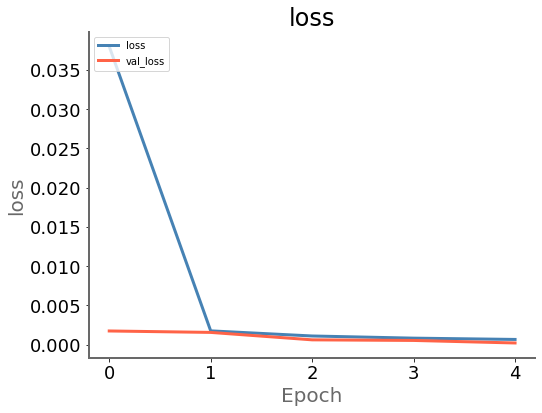

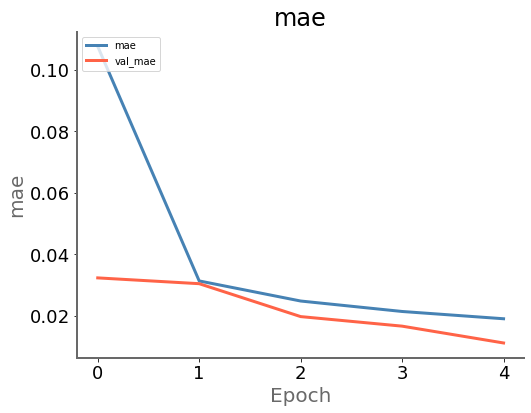

In [13]:
pwk.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='03-history')

## Step 5 - Predict

### 5.1 - Load model

In [14]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
print('Loaded.')

Loaded.


### 5.2 - Make a 1-step prediction
A simple prediction on a single iteration

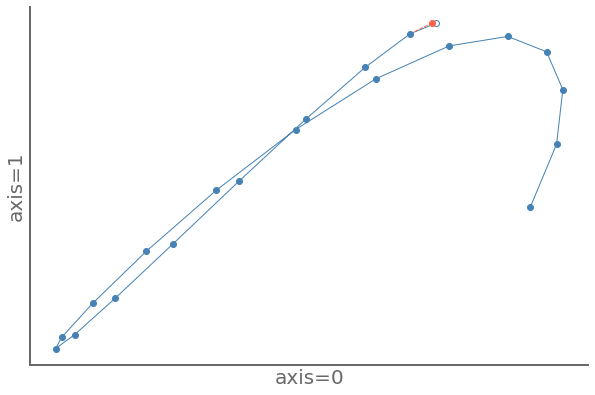

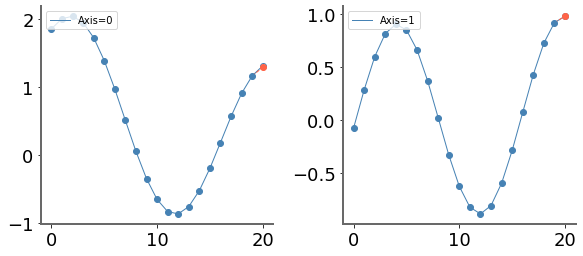

In [15]:
s=random.randint(0,len(x_test)-sequence_len)

sequence      = x_test[s:s+sequence_len]
sequence_true = x_test[s:s+sequence_len+1]

sequence_pred = loaded_model.predict( np.array([sequence]) )

pwk.plot_2d_segment(sequence_true, sequence_pred)
pwk.plot_multivariate_serie(sequence_true, predictions=sequence_pred, labels=['Axis=0', 'Axis=1'],save_as='04-one-step-prediction')

### 5.3 - Make n-steps prediction
A longer term prediction, via a nice iteration function :

In [16]:
def get_prediction(dataset, model, iterations=4):

    # ---- Initial sequence
    #
    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate 
    #
    sequence_pred = list(sequence_pred)

    for i in range(iterations):
        sequence   = sequence_pred[-sequence_len:]
        prediction = model.predict( np.array([sequence]) )
        sequence_pred.append(prediction[0])

    # ---- Extract the predictions    
    #
    prediction = np.array(sequence_pred[-iterations:])

    return sequence_true,prediction

An n-steps prediction :

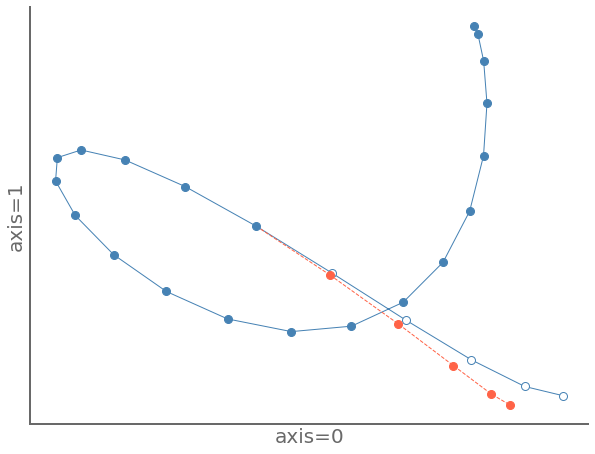

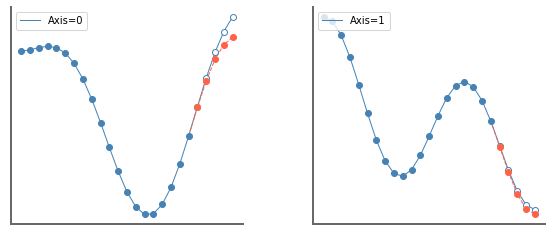

In [17]:
sequence_true, sequence_pred = get_prediction(x_test, loaded_model, iterations=5)

pwk.plot_2d_segment(sequence_true, sequence_pred, ms=8, save_as='02-prediction-norm')
pwk.plot_multivariate_serie(sequence_true, predictions=sequence_pred, hide_ticks=True, labels=['Axis=0', 'Axis=1'],save_as='02-prediction-norm')

In [18]:
pwk.end()

End time is : Sunday 07 March 2021, 21:15:55
Duration is : 00:02:30 004ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>